# Pràctica 1: Resolem un problema de classificació

## Objectius

Els objectius d'aquesta pràctica són:

* Aplicar els coneixements adquirits sobre processament de dades, classificació i validacio creuada.
  
* Ser capaç de comparar diferents models de classificació.

* Ser capac de fer cerca d'hiperparàmetres.

* Entendre i implementar la validació creuada.

* Analitzar detalladament els resultats obtinguts durant l'aprenentatge dels diferents models.

Aquesta pràctica és prèvia al cas kaggle que realitzareu durant la segona part de l'assignatura. En aquesta primera pràctica les preguntes estan definides, però us ha de servir d'aprenentatge a l'hora de saber com estructurar un projecte d'aprenentatge automàtic ja que en el cas kaggle no tindreu les preguntes.

## Base de dades

En aquesta pràctica farem servir la base de dades del titanic. L'atribut que predirem es Survived, el qual ens diu si cada passatger va sobreviure o no.


https://www.kaggle.com/c/titanic/data


## Treball en grup
Aquesta pràctica es treballarà en grups de 2-3 persones. En casos excepcionals i degudament justificats la pràctica es podrà realitzar de forma individual.

## Seguiment i entrega de la pràctica

En la pràctica 1 es presenten diverses tasques per fer una correcta comparativa dels resultats obtinguts per diversos mètodes de classificació en una mateixa base de dades.

En aquesta pràctica es realitzaran sessions de seguiment del treball. Aquestes sessions de treball estan orientades a que els alumnes que vingueu pugueu preguntar i resoldre dubtes sobre les dades, preguntar sobre l'objectiu de cada apartat dels enunciats que no us hagi quedat clar, i preguntar sobre els resultats que esteu obtenint a l'hora d'analitzar les dades. És molt recomanable venir a classe amb el treball fet per tal de poder comentar dubtes.

Pel que fa l'entrega, caldrà entregar per caronte el següent:

1. Memòria en format PDF explicant els resultats trobats sobre la bases de dades. La memòria ha d'utilitzar la plantilla de LaTeX que podeu trobar al Caronte i ha de ser de com a màxim 3 pàgines.
   
2. Notebook amb el respectiu codi de python.

3. (Opcional) Presentació amb els resultats 4 min màxim.

# Descripció de la pràctica

A continuació es mostren tots els continguts que s'evaluaran en la pràctica:

1. EDA (exploratory data analysis) (1 punt):
  * Anàlisi de tamany i tipologia de dades
  * Primera valoració de correlacions
  * Anàlisi atribut target
2. Preprocessing (2 punts):
  * Eliminació de nans
  * Encoding de categòriques
  * Altres (PCA, normalització, ...)
3. Metric selection (1.5 punts):
  * Selecció de la millor mètrica pel problema
  * Visualització de ROC/AUC per model base
4. Model Selection amb Crossvalidation (4 punts):
  * Selecció del millor model
  * Cerca d'hiperparàmetres
5. Anàlisi final (1.5 punt)

La pràctica esta construida a partir d'un seguit de preguntes orientatives en cada apartat les quals tenen relació amb els continguts evaluables. **NO cal contestar-les totes**. Són una guia per a que reflexioneu i aprengueu detalls de cada apartat. És recomanable llegir totes les preguntes abans de realitzar la pràctica i tenir-les en ment a l'hora d'executar-la.


**IMPORTANT**: El que es valorarà en la pràctica és la capacitat de mantenir una narrativa coherent alhora que s'expliquen els resultats. No es mirarà tant que alguna pregunta quedi per respondre sinó que els passos seguits en base als resultats obtinguts siguin coherents.

### 1. EDA (exploratory data analysis) (1 punt)

Abans de res cal sempre veure com es la base de dades assignada.

**Preguntes:**
- Quants atributs té la vostra base de dades?
- Quin tipus d'atributs teniu? (Númerics, temporals, categòrics, binaris...)
- Com es el target? quantes categories diferents existeixen?
- Tenim nans en les dades?
- Podeu veure alguna correlació entre X i y?
- Estan balancejades les etiquetes (distribució similar entre categories)? Creieu que pot afectar a la classificació la seva distribució?

bPrimer, importem la llibreria `pandas` i llegim el fitxer de dades `.csv`.

In [84]:
from xml.sax.handler import feature_external_ges

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.scale import LogisticTransform
from statsmodels.tools.linalg import stationary_solve
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv("./titanic/train.csv")
DATAFRAME_RAW = df
EXPLANATORY = "Survived"

Podem analitzar els atributs de la base de dades fent servir la comanda `describe()`:

In [85]:
df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Observem que la nostra base de dades conté **12 atributs**, dels següents tipus:

In [86]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

On `int64` és un nombre enter (numèric), `float64` és un nombre decimal (numèric) i `object` és text (es podria considerar una etiqueta o categòrica).

Però veiem que podem assignar altres tipus en funció del significat de cada columna:

- `PassengerId`: etiqueta: identifica a cada persona
- `Survived`: binària: `1`=si o `0`=no
- `Pclass`: categòrica: `1`=primera, `2`=segona i `3`=tercera classe
- `Name`: etiqueta: identifica a cada persona (potser no de forma única)
- `Sex`: categòrica: `female` o `male`
- `Age`: numèrica: edat en anys
- `SibSp`: numèrica: nombre de germans o parelles en el Titanic
- `Parch`: numèrica: nombre de pares o fills en el Titanic
- `Ticket`: text: codi del tiquet
- `Fare`: numèrica: preu del tiquet
- `Cabin`: text: codi de la cabina
- `Embarked`: categòrica: port d'embarcació, `C`=Cherbourg, `Q`=Queenstown i `S`=Southampton

Per aquest estudi, el target és l'atribut binari `Survived`, que pot prendre dos valors: 0 o 1:

In [87]:
df["Survived"].unique()

array([0, 1])


Per analitzar la qualitat de les dades, mirem quantes files tenen dades incompletes.

In [88]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

De les 891 dades, falta el port d'embarcació `Embarked` per a dues persones, l'edat per a 177 i la cabina per a 687.

Les dues persones sense port d'embarcació no son molt importants, podríem fins i tot prescindir d'aquestes files. L'edat podria ser un problema, i la cabina, que d'entrada sembla que pot ser la variable explicativa més important, no apareix en la majoria de files.

Per detectar possibles correlacions en les dades, podem calcular el coeficient de correlació de Pearson entre tots els atributs numèrics i representar-los en una gràfica de calor.

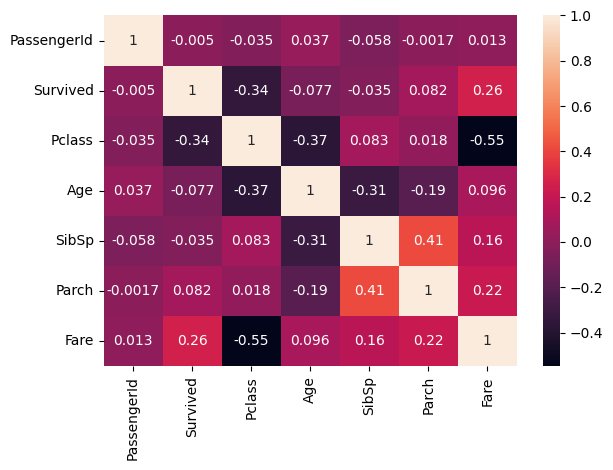

In [89]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.tight_layout()
plt.show()

Unes quantes observacions (comentarem la correlació només a una de les dues variables):

- `PassengerId`: aquesta no té correlació significant amb cap dels altres atributs (com és d'esperar)
- `Survived`: obté la seva màxima correlació (inversament) amb `Pclass` i `Fare`: com més gran la classe, més petita la probabilitat de supervivència, i com més car el tiquet, més probabilitat
- `Pclass`: correlació inversa amb el preu del tiquet (està clar) i també amb l'edat, és dir els més joves es trobaven a classes més altes
- `Age`: relació inversa amb el nombre de germans/parelles i pares/fills, com més joves més germans/parelles i pares/fills
- `SibSp`: correlació amb el nombre de pares/fills, com més fills/parelles, més pares/fills
- `Parch`: correlació molt petita amb el preu del tiquet

Estudiem ara la distribució de les dades amb histogrames per cada atribut numèric (afegim les columnes `Embarked` i `Sex` al gràfic).

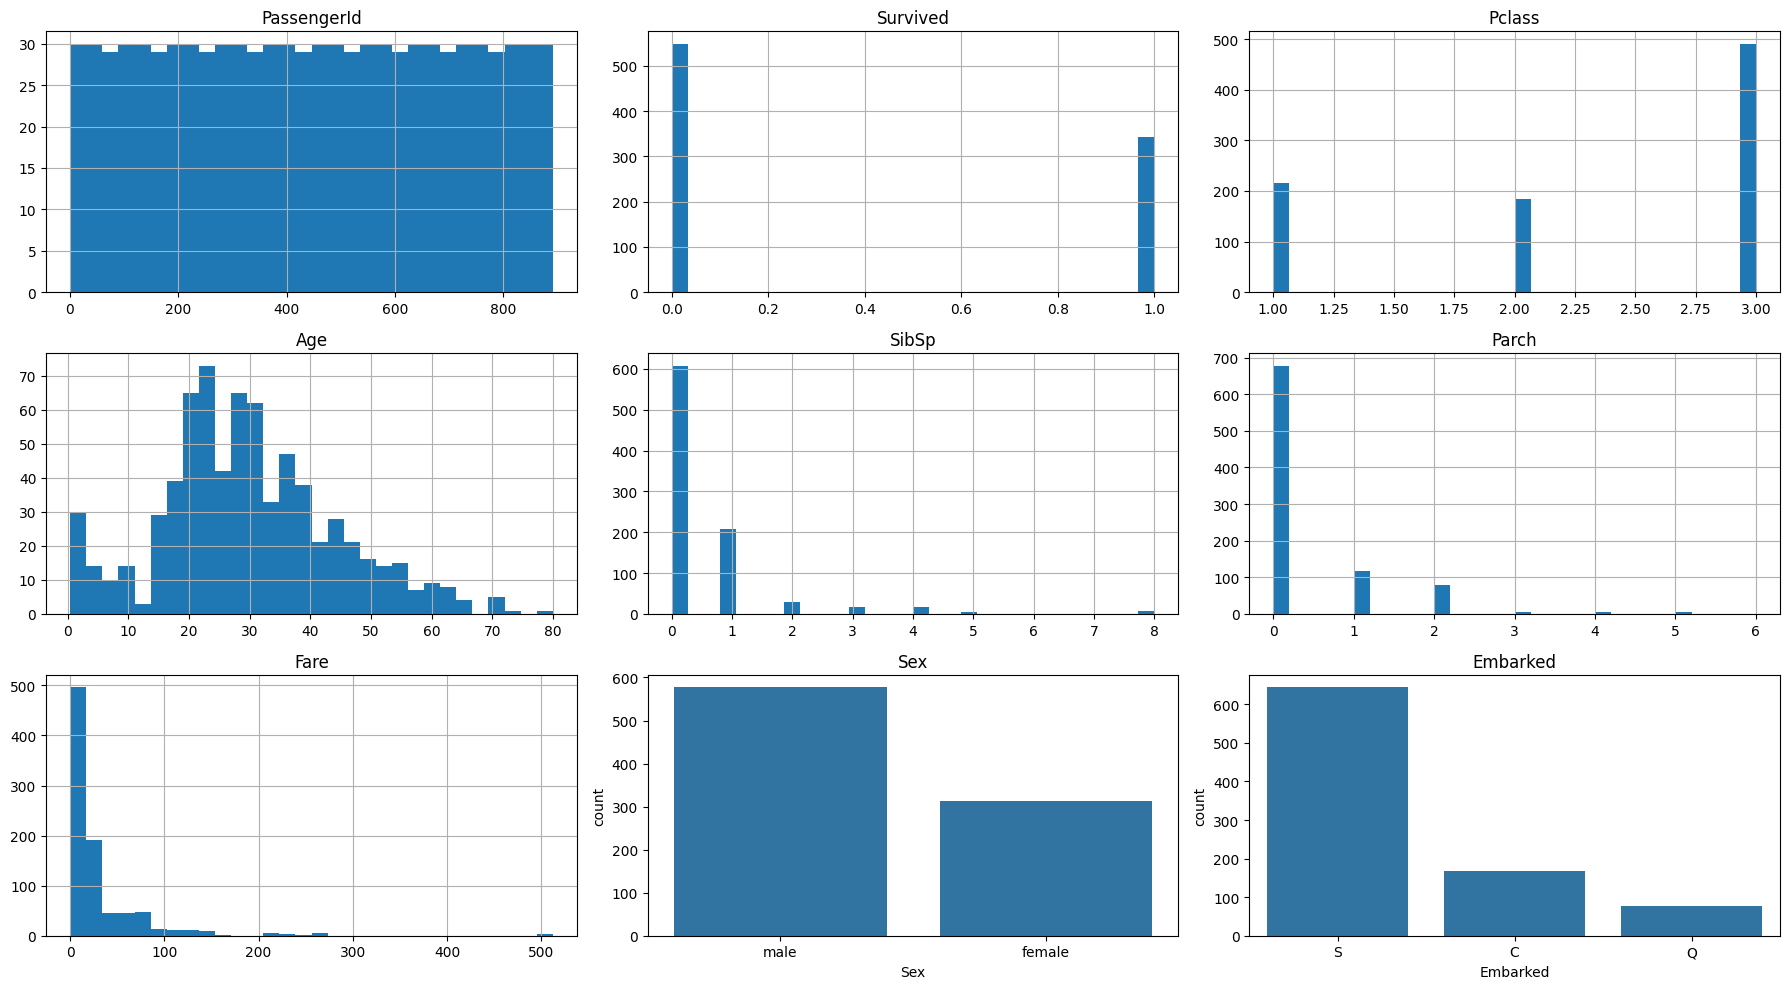

In [90]:
cols = list(df.select_dtypes("number")) + ["Sex", "Embarked"]
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if df[col].dtype == "object":
        sns.countplot(x=col, data=df, ax=ax)
    else:
        df[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Veiem que la distribució de l'edat té forma bastant normal (la distribució), amb una petita acumulació a edats petites. Les dues variables quantitatives enteres (`SibSp` i `Parch`) tenen més representació per a nombres petits.

Mirem amb més detall les distribucions de les altres columnes.

In [91]:
for col in ["Survived", "Pclass", "Sex", "Embarked"]:
    print(f"{col}:\n\t- {"\n\t- ".join([f"{key}: {value:.2%}" for key, value in dict(df[col].value_counts(normalize=True)).items()])}")

Survived:
	- 0: 61.62%
	- 1: 38.38%
Pclass:
	- 3: 55.11%
	- 1: 24.24%
	- 2: 20.65%
Sex:
	- male: 64.76%
	- female: 35.24%
Embarked:
	- S: 72.44%
	- C: 18.90%
	- Q: 8.66%


Tenim representació prou bona per totes les etiquetes, només pel port Queenstown una mica menys, però no és res greu.

Ara per ara, creiem que la distribució de les dades no influirà molt en la predicció de les dades, i que no donarà problemes. Faltaria fer una selecció, normalització i processament dels atributs per acabar de concloure si la distribució ens afectarà la predicció final, que és el que farem a la següent secció.

### 2. Preprocessing (normalitzation, outlier removal, feature selection, ...) (2 punts)
Un cop vistes les dades de les que es disposa, cal preparar les dades per als nostres algoritmes. Segons la tipologia de dades, es poden filtrar atributs, aplicar-hi reductors de dimensionalitat, codificar categories textuals en valors numèrics, normalitzar les dades, treure outliers...

Navegueu per la [documentació de sklearn sobre preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) per tal de trobar les diferents opcions que proporciona sklearn.

**Preguntes:**
* Estan les dades normalitzades? Caldria fer-ho?
* En cas que les normalitzeu, quin tipus de normalització serà més adient per a les vostres dades?
* Teniu gaires dades sense informació (nans)? Tingueu en compte que hi ha metodes que no els toleren durant l'aprenentatge. Com afecta a la classificació si les filtrem? I si les reompliu? Com ho farieu? [Pista](https://scikit-learn.org/stable/modules/impute.html)
* Teniu dades categòriques? Quina seria la codificació amb més sentit?
* Podreu treure algun atribut extra de les categòriques (per exemple, aplicant alguna regla sobre el text)?
* Caldria aplicar PCA? Quins beneficis o inconvenients trobarieu?
* Caldria aplicar alguna tècnica de selecció de variables? Ho trobeu necessari?

Llibreries que farem servir en aquesta secció.

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

A partir de les conclusions extretes de la secció anterior, comencem a fer el preprocessing de tot el dataset. Ja hem vist que tenim moltes dades que falten, sobretot en el cas de l'edat i la cabina.

In [93]:
nan_count = df.isna().sum()
nan_percent = (nan_count / len(df)) * 100
nan_info = pd.DataFrame({
    "NaN Count": nan_count,
    "NaN Percent": nan_percent
})

nan_info[nan_info["NaN Count"] > 0]

,NaN Count,NaN Percent
Age,177,19.865320
Cabin,687,77.104377
Embarked,2,0.224467


Començant per la cabina: veiem que falta una quantitat de dades molt gran, quasi el 80%. Per tant, seria molt complicat i gens significatiu aplicar qualsevol tipus d'imputació sobre aquesta columna. També observem que és una dada molt rellevant per la supervivència dels passatgers. Si busquem un esquema del Titanic, podem veure que els decks estan organitzats de la següent manera:

<div>
<img src="titanic/decks.png" width="500"/>
</div>

Per tant, com podem veure les cabines que son del deck G estan a baix de tot del vaixell, i les de l'A son les de més amunt. Creiem que el deck és una dada molt important per predir la supervivència, per tant, l'extraiem a partir del codi de cabina. Veiem que els codis son el deck més un nombre de cabina, sobre el qual no hem pogut trobar més informació.

Mirem els decks que surten a la base de dades.

In [94]:
sorted(df.loc[df["Cabin"].notna(), "Cabin"].str[0].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

Tenim cabines de tots els decks, i del `T`. Investiguem quantes cabines hi ha del deck `T`, que no sabem on és.b

In [95]:
df[df["Cabin"].str.contains("T", na=False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


Com només és un passatger, considerem que és un error, per tant, marcarem el deck d'aquest passatger com un NaN. Amb totes les altres cabines que falten, marcarem els decks de totes amb la lletra `X` per distingir-les de les cabines normals.

Volem poder generalitzar aquest preprocessing a qualsevol dataset, per tant, creem una funció personalitzada que faci aquesta anàlisi de la cabina i la creï la nova columna `Deck` en forma d'un transformer.

In [96]:
def extract_deck(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Extreure la primera lletra de la cabina a una nova columna
    dataframe["Deck"] = dataframe["Cabin"].str[0]

    # Validar els decks existents
    valid_decks = {"A", "B", "C", "D", "E", "F", "G"}
    dataframe["Deck"] = dataframe["Deck"].where(dataframe["Deck"].isin(valid_decks), "X")

    # Omplir els forats amb "X"
    dataframe["Deck"] = dataframe["Deck"].fillna("X")

    return dataframe

# Crear un transformer
extract_deck_transformer = FunctionTransformer(extract_deck, validate=False)

Podem provar el pipeline fet amb el dataframe que tenim, aplicant-li només aquesta transofrmació.

In [97]:
extract_deck_transformer.transform(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,X
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,X
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,X
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,X
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C


Veiem que tenim una columna extra: `Deck`.

A part d'això, també considerem que és important saber simplement si tenim informació sobre la cabina, observem les proporcions de cabines que falten en funció de la classe.

In [98]:
df.groupby("Pclass")["Cabin"].apply(lambda x: x.isna().mean())

Pclass
1    0.185185
2    0.913043
3    0.975560
Name: Cabin, dtype: float64

Clarament, la majoria de cabines que tenim son de la classe 1. Per tant, com és una dada rellevant, afegim aquest indicador.

In [99]:
def indicate_missing_cabin(dataframe: pd.DataFrame, column: str = "Cabin") -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Crear una columna que indiqui si Cabin és available o no
    dataframe[column + "__missing"] = dataframe[column].isna().astype(int)

    return dataframe

# Crear un transformer
indicate_missing_cabin_transformer = FunctionTransformer(indicate_missing_cabin, validate=False)

I comprovem que funciona:

In [100]:
indicate_missing_cabin_transformer.transform(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin__missing
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


Anem a estudiar ara la columna `Embarked`. Sabem que només hi ha dues files, anem a veure-les:b

In [101]:
df[df["Embarked"].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Sabem que aquesta columna indica el port on ha pujat el passatger, per tant, podríem estimar a quin port ha pujat el passatger mirant els altres passatgers que han pagat un preu similar (òviament considerant la mateixa classe).

Per tant, mirem els passatgers amb la mateixa classe i preu similar, considerant més o menys 5 dòlars. Calculem la freqüència absoluta de cada port.

In [102]:
df[(df["Embarked"].notna()) & (df["Pclass"] == 1) & (75 <= df["Fare"]) & (df["Fare"] <= 85)]["Embarked"].value_counts()

Embarked
C    16
S    13
Name: count, dtype: int64

Veiem que aquests filtres inclouen 29 passatgers, dels quals 16 has pujat al port `C`, Cherbourg.

Sembla raonable considerar aquest mini-algoritme per determinar el port d'embarcació més probable. Implementem-lo amb una funció transformer com abans.

In [103]:
def impute_embarked(dataframe: pd.DataFrame, tolerance: float = 10.0) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    for idx, row in dataframe[dataframe["Embarked"].isna()].iterrows():
        pclass = row["Pclass"]
        fare = row["Fare"]

        # Candidats: mateix Pclass, Fare amb tolerància de +-10
        candidates = df[
            (df["Pclass"] == pclass) &
            (df["Embarked"].notna()) &
            (df["Fare"] >= fare - 10) &
            (df["Fare"] <= fare + 10)
        ]

        # Si s'han trobat candidats
        if not candidates.empty:
            dataframe.at[idx, "Embarked"] = candidates["Embarked"].mode()[0]
        else:
            # Si no s'han trobat candidats, agafar la moda de tot el dataframe
            dataframe.at[idx, "Embarked"] = dataframe["Embarked"].mode()[0]

    return dataframe

# Crear un transformer
impute_embarked_transformer = FunctionTransformer(impute_embarked, validate=False)

Comprovem que funciona, veient que no hi ha cap dada amb el port d'embarcació no disponible.

In [104]:
impute_embarked_transformer.transform(df)["Embarked"].isna().sum()

np.int64(0)

Ara hem de tractar les edats que falten. Representen una cinquena part de les dades, per tant, intentarem imputar fent servir algun algoritme o relació que observem amb els altres atributs.

Fem una primera gràfica amb la quantitat de passatgers amb una certa edat separant les classes. En aquest cas, no ens interessa el valor absolut de la quantiat de gent, només la proporció entre cada classe, per tant, indiquem l'opció `fill` per obtenir un sentit de les proporcions per cada franja d'edat.

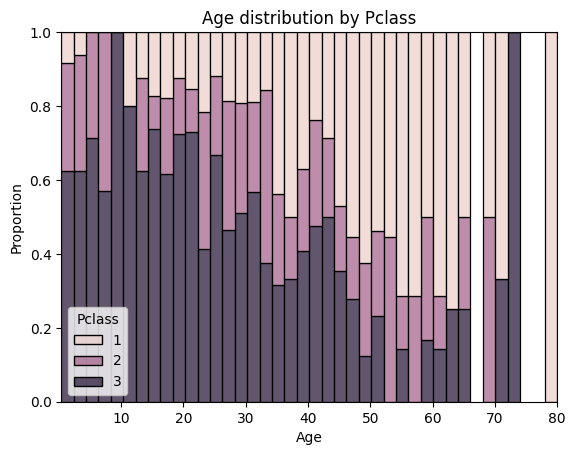

In [105]:
sns.histplot(
    data=df,
    x="Age",
    hue="Pclass",
    multiple="fill",
    bins=40
)

plt.xlabel("Age")
plt.ylabel("Proportion")
plt.title("Age distribution by Pclass")
plt.show()

Veiem que la classe 1 està centrada més a la dreta, i les classes 2 i 3 més a l'esquerra. Lo important d'aquesta gràfica és que les tres classes no tenen proporcions constants per totes les edats. Mirem ara les mitjanes d'edats per cada classe.

In [106]:
df.groupby("Pclass")["Age"].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

Veiem que hi ha una diferència important d'edats entre les classes.

A partir d'aquesta informació, ja podríem calcular una mediana de les classes, i imputar aquest valor a cada passatger, però pensem que és massa brut fer-ho per una cinquena part del dataset, introduirà molta uniformitat i canviarà la distribució. Com ja hem vist amb el mapa de calor dels coeficients de correlació, l'edat tenia relació amb el nombre de germans/parelles i fills/pares, per tant, considerem que podem treure més informació de les dades que tenim per aconseguir una predicció més ajustada. Pensant en les noves columnes que hem afegit, creiem que podríem expandir les dades que tenim per aconseguir una predicció millor que només la moda. Mirem, per exemple, la distribució en funció de si es té informació de la cabina o no (per això, hem d'aplicar el transformer corresponent a la base de dades).

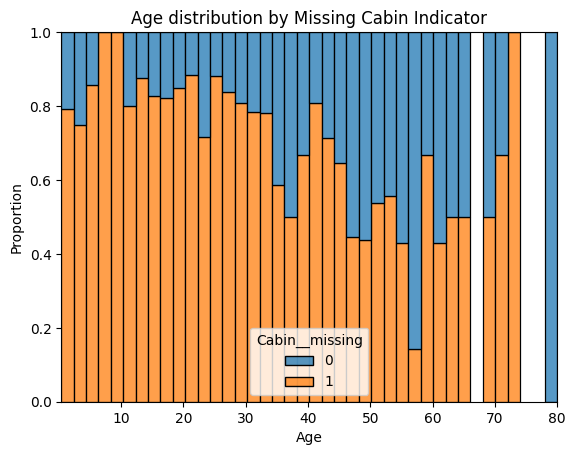

In [107]:
sns.histplot(
    data=indicate_missing_cabin_transformer.transform(df),
    x="Age",
    hue="Cabin__missing",
    multiple="fill",
    bins=40
)

plt.xlabel("Age")
plt.ylabel("Proportion")
plt.title("Age distribution by Missing Cabin Indicator")
plt.show()

A més, mirant les freqüències absolutes observem que també hi ha una gran diferència a la quantitat de gent en funció d'aquest indicador. En aquesta gràfica els dos grups (amb, i sense cabina indicada) estan superposats.

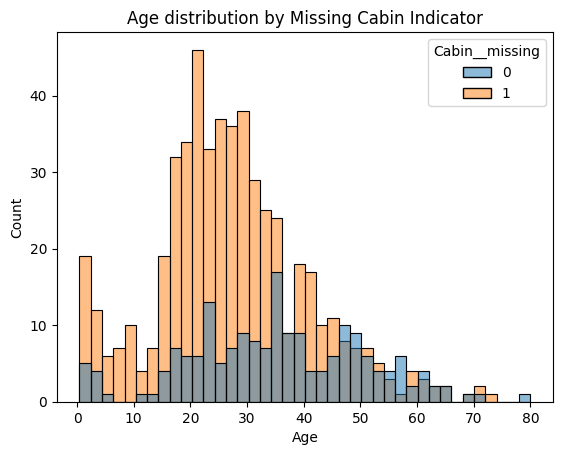

In [108]:
sns.histplot(
    data=indicate_missing_cabin_transformer.transform(df),
    x="Age",
    hue="Cabin__missing",
    bins=40
)

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution by Missing Cabin Indicator")
plt.show()

Mirem totes les columnes que tenim disponibles (considerant les transformacions ja fetes): `PassengerId`, `Survived`, `Pclass`, `Name`, `Sex`, `Age`, `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, `Embarked`, `Deck`,`Cabin__missing`.

Fent un cop d'ull a la columna `Name`, veiem que hi ha noms que contenen tractaments, com "Mr.", "Mrs." i "Master.". Aquest podrien constituir un molt bon indicador de la seva edat, ja que, per exemple, master es fa servir per nens petits. Mirem tots els tractaments que apareixen (hem de fer servir la funció `extract` amb un regex per extreure el tractament abans del punt), i analitzem quants passatgers tenim per cada un amb, i sense edat.

In [109]:
df.groupby(df["Name"].str.extract(r"(\w+)\.", expand=False))["Age"].agg(
    WithAge=lambda x: x.notna().sum(),
    MissingAge=lambda x: x.isna().sum()
)

,WithAge,MissingAge
Name,,
Capt,1,0
Col,2,0
Countess,1,0
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,1,0
Major,2,0
Master,36,4


Veiem que hi ha molts títols que son el mateix escrit de dues formes, només apareixen per a una persona o son similars en significat, així que resumirem aquesta llista a unes categories més generals. Això ho farem en la funció transformer.

Tornem a l'anàlisi: agafem per exemple el títol "Master", i mirem la mitjana d'edat.

In [110]:
df[df["Name"].str.contains("Master.", regex=False)]["Age"].mean()

np.float64(4.574166666666667)

Clarament, pels passatgers amb títol master imputarem una edat semblant a aquesta, és dir molt petita.

Per poder treballar millor amb aquestes tractaments, creem un transformer que afegeixi aquesta columna a la nostra base de dades (fent el resum que comentàvem abans).

In [111]:
def extract_title(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Extreure el tractament i guardar-lo en una nova columna
    dataframe["Title"] = dataframe["Name"].str.extract(r"(\w+)\.", expand=False)

    return dataframe

# Crear un transformer
extract_title_transformer = FunctionTransformer(extract_title, validate=False)

Veiem que realment funciona.

In [112]:
extract_title_transformer.transform(df)["Title"].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

I que no té cap cel·la sense títol.

In [113]:
extract_title_transformer.transform(df)["Title"].isna().sum()

np.int64(0)

Pensant intuïtivament, és probable que com més gran sigui la familia de cada individu, més petita serà l'edad mitjana, considerant que la major part son nens. Per tant, proposem una nova columna agregada que, en aquest cas, és simplement la suma del nombre de germans/parelles i pares/fills. Com sempre, creem una funció per dur a terme aquesta transformació.

In [114]:
def add_family_size(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Extreure els membres de la familia (+1 per aquell passatger)
    dataframe["FamilySize"] = dataframe["SibSp"] + dataframe["Parch"] + 1

    return dataframe

# Crear un transformer
add_family_size_transformer = FunctionTransformer(add_family_size, validate=False)

Comprovem que funciona correctament.

In [115]:
add_family_size_transformer.transform(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


logistic_regressor_tester.plot_decision_boundary(features=["Age", "Fare"])
Comprovem ràpidament la nostra hipòtesi mirant només el coeficient de correlació de Pearson (que detecta relació de linealitat entre les dues variables).

In [116]:
df["Age"].corr(add_family_size_transformer.transform(df)["FamilySize"])

np.float64(-0.3019139591924766)

Dona negatiu, com esperàvem, és dir que a més membres en la familia, menor és l'edat. En valor absolut no és gaire convincent, es considera un valor baix, però de moment inclourem aquesta dada per fer la predicció de l'edat.

Amb totes les noves features que hem creat en la base de dades, ja podem pensar en com podem predir l'edat per a les persones que no en tenen una indicada. Estem en un cas ideal per fer servir l'algoritme KNN. Té sentit que si dos passatgers estan "a prop" en aquest espai multidimensional, tinguin edats similars. Per això, farem servir les variables categòriques títol i deck (que passarem a variables indicadores binàries), les numèriques preu, germans/parelles, pares/fills, membres de la familia i la binària que ens diu si té indicada una cabina.

Com aquest algoritme KNN és sensible a l'escala de les variables (ja que tracta amb distàncies), és necessari aplicar una normalització de les dades numèriques abans de començar el procés iteratiu.

Implementem tot això a través d'un pipeline que automàticament ens passa les categòriques a binàries, normalitza i prediu les edats (després d'incloure tots els transformers fets anteriorment).

In [117]:
categorical_features = ["Title", "Cabin__missing", "Pclass"]
numerical_features = ["Fare", "SibSp", "Parch", "FamilySize"]

age_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features),
        ("pred", "passthrough", ["Age"])
    ]
)

age_pipeline = Pipeline([
    ("missing_cabin", indicate_missing_cabin_transformer),
    ("extract_title", extract_title_transformer),
    ("add_family_size", add_family_size_transformer),
    ("preprocessor", age_preprocessor),
    ("imputer", KNNImputer(n_neighbors=5))
])

Executem el pipeline i guardem el resultat final per fer unes observacions.

In [118]:
new_df = pd.DataFrame(age_pipeline.fit_transform(df), columns=age_pipeline.named_steps["preprocessor"].get_feature_names_out())
new_df.describe()

,cat__Title_Col,cat__Title_Countess,cat__Title_Don,cat__Title_Dr,cat__Title_Jonkheer,cat__Title_Lady,cat__Title_Major,cat__Title_Master,cat__Title_Miss,cat__Title_Mlle,...,cat__Title_Rev,cat__Title_Sir,cat__Cabin__missing_1,cat__Pclass_2,cat__Pclass_3,num__Fare,num__SibSp,num__Parch,num__FamilySize,pred__Age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000
mean,0.002245,0.001122,0.001122,0.007856,0.001122,0.001122,0.002245,0.044893,0.204265,0.002245,...,0.006734,0.001122,0.771044,0.206510,0.551066,3.987333e-18,4.386066e-17,5.382900e-17,-2.392400e-17,29.542355
std,0.047351,0.033501,0.033501,0.088337,0.033501,0.033501,0.047351,0.207186,0.403390,0.047351,...,0.081830,0.033501,0.420397,0.405028,0.497665,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,13.762104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-6.484217e-01,-4.745452e-01,-4.736736e-01,-5.609748e-01,0.420000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,-4.891482e-01,-4.745452e-01,-4.736736e-01,-5.609748e-01,21.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,-3.573909e-01,-4.745452e-01,-4.736736e-01,-5.609748e-01,28.600000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,-2.424635e-02,4.327934e-01,-4.736736e-01,5.915988e-02,38.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,9.667167e+00,6.784163e+00,6.974147e+00,5.640372e+00,80.000000


Mirem, primer, que ara sí tinguem totes les dades sense NaN's (entre les columnes que hem fet servir en el preprocessador pel KNN, per exemple cabines segueix tenint NaN's).

In [119]:
new_df.isna().sum().sum()

np.int64(0)

Ara comparem les edats mitjanes per títol abans, i després de l'imputament amb el KNN.

In [120]:
df_titled = extract_title_transformer.transform(df)
df_titled["Imputed Age"] = new_df.iloc[:, -1]
age_comparison = pd.DataFrame({
    "Original_Age": df_titled.groupby("Title")["Age"].mean(),
    "Imputed_Age": df_titled.groupby("Title")["Imputed Age"].mean(),
})
age_comparison["NaN_Count"] = df_titled.groupby("Title")["Age"].apply(lambda x: x.isna().sum())
age_comparison["Difference"] = age_comparison["Imputed_Age"] - age_comparison["Original_Age"]

age_comparison

,Original_Age,Imputed_Age,NaN_Count,Difference
Title,,,,
Capt,70.000000,70.000000,0,0.000000
Col,58.000000,58.000000,0,0.000000
Countess,33.000000,33.000000,0,0.000000
Don,40.000000,40.000000,0,0.000000
Dr,42.000000,41.314286,1,-0.685714
Jonkheer,38.000000,38.000000,0,0.000000
Lady,48.000000,48.000000,0,0.000000
Major,48.500000,48.500000,0,0.000000
Master,4.574167,4.770950,4,0.196783


Podem observar que l'algoritme KNN ha estat molt fidel amb el que nosaltres esperàvem, que les edats siguin semblants pel mateix títol. Veiem que les mitjanes per honorífic han canviat molt poc.

Analitzem també les distribucions de les edats abans i després de l'imputament.

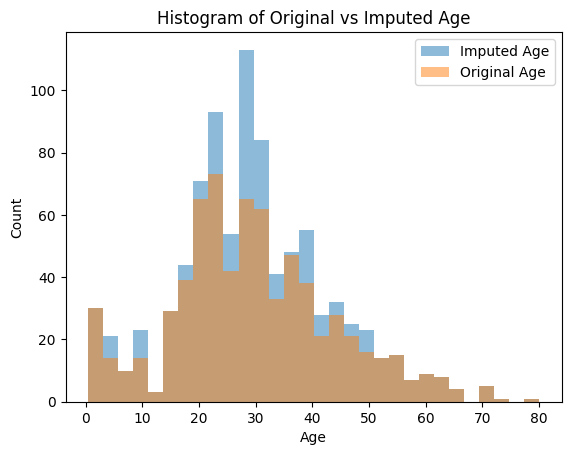

In [121]:
plt.hist(df_titled["Imputed Age"], bins=30, alpha=0.5, label="Imputed Age")
plt.hist(df_titled["Age"].dropna(), bins=30, alpha=0.5, label="Original Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Histogram of Original vs Imputed Age")
plt.legend()
plt.show()

Observem que la distribució de les edats imputades segueix prou precisament la forma de les edats originals, per tant donarem aquests resultats per bons.

Amb aquesta última anàlisi, acabem de tractar totes les columnes amb informació mancant. Fem un repàs:

- `Cabin`: hem extret la columna `Deck` (`extract_deck_transformer`) i hem afegit un indicador `Cabin__missing` per saber si disposem de la dada (`indicate_missing_cabin_transformer`)
- `Embark`: hem extret els passatgers de la mateixa classe i preu semblant i hem agafat la moda (`impute_embarked_transformer`)
- `Age`: hem vist que `Pclass` i `Cabin__missing` son importants per predir l'edat, hem extret el títol del nom per crear `Title` (`extract_title_transformer`) i la mida de la família a partir dels germans/parelles i pares/fills per crear `FamilySize` (`add_family_size_transformer`), i amb totes aquestes dades hem fet un KNN per predir les edats que faltaven (`age_pipeline`)

Com més endavant voldrem enllaçar tots els transformers en una pipeline, millorem el transformer de predicció de l'edat. Ho farem creant una classe custom a partir de les classes base de sklearn, implementant les funcions base `fit` i `transform`.

In [122]:
class AgeKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.age_features = ["Fare", "SibSp", "Parch", "FamilySize", "Title", "Cabin__missing", "Pclass"]
        self.ohe = None
        self.scaler = None
        self.knn = None
        self.column_transformer = None
        self.feature_names_out_ = None

    @staticmethod
    def create_necessary_features(dataframe_x: pd.DataFrame) -> pd.DataFrame:
        # Crear les features que calen si no hi son
        if "FamilySize" not in dataframe_x.columns:
            dataframe_x = add_family_size_transformer.transform(dataframe_x)
        if "Title" not in dataframe_x.columns:
            dataframe_x = extract_title_transformer.transform(dataframe_x)
        if "Cabin__missing" not in dataframe_x.columns:
            dataframe_x = indicate_missing_cabin_transformer.transform(dataframe_x)

        return dataframe_x

    def fit(self, dataframe_x, y=None):
        # Copiar el dataframe
        dataframe_x = dataframe_x.copy()

        # Crear les features que no existeixen
        dataframe_x = self.create_necessary_features(dataframe_x)

        # Features
        cat_fts = ["Title", "Cabin__missing", "Pclass"]
        num_fts = ["Fare", "SibSp", "Parch", "FamilySize"]

        # Transformadors
        self.column_transformer = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_fts),
                ("num", StandardScaler(), num_fts),
                ("pred", "passthrough", ["Age"])
            ]
        )

        # Fit dels transformadors
        self.column_transformer.fit(dataframe_x)

        # Fit KNNImputer
        transformed = self.column_transformer.transform(dataframe_x)
        self.knn = KNNImputer(n_neighbors=self.n_neighbors)
        self.knn.fit(transformed)

        # Guardar els noms de les columnes
        cat_features_out = self.column_transformer.named_transformers_["cat"].get_feature_names_out(categorical_features)
        self.feature_names_out_ = np.concatenate([cat_features_out, numerical_features, ["Age"]])

        return self

    def transform(self, dataframe_x):
        # Copiar el datagram
        dataframe_x = dataframe_x.copy()
        
        # Crear les features que no existeixen
        dataframe_x = self.create_necessary_features(dataframe_x)

        # Predir l'edat
        transformed = self.column_transformer.transform(dataframe_x)
        imputed = self.knn.transform(transformed)

        # Copiar els resultats
        result = dataframe_x.copy()
        result["Age"] = imputed[:, -1]

        return result

Provem si funciona la classe igual que abans.

In [123]:
age_knn_processor = AgeKNNImputer(n_neighbors=5)
age_knn_processor.fit(df)
new_df = age_knn_processor.transform(df)
new_df.isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
FamilySize          0
Title               0
Cabin__missing      0
dtype: int64

Veiem que retorna les mateixes columnes (els mateixos noms) més totes les auxiliars que es necessiten per fer la predicció. També observem que efectivament no queden valors nul·ls a la columna de les edats.

**IMPORTANT**: encara no hem encadenat tots els transformadors, és normal que tinguem embarked i cabines NaN's, en cap moment li hem aplicat el transformador corresponent per treure-les, al final de la secció farem un pipeline general amb totes les funcions.

En aquest moment ja tenim transformadors per aprofitar al màxim la informació de totes les columnes.

De la columna `Title` recordem que tenim moltes categories, de les quals la majoria son per a només poques persones. Com després haurem de passar aquesta variable a indicadors binaris, no volem tenir la meitat de features que siguin indicadors del títol, per tant, reduïm les categories d'aquesta variable a només unes quantes.

In [124]:
def compress_title(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Diccionari de categories
    mapping = {
        "Capt": "Military", "Col": "Military", "Major": "Military",
        "Don": "Nobility", "Dona": "Nobility", "Jonkheer": "Nobility",
        "Lady": "Nobility", "Sir": "Nobility", "Countess": "Nobility",
        "Master": "Nobility", "Miss": "Ms", "Mlle": "Ms", "Ms": "Ms",
        "Mrs": "Mrs", "Mme": "Mrs"
    }

    # Fer el mapeig
    dataframe["Title"] = dataframe["Title"].map(mapping).fillna(dataframe["Title"])

    return dataframe

compress_title_transformer = FunctionTransformer(compress_title, validate=False)

Veiem que funciona.

In [125]:
compress_title_transformer.transform(extract_title_transformer.transform(df))["Title"].value_counts()

Title
Mr          517
Ms          185
Mrs         126
Nobility     45
Dr            7
Rev           6
Military      5
Name: count, dtype: int64

De la columna del tiquet no hem pogut trobar ni extreure cap informació valuosa per la predicció, així que decidim esborrar-la.

Tornem ara a les distribucions de les dades numèriques i categòriques per decidir si tenim outliers o si caldria limitar el domini de cada atribut. Ho fem només ara perquè ara sí que tenim totes les dades que necessitem (sobretot, les edats), i també hem de considerar la columna creada `FamilySize`. La columna `Pclass` no la tindrem en compte perquè ja hem vist que està equilibrada i no hi ha valors extrems.

Creem un pipeline ràpid per afegir les columnes que falten i imputar les edats.

In [126]:
temp_preprocessor = Pipeline(steps=[
    ("extract_deck", extract_deck_transformer),
    ("missing_cabin", indicate_missing_cabin_transformer),
    ("impute_embarked", impute_embarked_transformer),
    ("extract_title", extract_title_transformer),
    ("add_family_size", add_family_size_transformer),
    ("impute_age", AgeKNNImputer()),
    ("compress_title", compress_title_transformer),
])

temp_df = temp_preprocessor.fit_transform(df)

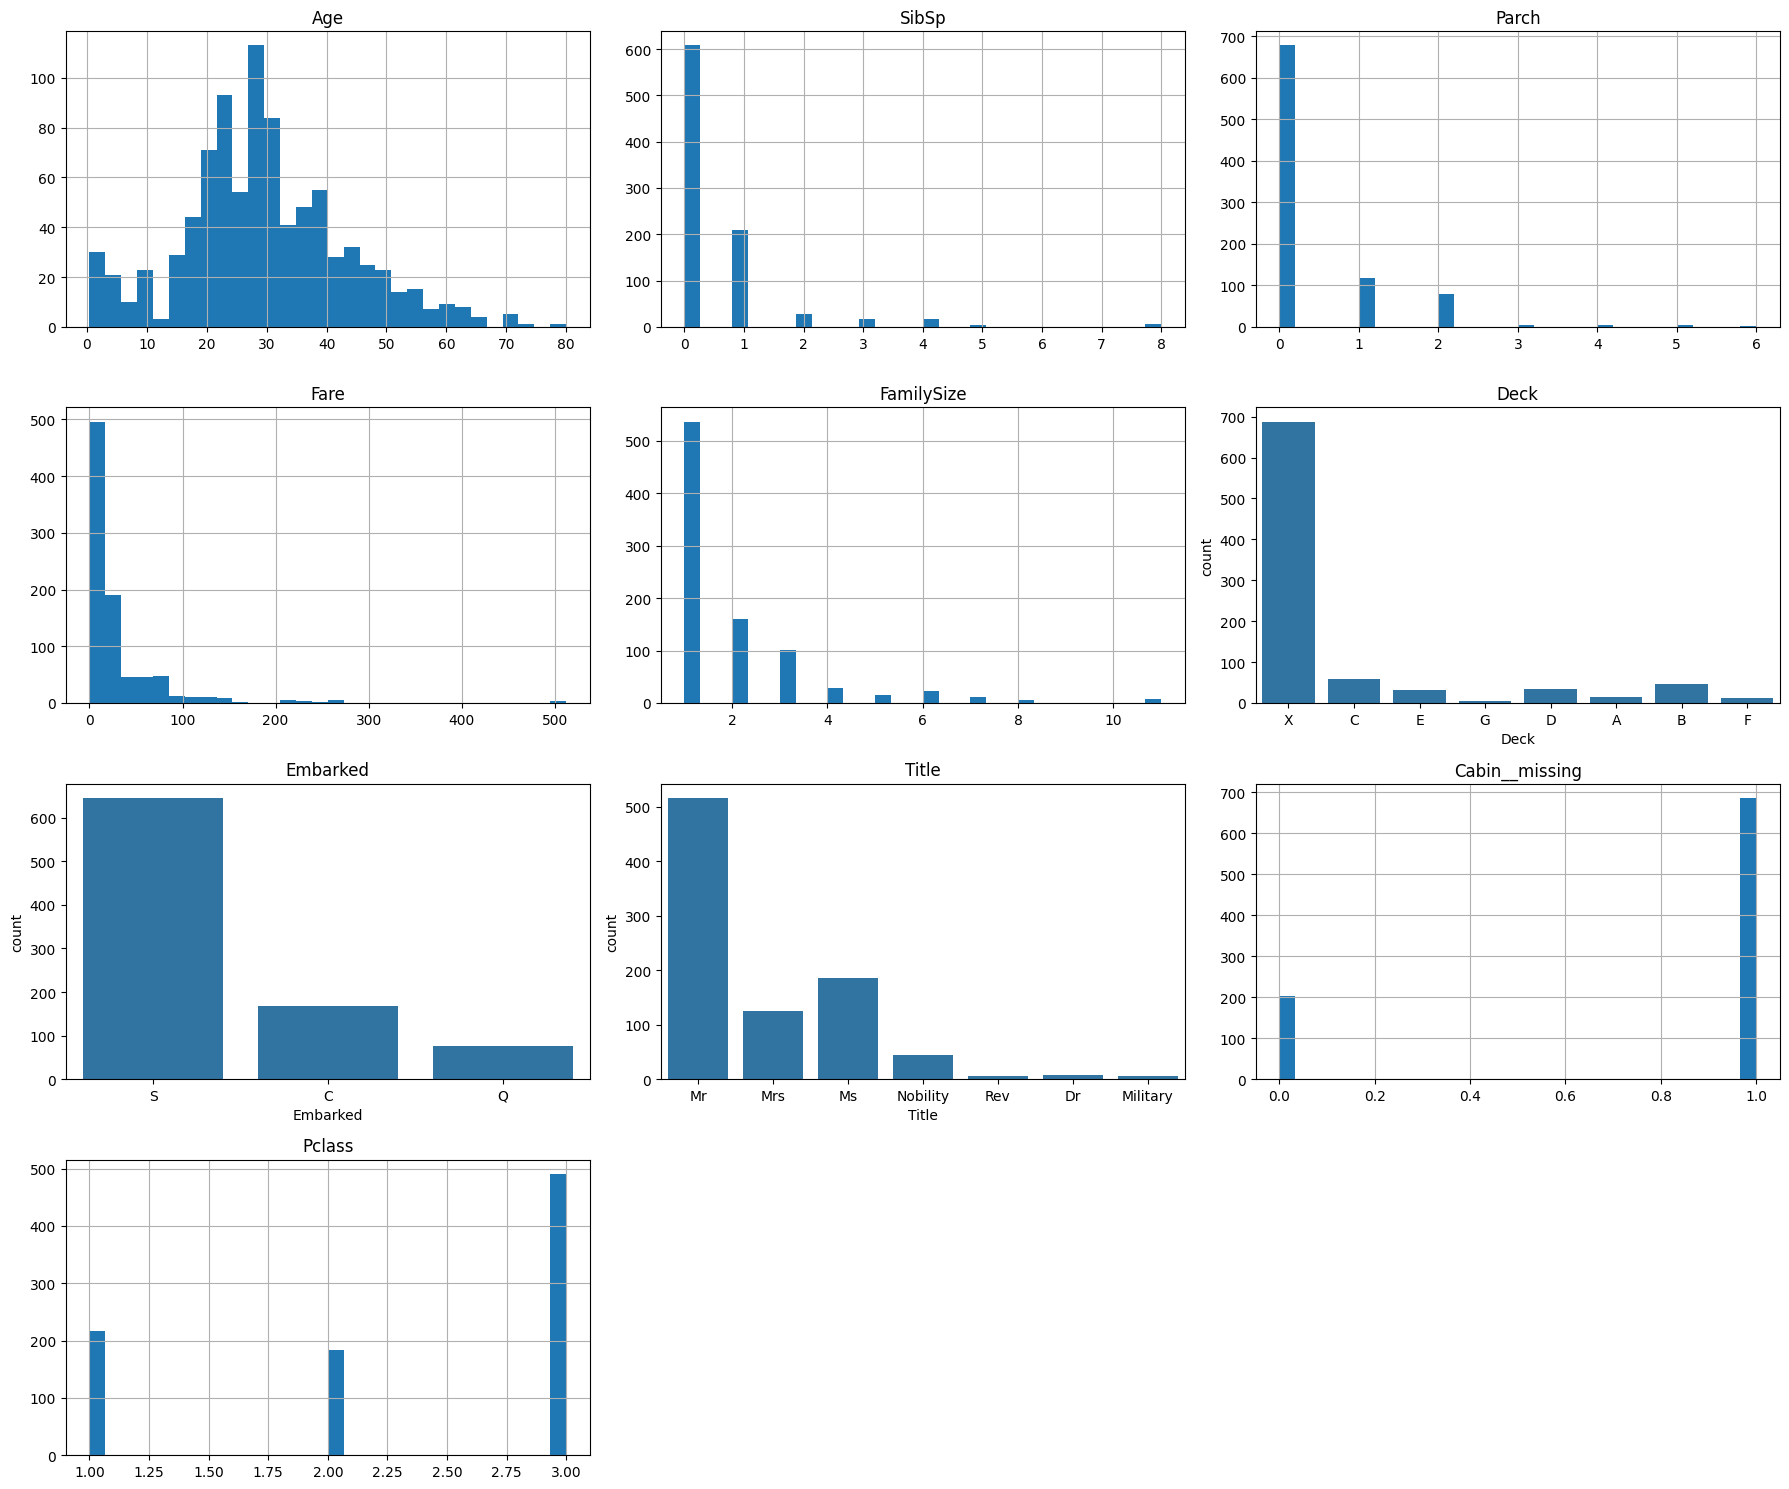

In [127]:
cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "Deck", "Embarked", "Title", "Cabin__missing", "Pclass"]
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if temp_df[col].dtype == "object":
        sns.countplot(x=col, data=temp_df, ax=ax)
    else:
        temp_df[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

La idea és trobar els valors "outlier", o atípics. Podem aconseguir això mirant l'interval interquartílic. Creem un transformador que ens retalli les variables numèriques a 1.5 cops aquest interval i veiem els resultats.

In [128]:
class IQRTrimmer(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.select_dtypes(include=[np.number]).columns:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - self.factor * iqr
            upper = q3 + self.factor * iqr
            self.bounds_[col] = (lower, upper)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, (lower, upper) in self.bounds_.items():
            if col in X.columns:
                X[col] = X[col].clip(lower=lower, upper=upper)
        return X

trimmer = IQRTrimmer()
temp_df_trimmed = trimmer.fit_transform(temp_df)

Repetim les gràfiques amb el nou dataframe.

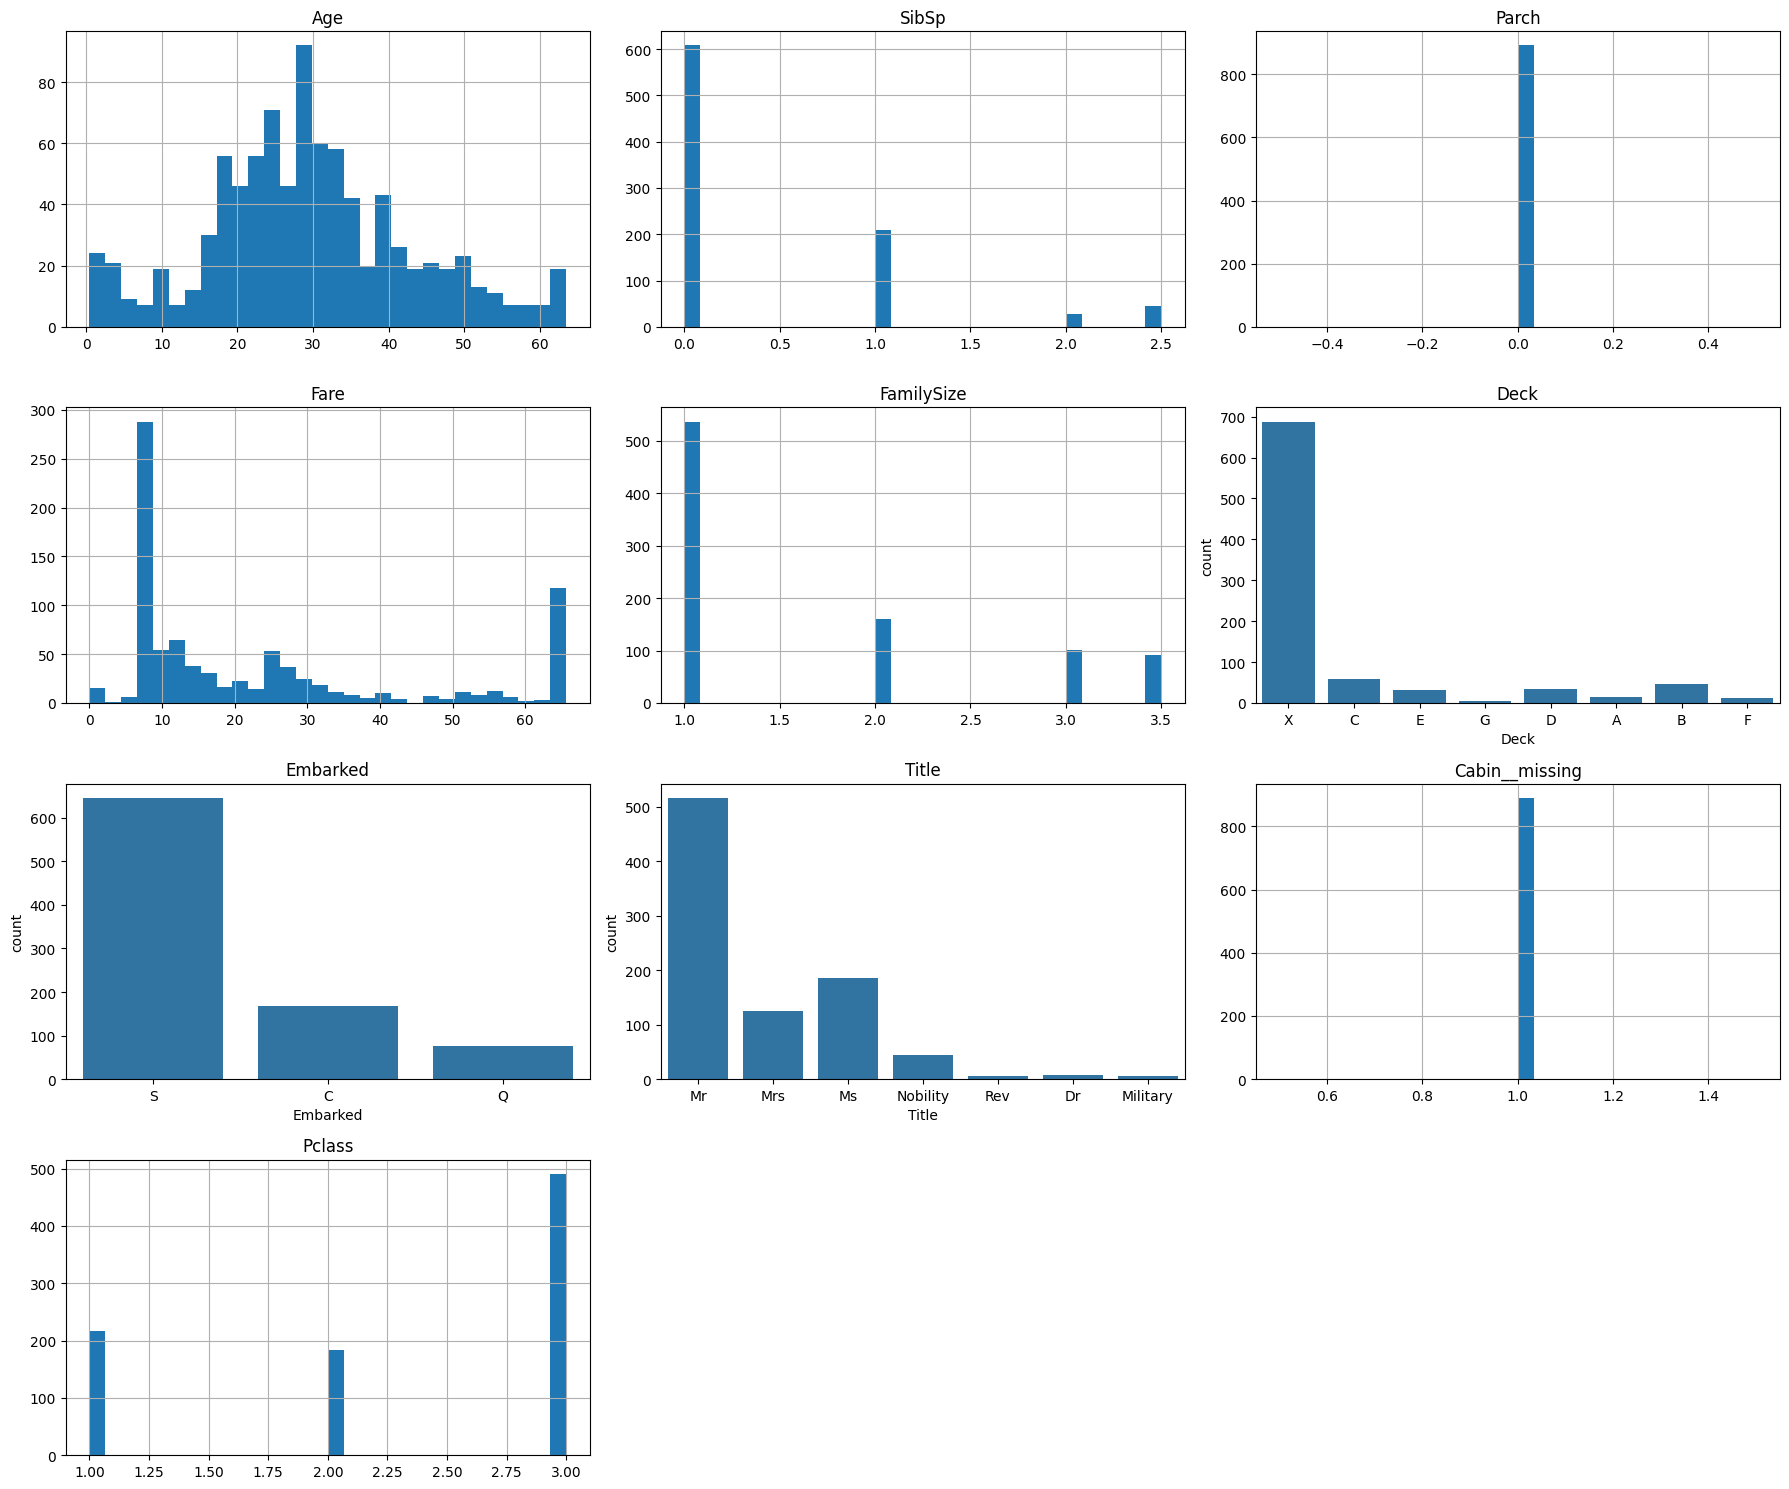

In [129]:
cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "Deck", "Embarked", "Title", "Cabin__missing", "Pclass"]
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if temp_df_trimmed[col].dtype == "object":
        sns.countplot(x=col, data=temp_df_trimmed, ax=ax)
    else:
        temp_df_trimmed[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Veiem que els resultats no son els esperats. De la columna `Cabin__missing` no volem perdre tota la informació que tenim (que seria posar que tots tenen cabin), per tant, per cada columna farem un tractament diferent:

- `Age`: agafarem un threshold aproximat de 65
- `Parch` i `SibSp`: limitarem a 0, 1 o 2 (considerant 2 com 2 o més)
- `FamilySize`: limitarem a 1, 2, 3 i 4 (considerant 4 com 4 o més)
- `Fare`: limitarem al preu aproximate de 100

Deixarem les altres variables com estan.

In [130]:
def custom_threshold(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Age: threshold a 65
    if "Age" in dataframe.columns:
        dataframe["Age"] = np.where(dataframe["Age"] > 65, 65, dataframe["Age"])

    # Parch i SibSp: màxim 2
    for col in ["Parch", "SibSp"]:
        if col in dataframe.columns:
            dataframe[col] = np.where(dataframe[col] > 2, 2, dataframe[col])

    # FamilySize: màxim 4
    if "FamilySize" in dataframe.columns:
        dataframe["FamilySize"] = np.where(dataframe["FamilySize"] > 4, 4, dataframe["FamilySize"])

    # Fare: threshold a 100
    if "Fare" in dataframe.columns:
        dataframe["Fare"] = np.where(dataframe["Fare"] > 100, 100, dataframe["Fare"])

    return dataframe

custom_threshold_transformer = FunctionTransformer(custom_threshold, validate=False)
temp_df_threshold = custom_threshold_transformer.transform(temp_df)

Analitzem les noves distribucions.

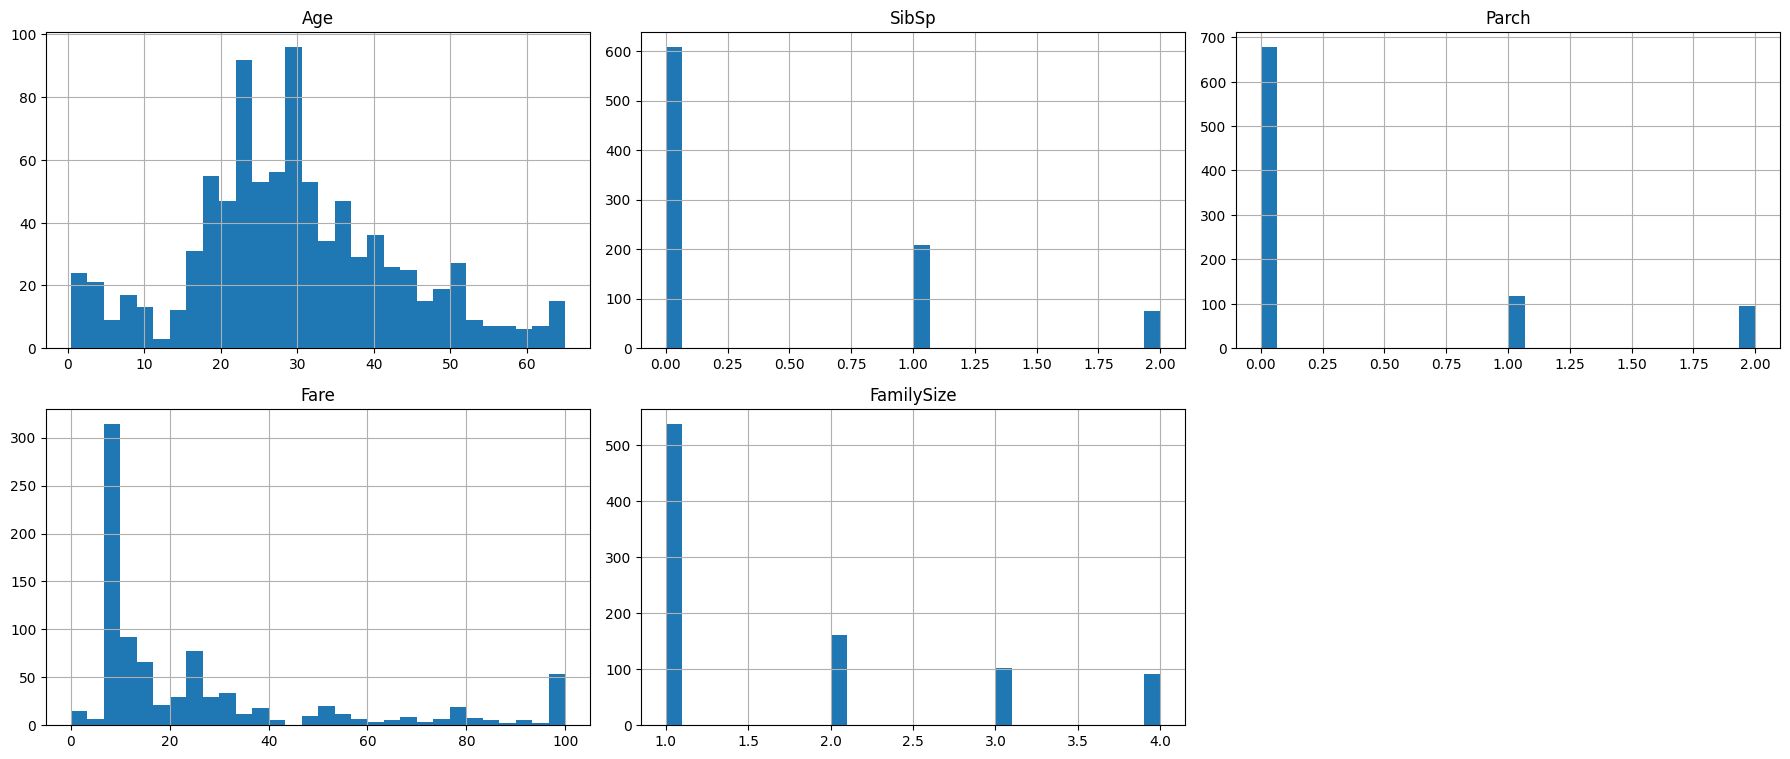

In [131]:
cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize"]
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if temp_df_threshold[col].dtype == "object":
        sns.countplot(x=col, data=temp_df_threshold, ax=ax)
    else:
        temp_df_threshold[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Considerem que les noves distribucions tenen sentit, així que les deixarem per la versió final del dataframe.

Els models d'aprenentatge que farem servir només entenen atributs numèrics, així que ens hem de desfer dels que no ho son. Els categòrics (`Sex`, `Embarked`, `Title`, `Deck`) els podrem passar a binaris (també s'accepten com a 0 o 1), així que aquests els deixem. De la columna `Name` ja no en traurem més profit a part del `Title`, així que decidim esborrar aquesta columna del dataset final. Passa igual amb la cabina, ja li hem extret el `Deck` i no podem fer servir cap més informació a part d'aquesta, la decidim esborrar també.

In [132]:
def normalize_numerics(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    num_cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "Pclass"]
    df_num = df[num_cols].copy()
    for col in num_cols:
        mean = df_num[col].mean()
        std = df_num[col].std()
        df_num[col] = (df_num[col] - mean) / std if std != 0 else 0
    other_cols = df.drop(columns=num_cols)
    df_final = pd.concat([df_num, other_cols], axis=1)
    return df_final

normalize_numerics_transformer = FunctionTransformer(normalize_numerics, validate=False)
normalized_df = normalize_numerics_transformer.fit_transform(temp_df_threshold)

def encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    cat_cols = ["Sex", "Embarked", "Deck", "Title"]
    df_encoded = pd.get_dummies(df[cat_cols], drop_first=True, dummy_na=False)
    other_cols = df.drop(columns=cat_cols)
    df_final = pd.concat([df_encoded, other_cols], axis=1)
    return df_final

encode_categoricals_transformer = FunctionTransformer(encode_categoricals, validate=False)
encoded_df = encode_categoricals_transformer.fit_transform(normalized_df)

Podem observar les dades normalitzades.

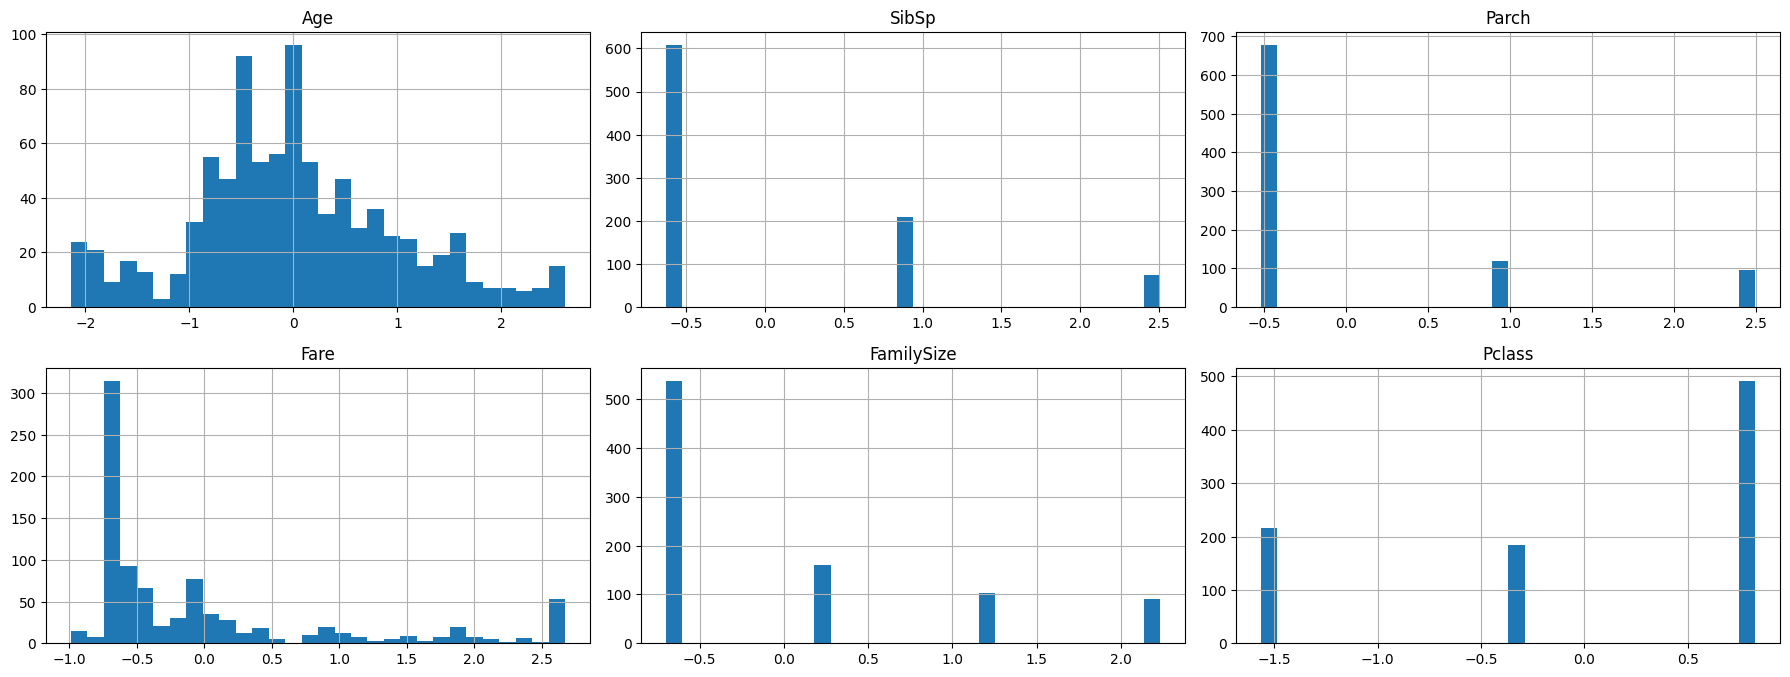

In [133]:
cols = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "Pclass"]
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if normalized_df[col].dtype == "object":
        sns.countplot(x=col, data=normalized_df, ax=ax)
    else:
        normalized_df[col].hist(bins=30, ax=ax)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Fem un transformer ràpid per eliminar les columnes.

In [134]:
def drop_column(dataframe, columns):
    # Copiar el dataframe
    dataframe = dataframe.copy()

    # Esborrar les columnes
    return dataframe.drop(columns=columns, errors="ignore")

drop_cols = {"columns": ["Name", "Cabin", "Ticket"]}

drop_transformer = FunctionTransformer(drop_column, kw_args=drop_cols, validate=False)

Finalment, construïm el pipeline final amb totes les implementacions que hem fet.

In [135]:
preprocessor = Pipeline(steps=[
    ("extract_deck", extract_deck_transformer),
    ("missing_cabin", indicate_missing_cabin_transformer),
    ("impute_embarked", impute_embarked_transformer),
    ("extract_title", extract_title_transformer),
    ("add_family_size", add_family_size_transformer),
    ("impute_age", AgeKNNImputer()),
    ("compress_title", compress_title_transformer),
    ("custom_threshold", custom_threshold_transformer),
    ("normalize", normalize_numerics_transformer),
    ("encode", encode_categoricals_transformer),
    ("drop", drop_transformer),
])

Apliquem aquest pipeline al dataframe per comprovar que funciona correctament.

In [136]:
processed_df = preprocessor.fit_transform(df)
DATAFRAME = processed_df
display(processed_df)
display(processed_df.columns)

,Sex_male,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X,...,Title_Rev,Age,SibSp,Parch,Fare,FamilySize,Pclass,PassengerId,Survived,Cabin__missing
0,True,False,True,False,False,False,False,False,False,True,...,False,-0.550650,0.939785,-0.521177,-0.724528,0.277604,0.826913,1,0,1
1,False,False,False,False,True,False,False,False,False,False,...,False,0.626671,0.939785,-0.521177,1.621304,0.277604,-1.565228,2,1,0
2,False,False,True,False,False,False,False,False,False,True,...,False,-0.256320,-0.628283,-0.521177,-0.699799,-0.700045,0.826913,3,1,1
3,False,False,True,False,True,False,False,False,False,False,...,False,0.405923,0.939785,-0.521177,0.955167,0.277604,-1.565228,4,1,0
4,True,False,True,False,False,False,False,False,False,True,...,False,0.405923,-0.628283,-0.521177,-0.695220,-0.700045,0.826913,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,True,False,True,False,False,False,False,False,False,True,...,True,-0.182737,-0.628283,-0.521177,-0.513879,-0.700045,-0.369158,887,0,1
887,False,False,True,True,False,False,False,False,False,False,...,False,-0.771398,-0.628283,-0.521177,0.108908,-0.700045,-1.565228,888,1,0
888,False,False,True,False,False,False,False,False,False,True,...,False,-1.507224,0.939785,2.494203,-0.131048,2.232901,0.826913,889,0,1
889,True,False,False,False,True,False,False,False,False,False,...,False,-0.256320,-0.628283,-0.521177,0.108908,-0.700045,-1.565228,890,1,0


Index(['Sex_male', 'Embarked_Q', 'Embarked_S', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_X', 'Title_Military', 'Title_Mr',
       'Title_Mrs', 'Title_Ms', 'Title_Nobility', 'Title_Rev', 'Age', 'SibSp',
       'Parch', 'Fare', 'FamilySize', 'Pclass', 'PassengerId', 'Survived',
       'Cabin__missing'],
      dtype='object')

Per raons que es veuran a validació creuada, també necessitem el dataframe sense normalitzar, per tant, copiem el pipeline sense l'estandarització:

In [137]:
preprocessor_unnormalized = Pipeline(steps=[
    ("extract_deck", extract_deck_transformer),
    ("missing_cabin", indicate_missing_cabin_transformer),
    ("impute_embarked", impute_embarked_transformer),
    ("extract_title", extract_title_transformer),
    ("add_family_size", add_family_size_transformer),
    ("impute_age", AgeKNNImputer()),
    ("compress_title", compress_title_transformer),
    ("custom_threshold", custom_threshold_transformer),
    ("encode", encode_categoricals_transformer),
    ("drop", drop_transformer),
])

processed_df_unnormalized = preprocessor_unnormalized.fit_transform(df)
DATAFRAME_UNNORMALIZED = processed_df_unnormalized

I no obtenim cap cel·la sense valors.

In [138]:
processed_df.isna().sum().sum()

np.int64(0)

Per acabar aquesta secció comentarem dues coses importants: PCA i normalització.

La primera: Primary Component Analysis. La utilitat principal d'aquest mètode és reduir la dimensionalitat d'un problema si aquest és molt gran o si pensem que hi ha dimensions que no aporten informació a la predicció. En el nostre cas, no es dona cap de les situacions. La dimensió és relativament petita, i a priori pensem que totes les variables son importants. A més, tenim una explicació molt fàcil i interpretació directa a partir de les quantitats. Aplicar PCA es carregaria aquesta interpretabilitat, potser augmentant lleugerament el temps de còmput (un cop entrenat), però perdrem un gran part del problema que és la interpretació de les dades, bàsicament el treball que hem estat fent en aquestes dues seccions.

La segona: Normalització. Quan estem treballant amb algoritmes que fan servir distàncies, és normal aplicar una normalització a tots els atributs per així no donar prioritat a les magnituds que potser simplement estan en una altra escala. Per evitar això, normalment s'agafen totes les dades i se les aplica una transformació lineal per centrar-les al zero i amb variació 1. Aquesta és la Standard, la més normal. També hi ha la MinMax, que porta tot el rang de valor a un altre interval desitjat. Com estem treballant amb pipelines i ja tenim funcions implementades per fer aquestes normalitzacions, és molt fàcil afegir o treure-les quan vulguem. Sabem que per alguns mètodes està bé conservar la magnitud (en general és igual), així que, de moment, deixarem les dades amb les magnituds reals i després, per cada model, afegirem una línia que aplicarà la normalització abans.

### 3. Metric selection (1.5 punts)
En aquest apartat ens centrarem en les mètriques de classificació ([documentació](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). Per a fer-ho, entreneu una regressio logistica i a partir d'aquesta generarem una serie de funcions per analitzar els nostres resultats. Aquestes funcions ens serviran més endavant. Caldrà tambe triar la mètrica que farem servir després per triar el millor model.

**Preguntes:**
* A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`?
* Abans de començar a entrenar models, genereu una suite de funcions per poder analitzar graficament com esta anant el vostre model. Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset?
* Què mostra [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)? Quina mètrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?

**Nota**: Fixeu-vos que en aquest apartat NO ES VALOREN ELS RESULTATS. L'únic que es valora és l'elecció de la mètrica de classificació així com saber quin tipus de gràfiques fer per analitzar els resultats. Abans de solucionar un problema cal tenir molt clar la mètrica d'error que es farà servir, i és una decisió que cal pendre de forma prèvia a entrenar models.

- Accuracy: Percentatge de prediccions correctes sobre el total.
- Precision: Proporció de prediccions positives que són realment positives (TP / (TP + FP)).
- Recall (True Positive Rate, TPR): Proporció de positius reals que el model detecta respecte a la realitat de positius (TP / (TP + FN)).
- F1-score: Mitjana harmònica entre precision i recall (equilibri).
- Precision-Recall Curve: Gràfic que mostra com canvien precision i recall segons el llindar.
    - Eixos: X = Recall, Y = Precision
    - Mostra trade-off entre detectar positius i evitar falsos positius.
    - Cada punt = un llindar diferent.
    - Molt útil amb classes desequilibrades.
    - Àrea sota corba = Average Precision (AP)
- ROC Curve: Gràfic de True Positive Rate (Recall) vs False Positive Rate a diferents llindars, per cada llindar, es calcula TPR i FPR.
    - Eixos: X = FPR (False Positive Rate), Y = TPR (Recall)
    - Mostra com canvia TPR respecte a FPR segons el llindar.
    - Cada punt = un llindar diferent.
    - Útil amb classes equilibrades.
    - Àrea sota corba = ROC-AUC (mesura la capacitat de separar positives i negatives).
- Threshold en la gràfica: Valor de decisió per classificar una mostra com positiva si la probabilitat estimada és superior o igual a aquest llindar, així havent-hi a la gràfica tants punts com thresholds. Per tant, si tinguéssim una mica menys de probabilitat, per aquell threshold, la mostra es classificaria com negativa. I fixat si fixéssim el threshold una mica menor, obtindríem un punt diferent de la gràfica associat a aquest nou threshold.

In [139]:
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv  # needed for HalvingGridSearchCV 
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

In [140]:
X = processed_df[[col for col in processed_df.columns if col != "Survived"]]
y = processed_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Prediccions
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"\nResultats amb el model base:")
print(f"   • Accuracy Score:          {accuracy:.4f}")
print(f"   • F1 Score:                {f1:.4f}")
print(f"   • Average Precision Score: {avg_precision:.4f}")

print(classification_report(y_test, y_pred))


Resultats amb el model base:
   • Accuracy Score:          0.7989
   • F1 Score:                0.7500
   • Average Precision Score: 0.7941
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       106
           1       0.76      0.74      0.75        73

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



El classification_report mostra diverses mètriques per cada classe i globalment:
- Precision: de totes les prediccions positives, quantes són correctes.
  Exemple: Sobreviu precision = 0.77 → del total de prediccions “Sobreviu”, el 77% són correctes.
- Recall (sensibilitat): de tots els positius reals, quants detectem.
  Exemple: Sobreviu recall = 0.74 → detectem el 74% dels supervivents reals.
- F1-score: mitjana harmònica de precision i recall, equilibra detectar positius sense generar massa falsos positius.
  Exemple: Sobreviu F1 = 0.76 → resumeix el rendiment sobre aquesta classe minoritària.
- Support: nombre de mostres reals d’aquesta classe. Exemple: 69 supervivents.
- Accuracy: proporció total de prediccions correctes (0.82).
- Macro avg: mitjana simple de les mètriques per classe.
- Weighted avg: mitjana ponderada pel nombre de mostres de cada classe.

Amb el model entrenat, podem avaluar les mètriques en qüestió, però no podem escollir quines mètriques són més adequades sense conèixer la distribució de les classes en el dataset, i què es vol prioritzar.

In [141]:
class_distribution = y.value_counts(normalize=True)
majority_class = class_distribution.max()
minority_class = class_distribution.min()
imbalance_ratio = majority_class / minority_class

print(f"Distribució de classes:")
print(f"   Classe 0 (No sobreviu): {class_distribution[0]:.2%}")
print(f"   Classe 1 (Sobreviu):    {class_distribution[1]:.2%}")
print(f"\nRàtio de desequilibri: {imbalance_ratio:.2f}:1")

Distribució de classes:
   Classe 0 (No sobreviu): 61.62%
   Classe 1 (Sobreviu):    38.38%

Ràtio de desequilibri: 1.61:1


Amb un ràtio de 1.61:1, el dataset NO està severament desequilibrat, però SÍ té un biaix cap a la classe majoritària (No sobreviu, 0). Això afectarà la selecció de mètriques de la següent manera:

1. Accuracy: Pot ser enganyosa en datasets desequilibrats.
   Al Titanic, encara que no és extremadament desequilibrat, hi ha més morts que supervivents.
   Així que un model que prediu gairebé sempre "mor" tindria bona accuracy, però seria inútil per detectar els supervivents. Per això no l'hem triada.

2. Precision i Recall: Són més informatives per avaluar el rendiment en la classe minoritària ("Sobreviu", 1).
   - Precision mira quants dels supervivents predits realment sobreviuen (minimitzar falsos positius).
   - Recall mira quants dels supervivents reals hem detectat (minimitzar falsos negatius).
   Per comparar models cal un equilibri entre ambdues, així que tampoc les hem triades soles.

3. Average Precision Score: Resumeix tota la Precision-Recall curve.
   És més útil quan el model retorna probabilitats i hi ha molts casos positius escassos.
   En aquest cas, com les classes no són extremadament desequilibrades i volem un valor senzill per comparar models, no l’hem triada.

4. ROC-AUC ((X,Y)=(FPR,TPR)): També resumeix la capacitat del model per separar classes.
   Però és menys informativa que la Precision-Recall curve en casos desequilibrats, ja que pot donar una falsa sensació de bon rendiment quan hi ha molts negatius, ja que el FPR = FP / FP + TN pot ser baix simplement perquè hi ha molts negatius i per tant, TN.

5. F1-score: Combina Precision i Recall en una mitjana harmònica, equilibrant la capacitat de detectar supervivents (recall) i no predir falsament supervivents (precision). Per això, hem triat l'F1-score com a mètrica principal per avaluar els models.

Sabent això, generem la suite de funcions per visualització a continuació.

Primer, generem una classe *wrapper* per tots els models d'aprenentatge. D'aquesta manera, podem afegir funcionalitat que ens interessa per aquesta pràctica.

In [142]:
class Model:
    def __init__(self,
                 model_class = None,
                 dataframe: pd.DataFrame = None,
                 hyperparameters: dict = None,
                 **kwargs
                 ):

        self.model_class     = model_class
        self.dataframe       = dataframe
        self.hyperparameters = hyperparameters or {}

        self.explanatory     = kwargs.get("explanatory", "Survived")
        self.test_size       = kwargs.get("test_size", 0.2)
        self.random_state    = kwargs.get("random_state", 1)
        self.name            = kwargs.get("name", model_class.__name__)

        self.X = dataframe.drop(self.explanatory, axis=1)
        self.y = dataframe[self.explanatory]

        self.update_dataset(
            test_size=self.test_size,
            random_state=self.random_state
        )

        self.pca = None

        self.model = None
        self.y_pred = None
        self.y_pred_probs = None
        self.metrics = {}
        self.valid_pred = False

        self.search_results_ = None

    def update_dataset(self, test_size: float = None, random_state: int = None, features: list = None, pca: int = -1):
        if test_size is not None:
            self.test_size = test_size
        if random_state is not None:
            self.random_state = random_state

        self.pca = None

        self.X = self.dataframe.drop(self.explanatory, axis=1)
        self.y = self.dataframe[self.explanatory]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state)

        if features is not None:
            # Reduir el dataframe a les columnes indicades
            self.pca = None
            self.X = self.X[features]
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state)
        elif pca != -1:
            # Aplicar PCA al training i després convertir el testing a aquelles dimensions
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state)
            self.pca = PCA(n_components=pca)
            self.pca.fit(self.X_train)
            self.X_train = pd.DataFrame(self.pca.transform(self.X_train), columns=[f"PC{i+1}" for i in range(pca)])
            self.X_test = pd.DataFrame(self.pca.transform(self.X_test), columns=[f"PC{i+1}" for i in range(pca)])

        self.fit()

        return self

    def fit(self):
        self.model = self.model_class(**self.hyperparameters)
        self.model.fit(self.X_train, self.y_train)

        self.valid_pred = False

        return self

    def predict(self, threshold=0.5):
        if self.model is None:
            self.fit()

        if hasattr(self.model, "predict_proba"):
            self.y_pred_probs = self.model.predict_proba(self.X_test)[:,1]
            self.y_pred = (self.y_pred_probs >= threshold).astype(int)
        else:
            self.y_pred = self.model.predict(self.X_test)
            self.y_pred_probs = self.y_pred

        self.valid_pred = True

        return self.y_pred

Amb l'estructura d'aquesta classe, ja podem implementar les mètriques que volem amb classes *Helper*.

Per les mètriques:

In [143]:
ACCURACY = "Accuracy"
PRECISION = "Precision"
RECALL = "Recall"
F1 = "F1"
AUC_ROC = "AUC-ROC"
AUC_PR = "AUC_PR"

In [144]:
class Metrics:
    @staticmethod
    def evaluate(model: Model):
        if not model.valid_pred:
            model.predict()
        model.metrics = {
            ACCURACY: accuracy_score(model.y_test, model.y_pred),
            PRECISION: precision_score(model.y_test, model.y_pred),
            RECALL: recall_score(model.y_test, model.y_pred),
            F1: f1_score(model.y_test, model.y_pred),
            AUC_ROC: roc_auc_score(model.y_test, model.y_pred_probs),
            AUC_PR: average_precision_score(model.y_test, model.y_pred_probs),
        }
        return model.metrics

    @staticmethod
    def confusion_matrix(model: Model):
        return confusion_matrix(model.y_test, model.y_pred)

    @staticmethod
    def summary(model: Model):
        if not model.metrics:
            Metrics.evaluate(model)
        for k, v in model.metrics.items():
            print(f"{k:12s}: {v:.4f}")

I per les gràfiques:

In [145]:
class Plotter:
    @staticmethod
    def plot_roc(model: Model, plot_ax=None):
        if not model.valid_pred:
            model.predict()
        if not model.metrics:
            Metrics.evaluate(model)
        if plot_ax is None:
            _, plot_ax = plt.subplots()

        auc = model.metrics.get(AUC_ROC, None)
        title = f"{model.name}: ROC Curve (AUC: {auc:.4f})"

        fpr, tpr, _ = roc_curve(model.y_test, model.y_pred_probs)

        plot_ax.plot(fpr, tpr, color="darkorange", lw=2)
        plot_ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plot_ax.set_xlabel("False Positive Rate")
        plot_ax.set_ylabel("True Positive Rate")
        plot_ax.set_title(title)

    @staticmethod
    def plot_pr(model: Model, plot_ax=None):
        if not model.valid_pred:
            model.predict()
        if not model.metrics:
            Metrics.evaluate(model)
        if plot_ax is None:
            _, plot_ax = plt.subplots()

        auc = model.metrics.get(AUC_PR, None)
        title = f"{model.name}: Precision-Recall Curve (AUC: {auc:.4f})"

        prec, recall, _ = precision_recall_curve(model.y_test, model.y_pred_probs)
        base = np.mean(model.y_test)

        plot_ax.plot(recall, prec, color="darkorange", lw=2)
        plot_ax.plot([0, 1], [base, base], color="navy", lw=2, linestyle="--")
        plot_ax.set_xlabel("Recall")
        plot_ax.set_ylabel("Precision")
        plot_ax.set_title(title)

    @staticmethod
    def plot_confusion_matrix(model: Model, plot_ax=None):
        if not model.valid_pred:
            model.predict()
        if plot_ax is None:
            _, plot_ax = plt.subplots()

        title = f"{model.name}: Confusion Matrix"
        cm = confusion_matrix(model.y_test, model.y_pred)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=plot_ax, cmap="Blues", values_format="d")
        plot_ax.set_title(title)

    @staticmethod
    def plot_decision_boundary(model: Model, plot_ax=None, features: list = None, pca: bool = False):
        if not model.valid_pred:
            model.predict()

        X = model.X_test.values
        y = model.y_test
        feature_names = model.X_test.columns

        if features is not None and len(features) == 2:
            i, j = feature_names.get_loc(features[0]), feature_names.get_loc(features[1])
            X_vis = X[:, [i, j]]
            xlabel, ylabel = feature_names[i], feature_names[j]
        elif pca:
            from sklearn.decomposition import PCA
            pca_model = PCA(n_components=2)
            X_vis = pca_model.fit_transform(X)
            xlabel, ylabel = "PC1", "PC2"
            i, j = None, None
        else:
            if X.shape[1] > 2:
                print(f"Data has {X.shape[1]} dimensions. Indicate 'features=[...]' or 'pca=2' to reduce to 2D visualization.")
                return None
            X_vis = X
            xlabel, ylabel = feature_names[0], feature_names[1]
            i, j = 0, 1

        if plot_ax is None:
            _, plot_ax = plt.subplots(figsize=(7, 5))

        f1 = Metrics.evaluate(model)[F1]
        title = f"{model.name}: Decision Boundary (F1: {f1:.4f})"

        h = 0.02
        x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
        y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        X_mean = model.X_test.mean().values
        X_grid = np.tile(X_mean, (xx.size, 1))

        if pca:
            grid_proj = pca_model.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
            Z = model.model.predict(grid_proj)
        else:
            X_grid[:, i] = xx.ravel()
            X_grid[:, j] = yy.ravel()
            Z = model.model.predict(X_grid)

        Z = Z.reshape(xx.shape)

        plot_ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        plot_ax.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], c="blue", edgecolors="k", label="Didn't Survive")
        plot_ax.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], c="red", edgecolors="k", label="Survived")

        plot_ax.set_xlabel(xlabel)
        plot_ax.set_ylabel(ylabel)
        plot_ax.set_title(title)
        plot_ax.legend()

Amb aquest codi podem generar les gràfiques i mètriques per avaluar el model entrenat. Ara bé, per què ens interessen aquestes gràfiques si ja tenim la mètrica que ens interessa?

La mètrica F1 depèn del llindar de classificació i el que normalment fem és provar diversos llindars per trobar aquell que maximitza el F1; per tant, el F1 “màxim” és el millor que podem aconseguir canviant el llindar. En canvi, les mètriques globals com l’AUC-ROC i l’Average Precision (AP) no depenen d’un llindar concret, sinó que mesuren la qualitat del model a través de tots els llindars possibles, oferint una visió completa del rendiment. Així ajuda a entendre com de bo és el model globalment i a triar un llindar òptim, evitant conclusions enganyoses que podrien sorgir si només et fixes en un llindar fix.

In [146]:
log_model = Model(
    model_class=LogisticRegression,
    dataframe=DATAFRAME,
    hyperparameters={"max_iter":1000}
)

Metrics.summary(log_model)

Accuracy    : 0.7989
Precision   : 0.7606
Recall      : 0.7397
F1          : 0.7500
AUC-ROC     : 0.8230
AUC_PR      : 0.7941


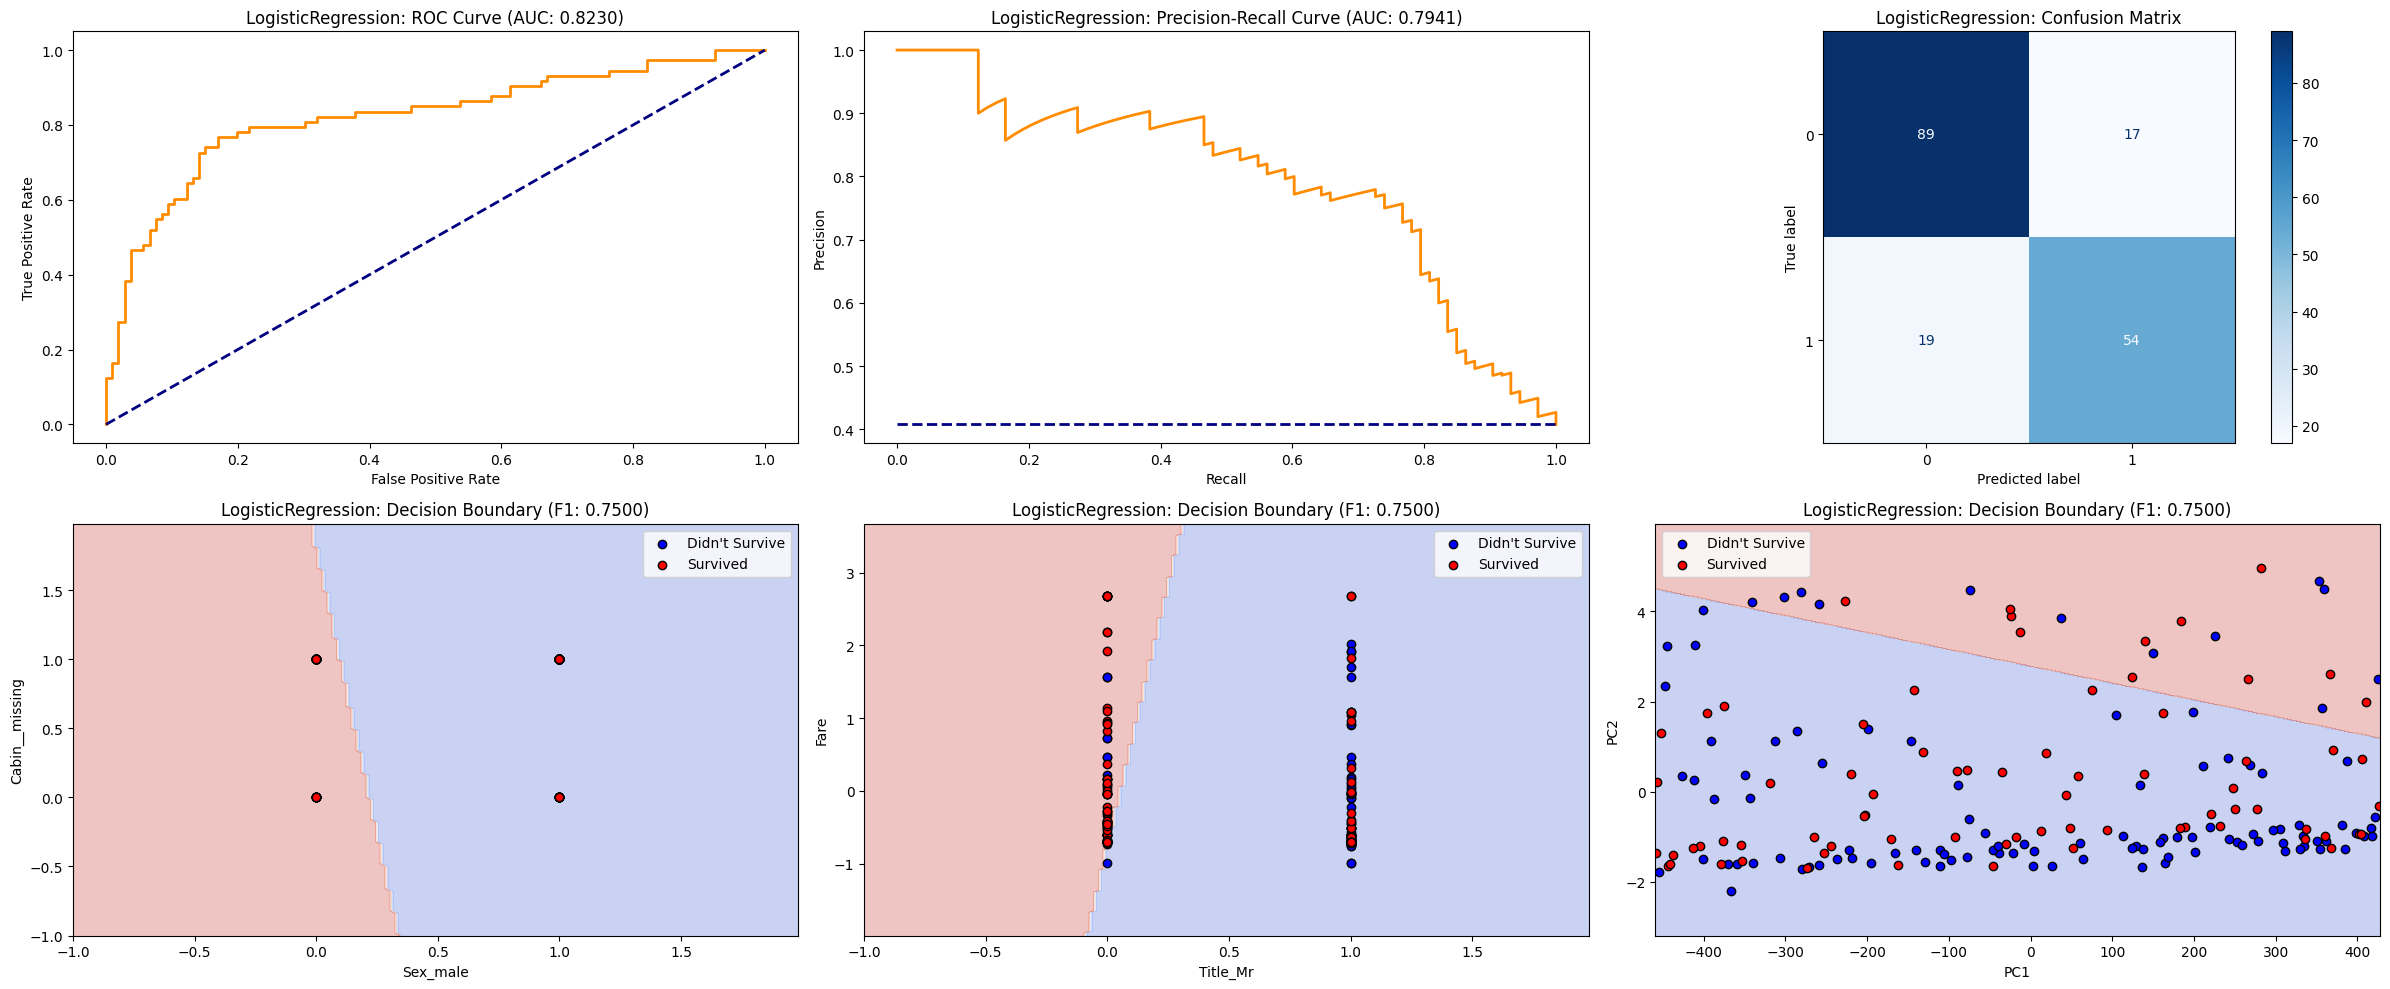

In [147]:
fig, axes = plt.subplots(2, 3, figsize=(24, 10))
axes_iter = iter(axes.flatten())

Plotter.plot_roc(log_model, plot_ax=next(axes_iter))
Plotter.plot_pr(log_model, plot_ax=next(axes_iter))
Plotter.plot_confusion_matrix(log_model, plot_ax=next(axes_iter))
Plotter.plot_decision_boundary(log_model, features=["Sex_male", "Cabin__missing"], plot_ax=next(axes_iter))
Plotter.plot_decision_boundary(log_model, features=["Title_Mr", "Fare"], plot_ax=next(axes_iter))
Plotter.plot_decision_boundary(log_model, pca=True, plot_ax=next(axes_iter))

plt.tight_layout()

En termes pràctics i morals, ens interessa prioritzar el recall de la classe positiva (Sobreviu),
ja que volem minimitzar falsos negatius i no deixar fora persones que realment sobreviuen.
És a dir, optem per prioritzar en detectar tots els supervivents i ajustem el threshold si cal (baixant-lo,
acceptant alguns FP per maximitzar la seguretat moral del nostre model abans que trobar-nos més FN.

Per optimitzar la classificació del nostre cas, ens fixem especialment en:
- Recall de la classe positiva → captar la majoria de supervivents.
- Average Precision / F1-score → equilibrar que no hi hagi massa falsos positius.

### 4. Model Selection amb validació creuada (4 punts)

Fent servir la mètrica trobada en l'apartat anterior, en aquest apartat caldrà seleccionar una sèrie de models i, fent ús de la validació creuada, seleccionar el millor model amb els seus respectius millors hyperpàrametres que haurem buscat fent hyperparameter search.

La tasca d'aquesta pràctica s'enmarca dins l'aprenentatge computacional **supervisat**. A sklearn, disposem de diverses tècniques [(veure documentació)](https://scikit-learn.org/stable/supervised_learning.html). A les classes de teoria, hem vist tècniques com ara logistic regression, SVM amb diferents kernels, Nearest Neighbour... i també coneixeu altres tecniques d'altres cursos, com els arbres de decisio. Per aquest apartat es demana seleccionar **un minim de 3 models**.

**Preguntes:**
* Quins models heu considerat? Per què els heu seleccionat?
* Fent servir validació creuada, escolliu el millor model (agafant els hiperparàmetres per defecte). Recordeu fer servir la mètrica utilitzada en l'apartat anterior i fer fer servir algun [tipus de validacio creuada](https://scikit-learn.org/stable/modules/cross_validation.html).

* Seleccioneu una sèrie d'hiperparàmetres a provar per cadascun dels models i realitzeu una cerca d'hiperparàmetres. Hi ha algun model que creieu que podeu descartar de primeres? Per què?

* Mostreu els resultats en una taula on es mostri el model, els experiments realitzats i els resultats obtinguts (tant en train com en test). Podeu mostrar tambe el temps d'entrenament de cada model.

* Quin tipus de validació heu escollit en la selecció de models?

* Quines formes de buscar els millors hiperparàmetres heu trobat? Són costoses computacionalment parlant? [documentació](https://scikit-learn.org/stable/modules/grid_search.html). Quina heu seleccionat?

* Si disposem de recursos limitats (per exemple, un PC durant 1 hora), quin dels mètodes creieu que obtindrà millor resultat final?

* Opcional: Feu la prova, i amb el model i el metode de validació creuada escollit, configureu els diferents mètodes de cerca per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (Ajuda: estimeu el temps que trigarà a fer 1 training el vostre model, i així trobeu el número de intents que podeu fer en cada cas.)

#### Models

Comencem aquesta secció parlant sobre els models que entrenarem, farem servir i compararem en aquesta pràctica. Entre els models que ja coneixíem i els que hem vist per internet, hem arribat a la següent llista d'un total del 12. Semblen molts, però ja veurem que no tots ens serveixen per aquest dataset, i molts d'ells no tindràn un bon rendiment (perquè no estan dissenyats per aquest tipus de dades). Aquests son:

- **Logistic Regression**: Model lineal que estima la probabilitat d’una classe amb la funció logística; s’utilitza per classificació binària.
- **KNN (K-Nearest Neighbors)**: Classifica segons les etiquetes dels k veïns més propers en l’espai de característiques.
- **Gradient Descent (SGDClassifier)**: Optimitza models lineals amb descens de gradient estocàstic; admet diferents funcions de pèrdua com hinge o log.
- **Random Forest**: Conjunt d’arbres de decisió entrenats sobre mostres aleatòries; utilitza vot majoritari per a predicció.
- **Extra Trees**: Similar a Random Forest però amb més aleatorietat en la selecció dels punts de tall dels arbres.
- **Support Vector Machine (SVC)**: Troba l’hiperplà que separa classes amb marge màxim; pot usar diferents nuclis (linear, RBF).
- **LinearSVC**: Versió de SVM lineal optimitzada per velocitat; només separació lineal.
- **Gradient Boosting**: Combina arbres febles seqüencialment, corregint errors dels arbres previs; bon rendiment amb dades tabulars.
- **Naive Bayes (GaussianNB)**: Classificador probabilístic basat en Bayes amb supòsit d’independència entre característiques.
- **Perceptron**: Model lineal senzill que actualitza pesos segons errors de classificació; pot entrenar ràpidament.
- **Passive Aggressive**: Model lineal que només actualitza pesos quan comet errors; útil per dades cotínues en temps real.
- **Neural Network (MLPClassifier)**: Xarxa neuronal amb capes ocultes; pot modelar relacions no lineals complexes.

Importem, anomanem i creem un diccionari amb la classe de cada model.

In [148]:
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

LOGISTIC_REGRESSION = "Logistic Regression"
KNN = "KNN"
GRADIENT_DESCENT = "Gradient Descent"
RANDOM_FOREST = "Random Forest"
EXTRA_TREES = "Extra Trees"
SUPPORT_VECTOR_MACHINE = "Support Vector Machine"
LINEAR_SVC = "LinearSVC"
GRADIENT_BOOSTING = "Gradient Boosting"
NAIVE_BAYES = "Naive Bayes"
PERCEPTRON = "Perceptron"
PASSIVE_AGGRESSIVE = "Passive Aggressive"
NEURAL_NETWORK = "Neural Network"

MODELS = {
    LOGISTIC_REGRESSION: LogisticRegression,
    KNN: KNeighborsClassifier,
    GRADIENT_DESCENT: SGDClassifier,
    RANDOM_FOREST: RandomForestClassifier,
    EXTRA_TREES: ExtraTreesClassifier,
    SUPPORT_VECTOR_MACHINE: SVC,
    LINEAR_SVC: LinearSVC,
    GRADIENT_BOOSTING: GradientBoostingClassifier,
    NAIVE_BAYES: GaussianNB,
    PERCEPTRON: Perceptron,
    PASSIVE_AGGRESSIVE: PassiveAggressiveClassifier,
    NEURAL_NETWORK: MLPClassifier
}

#### Validació Creuada

Un cop sabem els models que hem de comparar, anem a veure com implementarem la validació creuada per verificar-los.

Hi ha diferents tipus, per aquesta pràctica hem emprat els següents:

- `KFold`: Divideix les dades en **n blocs iguals** i fa **cross-validation** entrenant en n-1 blocs i testant en el bloc restant, sense tenir en compte les distribucions de classes.
- `StratifiedKFold`: Igual que `KFold`, però **manté la proporció de classes** en cada bloc. Ideal per problemes de classificació amb classes desbalancejades.
- `RepeatedStratifiedKFold`: Repeteix `StratifiedKFold` diverses vegades amb diferents partitions, millorant l’estabilitat de les mètriques i reduint la variància de l’avaluació.
- `ShuffleSplit`: Genera **submostres aleatòries** per a train/test múltiples vegades; cada vegada es selecciona un subconjunt aleatori per entrenament i un per test.

Per acabar, farem servir `cross_validate`, funció que executa la cross-validation amb qualsevol dels validators anteriors, retornant mètriques de **train i test**, així com temps d’entrenament i avaluació.

Com abans, definim tots els validators necessaris.

In [149]:
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    ShuffleSplit,
    RepeatedStratifiedKFold,
    cross_validate
)

KFOLD = "K-Fold"
STRATIFIED = "Stratified K-Fold"
REPEATED = "Repeated Stratified K-Fold"
SHUFFLE = "Shuffle & Split"

CROSS_VALIDATORS = [
    KFOLD,
    STRATIFIED,
    REPEATED,
    SHUFFLE,
]

Per simplificar el procés de validació i adaptar-lo a les nostres necessitats, creem una classe `CValidator` per automatitzar aquest procés. Simplement rep el model i el tipus de validació, i retorn un dataframe amb un resum dels resultats.

Un camp que afegim és `overfit_gap`. Aquest és simplement la resta entre les mitjanes de `train_score` i `test_scoe`, d'aquesta manera pensem que podem quantificar l'overfit: si la diferència és molt gran vol dir que el model va molt bé amb les dades d'entrenament (les ha memoritzat), però no generalitza bé. Si aquest coeficient és petit, vol dir que el model ha après els patrons, però no només per les dades d'entrenament, té rendiment semblant amb altres dades que no ha vist main (el test).

In [150]:
class CValidator:
    @staticmethod
    def cross_validate(model, method: str = "kfold", scoring: str = "f1", **kwargs):
        X_full = pd.concat([model.X_train, model.X_test], axis=0)
        y_full = pd.concat([model.y_train, model.y_test], axis=0)

        cv_methods = {
            KFOLD:         KFold(n_splits=kwargs.get("n_splits", 5)),
            STRATIFIED:    StratifiedKFold(n_splits=kwargs.get("n_splits", 5)),
            REPEATED:      RepeatedStratifiedKFold(n_splits=kwargs.get("n_splits", 5), n_repeats=kwargs.get("n_repeats", 3), random_state=model.random_state),
            SHUFFLE:       ShuffleSplit(n_splits=kwargs.get("n_splits", 5), test_size=kwargs.get("test_size", 0.2), random_state=model.random_state),
        }

        if method not in cv_methods:
            raise ValueError(f"method must be one of: {list(cv_methods.keys())}")

        cv_splitter = cv_methods[method]

        raw_results = cross_validate(
            model.model_class(**model.hyperparameters),
            X_full,
            y_full,
            cv=cv_splitter,
            scoring=scoring,
            return_train_score=True,
            n_jobs=-1
        )

        results = pd.DataFrame(raw_results)

        summary = {
            "fit_time_mean": results["fit_time"].mean(),
            "score_time_mean": results["score_time"].mean(),
            f"train_score_mean": results[f"train_score"].mean(),
            f"test_score_mean": results[f"test_score"].mean(),
            f"overfit_gap": results[f"train_score"].mean() - results[f"test_score"].mean(),
        }

        model.cv_results_ = summary

        return summary

Amb aquesta classe implementada, podem provar tots els models amb tots els tipus de validació creuada. Iterem sobre tots els models que hem definint, i els provem amb tots els tipus de validadors. Finalment, imprimim una taula amb els resultats resumits.

In [151]:
results = []

for model_name, model_class in MODELS.items():
    model = Model(
        model_class=model_class,
        dataframe=DATAFRAME
    )

    with tqdm(CROSS_VALIDATORS, desc=f"Cross-validating {model_name}", leave=False) as pbar:
        for validator in pbar:
            pbar.set_postfix({"validator": validator})
            cv_result = CValidator.cross_validate(model, validator)
            cv_result["validator"] = validator
            cv_result["model"] = model_name
            results.append(cv_result)

results_df = pd.DataFrame(results)
results_df.set_index(["model", "validator"], inplace=True)
display(results_df)

Cross-validating Logistic Regression:  25%|██▌       | 1/4 [00:00<00:01,  2.92it/s, validator=Stratified K-Fold]

fit_time_mean  \
model                  validator                                   
Logistic Regression    K-Fold                           0.076881   
                       Stratified K-Fold                0.046867   
                       Repeated Stratified K-Fold       0.041050   
                       Shuffle & Split                  0.025089   
KNN                    K-Fold                           0.005028   
                       Stratified K-Fold                0.004200   
                       Repeated Stratified K-Fold       0.004976   
                       Shuffle & Split                  0.003836   
Gradient Descent       K-Fold                           0.015131   
                       Stratified K-Fold                0.013346   
                       Repeated Stratified K-Fold       0.012084   
                       Shuffle & Split                  0.010580   
Random Forest          K-Fold                           0.303229   
                       Stratified K-Fold                0.428396   
                       Repeated Stratified K-Fold       0.521818   
                       Shuffle & Split                  0.512567   
Extra Trees            K-Fold                           0.267984   
                       Stratified K-Fold                0.312540   
                       Repeated Stratified K-Fold       0.352387   
                       Shuffle & Split                  0.285492   
Support Vector Machine K-Fold                           0.042462   
                       Stratified K-Fold                0.035744   
                       Repeated Stratified K-Fold       0.039378   
                       Shuffle & Split                  0.036785   
LinearSVC              K-Fold                           0.009811   
                       Stratified K-Fold                0.008449   
                       Repeated Stratified K-Fold       0.010308   
                       Shuffle & Split                  0.008190   
Gradient Boosting      K-Fold                           0.297975   
                       Stratified K-Fold                0.343569   
                       Repeated Stratified K-Fold       0.402687   
                       Shuffle & Split                  0.363287   
Naive Bayes            K-Fold                           0.004366   
                       Stratified K-Fold                0.005376   
                       Repeated Stratified K-Fold       0.004730   
                       Shuffle & Split                  0.004463   
Perceptron             K-Fold                           0.007348   
                       Stratified K-Fold                0.007427   
                       Repeated Stratified K-Fold       0.006902   
                       Shuffle & Split                  0.005369   
Passive Aggressive     K-Fold                           0.007005   
                       Stratified K-Fold                0.006911   
                       Repeated Stratified K-Fold       0.008215   
                       Shuffle & Split                  0.005507   
Neural Network         K-Fold                           0.344203   
                       Stratified K-Fold                0.268591   
                       Repeated Stratified K-Fold       0.406611   
                       Shuffle & Split                  0.325659   

                                                   score_time_mean  \
model                  validator                                     
Logistic Regression    K-Fold                             0.009937   
                       Stratified K-Fold                  0.007570   
                       Repeated Stratified K-Fold         0.008301   
                       Shuffle & Split                    0.005454   
KNN                    K-Fold                             0.053188   
                       Stratified K-Fold                  0.024274   
                       Repeated Stratified K-Fold         0.025354   
                    

Unes quantes observacions per cada model:

- **Logistic Regression**: veiem que ja sense cap optimització el model té un rendiment molt elevat, aconsegueix més del 77%, mentre manté l'overfit gap més petit que 0.02, que podem considerar negligible (de fet, hem mirat la desviació estàndard, i veiem que es troba per sota).
- **KNN (K-Nearest Neighbors)**: amb els paràmetres per defecte del model, veiem que no té un rendiment gens bo: poc més del 0.3 i amb una diferència de 0.1, és a dir que amb les dades del test ha tingut resultats molt dolents fins i tot en comparació al training.
- **Gradient Descent (SGDClassifier)**: bastant dolent, obté més en el test però tot i això és molt poc, hem de veure is podem variar els hiperparàmetres per millorar-lo.
- **Random Forest**: exemple molt clar d'overfitting, pel valor `None` per defecte de `max_depth` (és a dir, sense límit), els arbres aconsegueixen memoritzar cada dada.
- **Extra Trees**: igual que el random forest.
- **Support Vector Machine (SVC)**: zero a tot arreu, clarament un problema de les dades del model, ho comentem més en detall a continuació.
- **LinearSVC**: aconsegueix resultats molt bons, un f1 score de més de 0.77 mantenint el gap negligible.
- **Gradient Boosting**: igual que al random forest, sembla que aquest algoritme memoritza un altre cop les dades, potser canviant els paràmetres aconseguim mantenir el rendiment però millorar la generalització.
- **Naive Bayes (GaussianNB)**: resultats bons, no té cap tendència d'overfit.
- **Perceptron**: pèssim, sembla que el model necessita ajustament d'hiperparàmetres molt gran o simplement no està dissenyat per aquestes dades (és a dir, tan poques).
- **Passive Aggressive**: no aconsegueix acabar d'aprendre els patrons.
- **Neural Network (MLPClassifier)**: sorprenentment, amb les poques dades que tenim arriba a un f1 score prou bo, i això sense fer overfit del train.

Comentem ara el problema del SVC: aquest model és molt sensible al fet de tenir dades de sortida (explanatory) desbalancejades. En el nostre cas no és exagerat (60%), però veiem que afecta. Podem arreglar aquest problema fàcilment, només hem d'indicar l'opció `balanced`, fent que la classe que té menys representació (menys proporció) tingui un pes més gran (inversament proporcional). Bàsicament, estem forçant al model a tenir en compte la classe que té menys proporció de les dades. Comprovem-ho executant la validació creuada només per aquest model indicant aquesta opció que hem comentat:

In [152]:
results = []

model = Model(
    model_class=SVC,
    dataframe=DATAFRAME,
    hyperparameters={"class_weight": "balanced"}
)

with tqdm(CROSS_VALIDATORS, desc=f"Cross-validating {SUPPORT_VECTOR_MACHINE}", leave=False) as pbar:
    for validator in pbar:
        pbar.set_postfix({"validator": validator})
        cv_result = CValidator.cross_validate(model, validator)
        cv_result["validator"] = validator
        cv_result["model"] = SUPPORT_VECTOR_MACHINE
        results.append(cv_result)

results_df = pd.DataFrame(results)
results_df.set_index(["model", "validator"], inplace=True)
display(results_df)

fit_time_mean  \
model                  validator                                   
Support Vector Machine K-Fold                           0.051477   
                       Stratified K-Fold                0.038661   
                       Repeated Stratified K-Fold       0.049835   
                       Shuffle & Split                  0.046971   

                                                   score_time_mean  \
model                  validator                                     
Support Vector Machine K-Fold                             0.041867   
                       Stratified K-Fold                  0.030215   
                       Repeated Stratified K-Fold         0.037090   
                       Shuffle & Split                    0.035217   

                                                   train_score_mean  \
model                  validator                                      
Support Vector Machine K-Fold                              0.487833   
                       Stratified K-Fold                   0.493918   
                       Repeated Stratified K-Fold          0.487879   
                       Shuffle & Split                     0.486012   

                                                   test_score_mean  \
model                  validator                                     
Support Vector Machine K-Fold                             0.468242   
                       Stratified K-Fold                  0.473776   
                       Repeated Stratified K-Fold         0.480218   
                       Shuffle & Split                    0.468745   

                                                   overfit_gap  
model                  validator                                
Support Vector Machine K-Fold                         0.019590  
                       Stratified K-Fold              0.020141  
                       Repeated Stratified K-Fold     0.007662  
                       Shuffle & Split                0.017267

Hem arreglat el problema de la predicció, però no obtenim resultats satisfactoris des de cap punt de vista. Queda pendent encara fer optimització d'hiperparàmetres.

Per seguir amb aquesta pràctica, haurem d'escollir un únic tipus de validació creuada, per tant analitzem cada opció:

- **K-FOLD simple**: només acceptable si el dataset fos balancejat, cosa que no passa aquí. Pot generar folds amb molt pocs sobrevius.
- **STRATIFIED K-FOLD**: la millor opció per avaluar, ja que garanteix que cada fold mantingui la mateixa proporció de sobrevius i no sobrevius. Això evita F1=0 i altres problemes de classes desbalancejades.
- **REPEATED STRATIFIED K-FOLD**: útil si vols una estimació més robusta del rendiment mitjà del model, perquè repeteix el cross-validation diverses vegades amb diferents particions. Bona opció si tens temps i vols més confiança en les mètriques.
- **SHUFFLE & SPLIT**: útil per proves ràpides o experiments amb subsets grans, però no garanteix representativitat de les classes en cada split. Menys fiable per a F1 i accuracy en datasets petits i desbalancejats.

Considerem que el dataset és petit, i podem permetre trigar una mica més en la validació, per tant triarem el REPEATED STRATIFIED K-FOLD. Per implementar-ho manera fàcil i sense haver de canviar com programem els models, inserim la validació creuada directament en la classe de `Metrics`, canviant el mètode d'evaluació (també el canviarem per només retornar l'F1). A partir d'ara, ens referirem al F1 score com simplement score.

In [153]:
def evaluate(model: Model):
    if not model.valid_pred:
        model.predict()
    test_score_mean = CValidator.cross_validate(model, REPEATED)["test_score_mean"]
    model.metrics = {
        F1: test_score_mean,
        AUC_ROC: roc_auc_score(model.y_test, model.y_pred_probs),
        AUC_PR: average_precision_score(model.y_test, model.y_pred_probs),
    }
    return model.metrics

Metrics.evaluate = staticmethod(evaluate)

#### Reducció de features

Fem ara un petit parèntesi per analitzar més profundament els models i la seva relació al dataframe que tenim. Executem cada model i fem la gràfica de `ROC`, també imprimint els resultats de totes les mètriques (però ens fixarem sobretot en F1).

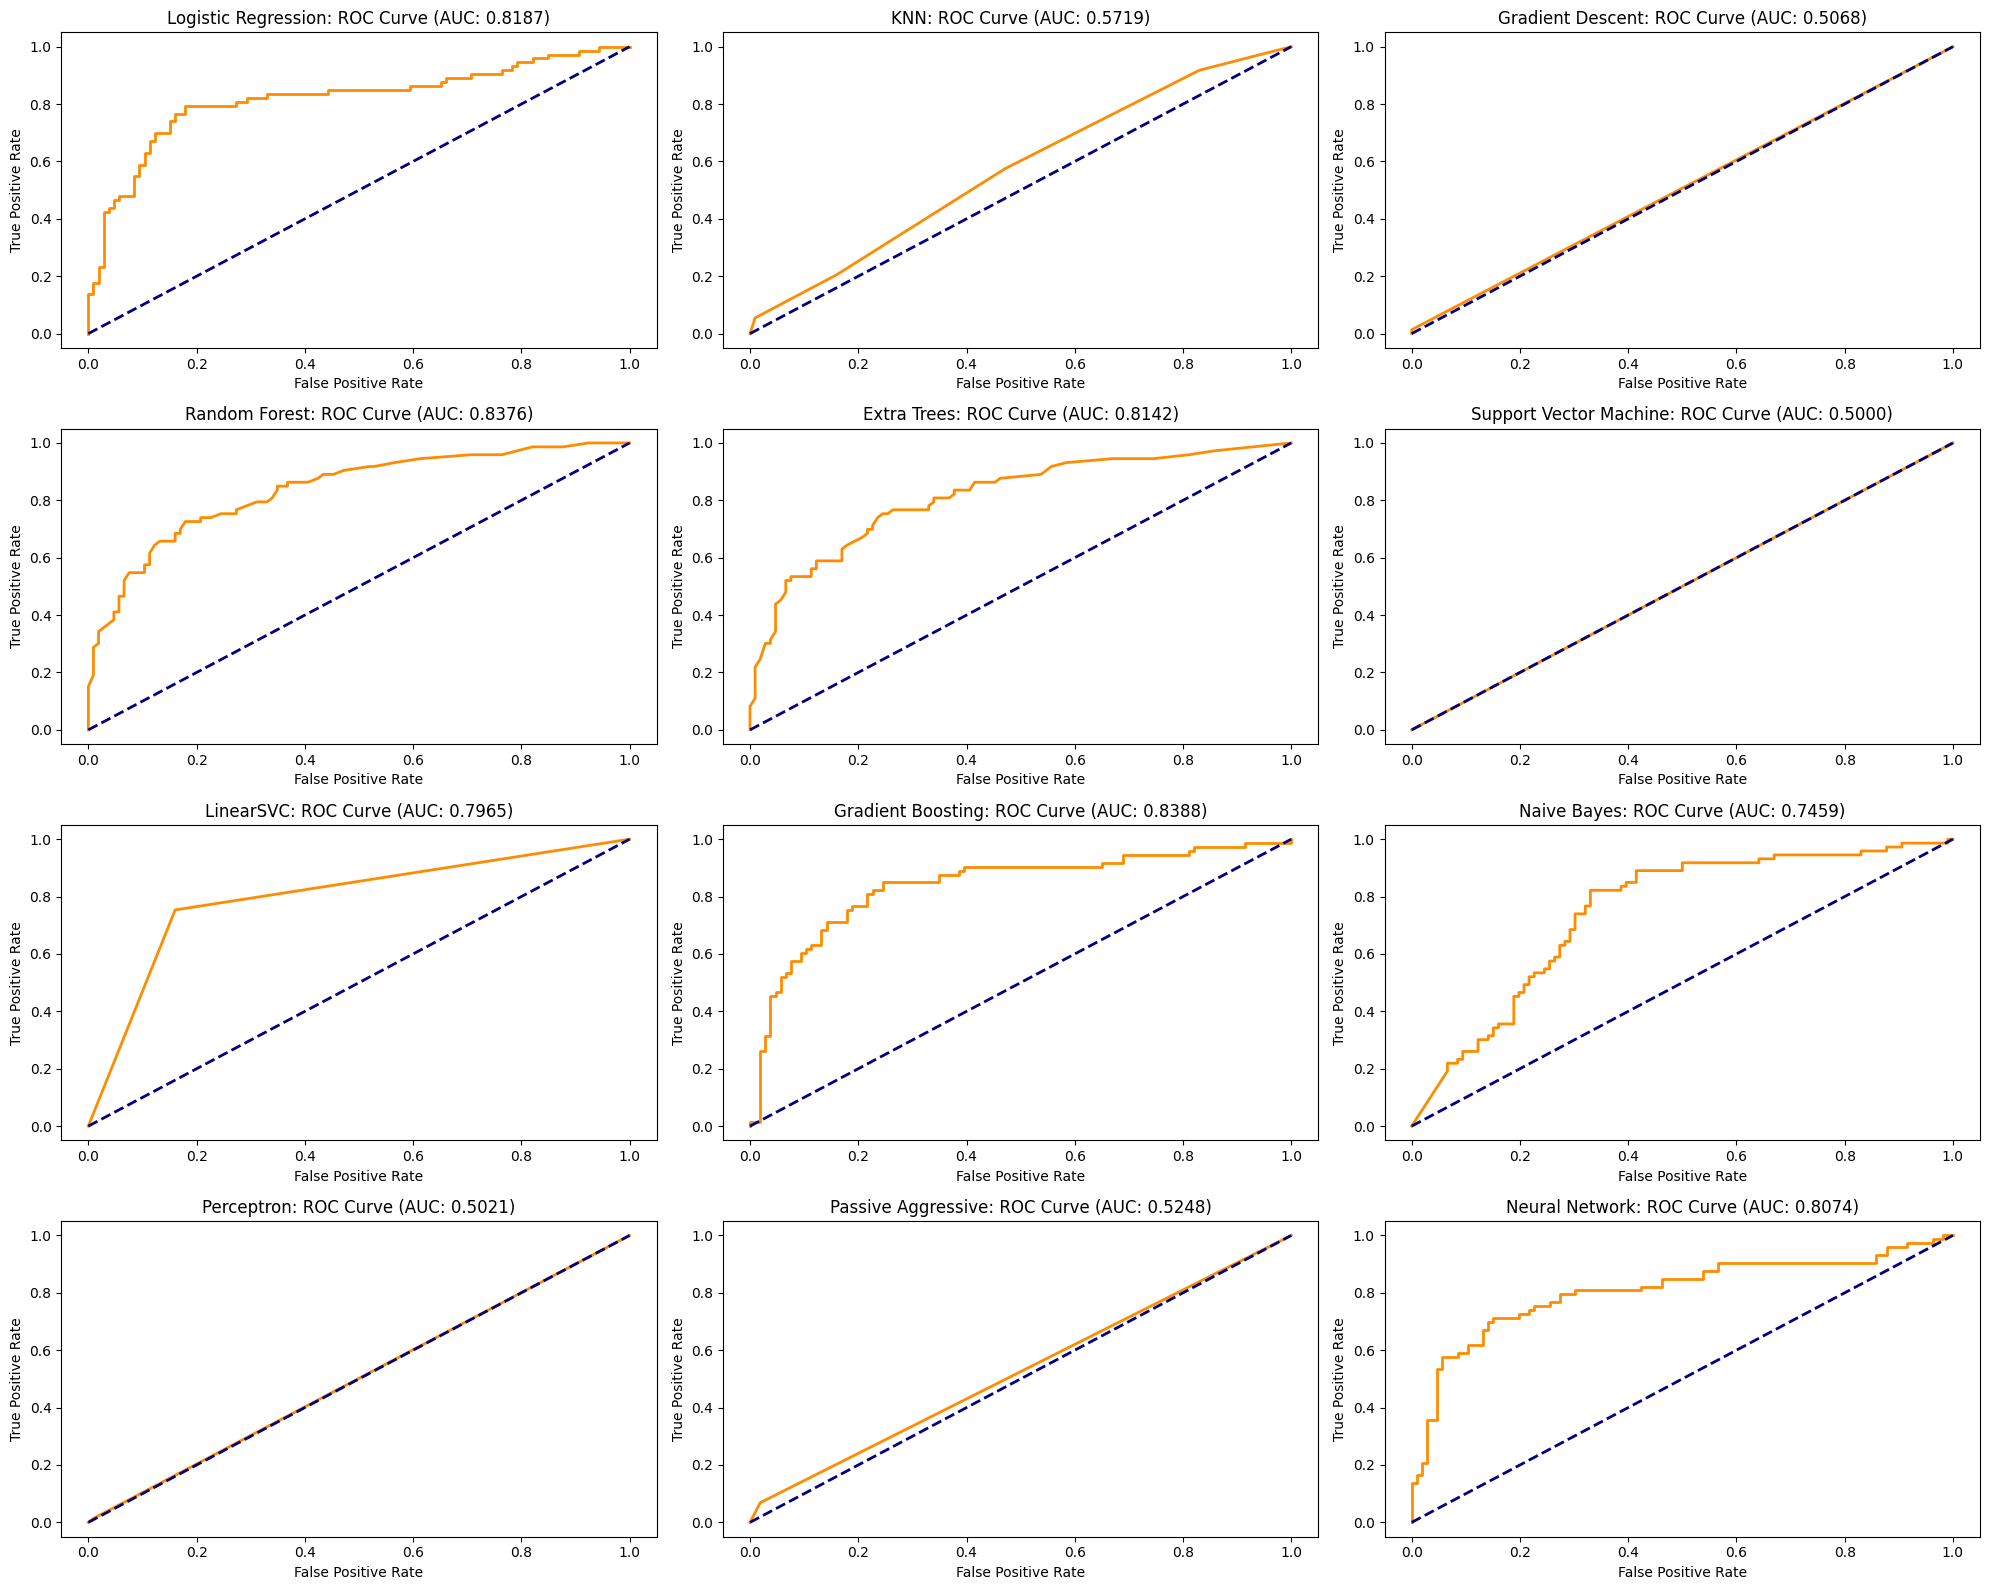

,F1,AUC-ROC,AUC_PR
Logistic Regression,0.755612,0.818687,0.794397
KNN,0.321218,0.571918,0.464873
Gradient Descent,0.338706,0.506849,0.415933
Random Forest,0.740894,0.837620,0.800666
Extra Trees,0.728773,0.814164,0.768977
Support Vector Machine,0.000000,0.500000,0.407821
LinearSVC,0.752576,0.796524,0.676091
Gradient Boosting,0.751936,0.838847,0.768391
Naive Bayes,0.734627,0.745929,0.610369
Perceptron,0.104495,0.502132,0.409084


,F1,AUC-ROC,AUC_PR
count,12.000000,12.000000,12.000000
mean,0.539661,0.688744,0.610844
std,0.278824,0.150859,0.172784
min,0.000000,0.500000,0.407821
25%,0.334334,0.520322,0.425592
50%,0.727508,0.771226,0.643230
75%,0.743654,0.815295,0.772912
max,0.755612,0.838847,0.800666


In [154]:
results = {}

fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes_iter = iter(axes.flatten())

with tqdm(MODELS.items(), desc=f"Evaluating models", leave=False) as pbar:
    for model_name, model_class in pbar:
        pbar.set_postfix({"model": model_name})

        model = Model(
            model_class=model_class,
            dataframe=DATAFRAME,
            name=model_name
        )

        results[model_name] = Metrics.evaluate(model)
        Plotter.plot_roc(model=model, plot_ax=next(axes_iter))

plt.tight_layout()
plt.show()

results_df = pd.DataFrame.from_dict(results, orient="index")
display(results_df)
display(results_df.describe())

Veiem que, tot i no ser la mètrica principal, hi ha models pels quals la línia és pràcticament recta. Anem a veure si podem millorar-ho d'alguna manera.

El dataframe té moltes features (24), intentem reduir aquestes dimensions a només les més importants. Fem un F-test i Chi-test per les variables numèriques i booleanes respectivament. D'aquesta manera, veurem si cada feature està relacionada amb la variable resposta.

In [155]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

X = processed_df.drop(columns=["Survived"])
y = processed_df["Survived"]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
boolean_features = X.select_dtypes(include=["bool"]).columns

anova_res = SelectKBest(f_classif, k='all').fit(X[numeric_features], y)
chi2_res = SelectKBest(chi2, k='all').fit(X[boolean_features].astype(int), y)

features_p_value = pd.DataFrame({
    "Feature": list(numeric_features) + list(boolean_features),
    "Score": list(anova_res.scores_) + list(chi2_res.scores_),
    "p-value": list(anova_res.pvalues_) + list(chi2_res.pvalues_)
}).sort_values("p-value").reset_index(drop=True)

display(features_p_value)

,Feature,Score,p-value
0,Title_Mr,112.805785,2.379805e-26
1,Pclass,115.031272,2.537047e-25
2,Fare,100.133372,2.072669e-22
3,Cabin__missing,99.253142,3.090891e-22
4,Sex_male,92.702447,6.077838e-22
5,Title_Mrs,89.474177,3.106671e-21
6,Title_Ms,79.531749,4.745381e-19
7,Deck_B,25.875581,3.641468e-07
8,Deck_X,20.731648,5.283552e-06
9,Deck_D,19.489646,1.011464e-05


In [156]:
features_p_value_top = features_p_value["Feature"].iloc[:7].tolist()
print(features_p_value_top)

['Title_Mr', 'Pclass', 'Fare', 'Cabin__missing', 'Sex_male', 'Title_Mrs', 'Title_Ms']


In [157]:
features_p_value_top = features_p_value["Feature"].iloc[:7].tolist()
display(features_p_value_top)

['Title_Mr',
 'Pclass',
 'Fare',
 'Cabin__missing',
 'Sex_male',
 'Title_Mrs',
 'Title_Ms']

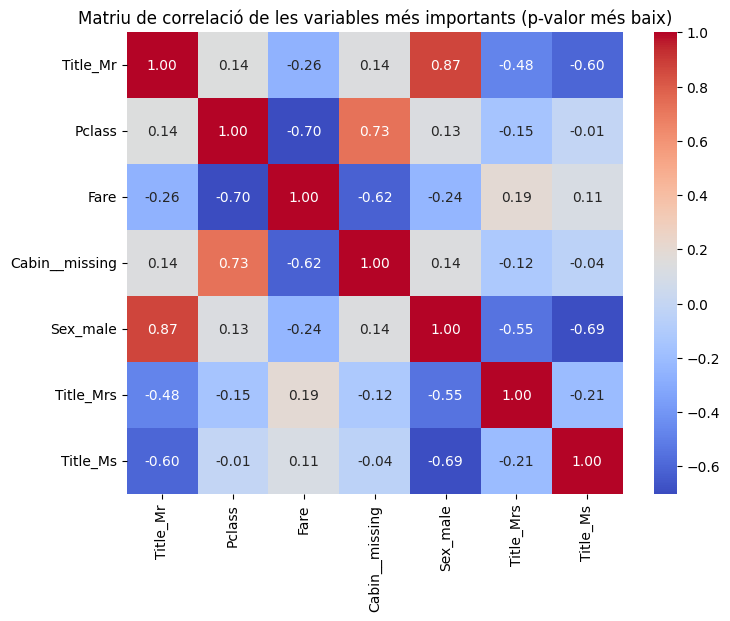

In [158]:
corr_matrix = processed_df[features_p_value_top].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriu de correlació de les variables més importants (p-valor més baix)")
plt.show()

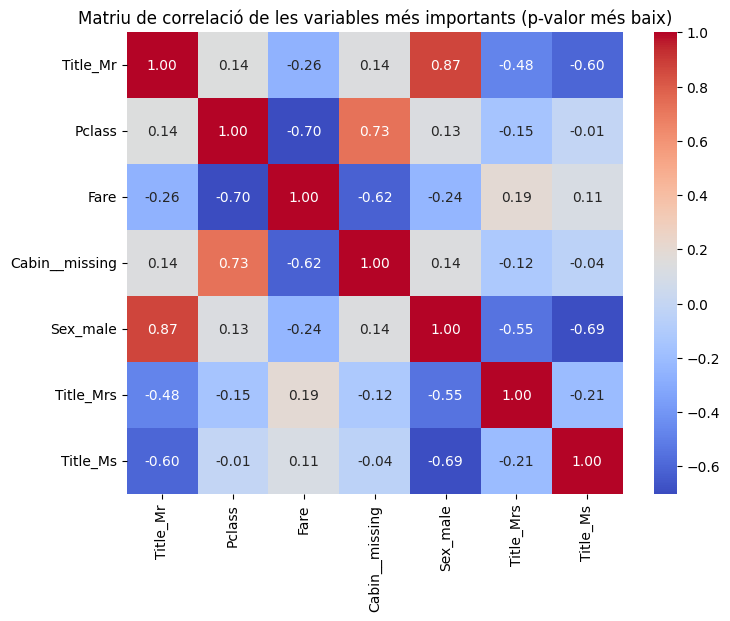

In [159]:
corr_matrix = processed_df[features_p_value_top].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriu de correlació de les variables més importants (p-valor més baix)")
plt.show()

In [160]:
final_features = [v for v in features_p_value_top if v not in ["Cabin__missing", "Title_Mr"]]
final_features

['Pclass', 'Fare', 'Sex_male', 'Title_Mrs', 'Title_Ms']

In [161]:
final_features = [v for v in features_p_value_top if v not in ["Cabin__missing", "Title_Mr"]]
display(final_features)

['Pclass', 'Fare', 'Sex_male', 'Title_Mrs', 'Title_Ms']

In [162]:
def select_top_features(dataframe: pd.DataFrame, explanatory: str = "Survived", top_n=7, exclude_features: list = None):
    exclude_features = exclude_features or []

    y = dataframe[explanatory]
    dataframe = dataframe.copy().drop(explanatory, axis=1)

    num_fts = dataframe.select_dtypes(include=["int64", "float64"]).columns
    bln_fts = dataframe.select_dtypes(include=["bool"]).columns

    anova_out = SelectKBest(f_classif, k="all").fit(dataframe[num_fts], y)
    chi2_out = SelectKBest(chi2, k="all").fit(dataframe[bln_fts].astype(int), y)

    p_vals = pd.DataFrame({
        "Feature": list(num_fts) + list(bln_fts),
        "Score": list(anova_out.scores_) + list(chi2_out.scores_),
        "p-value": list(anova_out.pvalues_) + list(chi2_out.pvalues_)
    }).sort_values("p-value").reset_index(drop=True)

    top_fts = p_vals["Feature"].iloc[:top_n].tolist()
    final_fts = [f for f in top_fts if f not in exclude_features]

    return pd.concat([dataframe[final_fts], y], axis=1)

feature_selector_transformer = FunctionTransformer(select_top_features, kw_args={
    "exclude_features": ["Cabin__missing","Title_Mr"]
})

I l'apliquem per obtenir un dataframe nou reduït.

In [163]:
DATAFRAME_REDUCED = feature_selector_transformer.transform(DATAFRAME)

In [164]:
DATAFRAME_REDUCED = feature_selector_transformer.transform(DATAFRAME)
DATAFRAME_REDUCED.describe(include="all")

,Pclass,Fare,Sex_male,Title_Mrs,Title_Ms,Survived
count,8.910000e+02,8.910000e+02,891,891,891,891.000000
unique,NaN,NaN,2,2,2,NaN
top,NaN,NaN,True,False,False,NaN
freq,NaN,NaN,577,765,706,NaN
mean,-7.575933e-17,-9.370232e-17,NaN,NaN,NaN,0.383838
std,1.000000e+00,1.000000e+00,NaN,NaN,NaN,0.486592
min,-1.565228e+00,-9.901283e-01,NaN,NaN,NaN,0.000000
25%,-3.691575e-01,-7.003343e-01,NaN,NaN,NaN,0.000000
50%,8.269128e-01,-4.606051e-01,NaN,NaN,NaN,0.000000
75%,8.269128e-01,1.455429e-01,NaN,NaN,NaN,1.000000


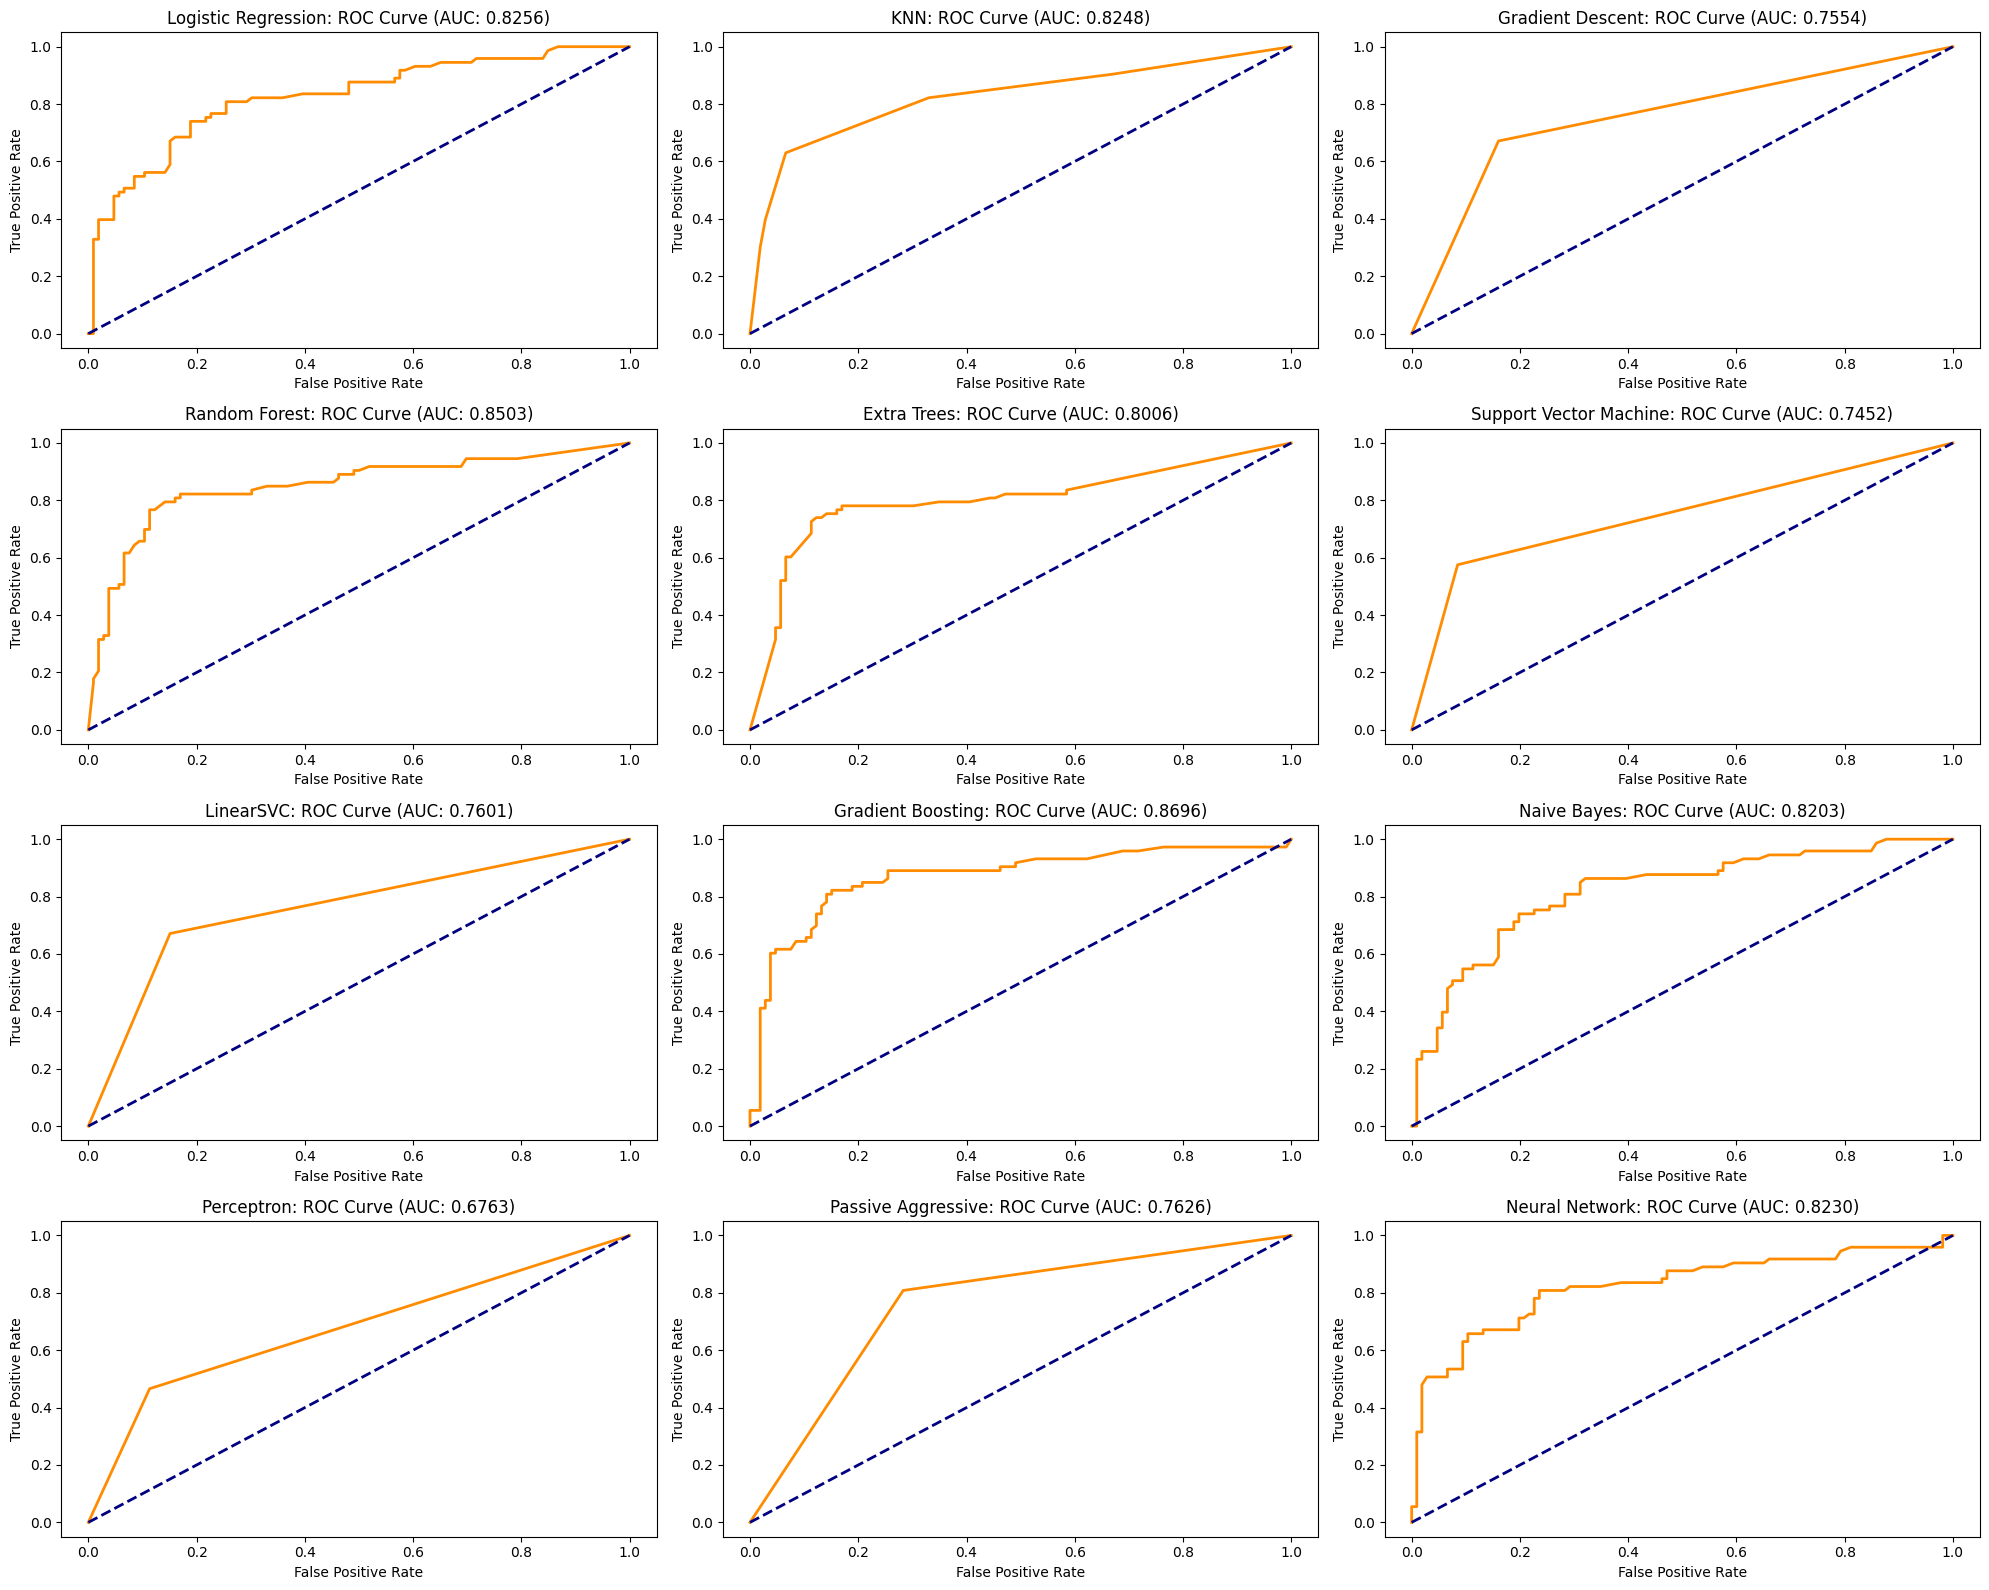

,F1,AUC-ROC,AUC_PR
Logistic Regression,0.708994,0.825601,0.774040
KNN,0.685419,0.824761,0.765103
Gradient Descent,0.704941,0.755428,0.632418
Random Forest,0.722584,0.850284,0.811485
Extra Trees,0.717102,0.800594,0.742889
Support Vector Machine,0.713227,0.745218,0.646996
LinearSVC,0.709787,0.760145,0.640085
Gradient Boosting,0.738405,0.869605,0.827685
Naive Bayes,0.714196,0.820302,0.751014
Perceptron,0.596690,0.676273,0.562130


,F1,AUC-ROC,AUC_PR
count,12.000000,12.000000,12.000000
mean,0.694430,0.792819,0.714129
std,0.042884,0.054145,0.089552
min,0.596690,0.676273,0.562130
25%,0.699748,0.758965,0.638168
50%,0.709390,0.810448,0.746951
75%,0.714923,0.824971,0.780957
max,0.738405,0.869605,0.827685


In [165]:
results = {}

fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes_iter = iter(axes.flatten())

with tqdm(MODELS.items(), desc="Evaluating models", leave=False) as pbar:
    for model_name, model_class in pbar:
        pbar.set_postfix({"model": model_name})
        model = Model(
            model_class=model_class,
            dataframe=DATAFRAME_REDUCED,
            name=model_name
        )

        results[model_name] = Metrics.evaluate(model)
        Plotter.plot_roc(model=model, plot_ax=next(axes_iter))

plt.tight_layout()
plt.show()

results_df = pd.DataFrame.from_dict(results, orient="index")
display(results_df)
display(results_df.describe())

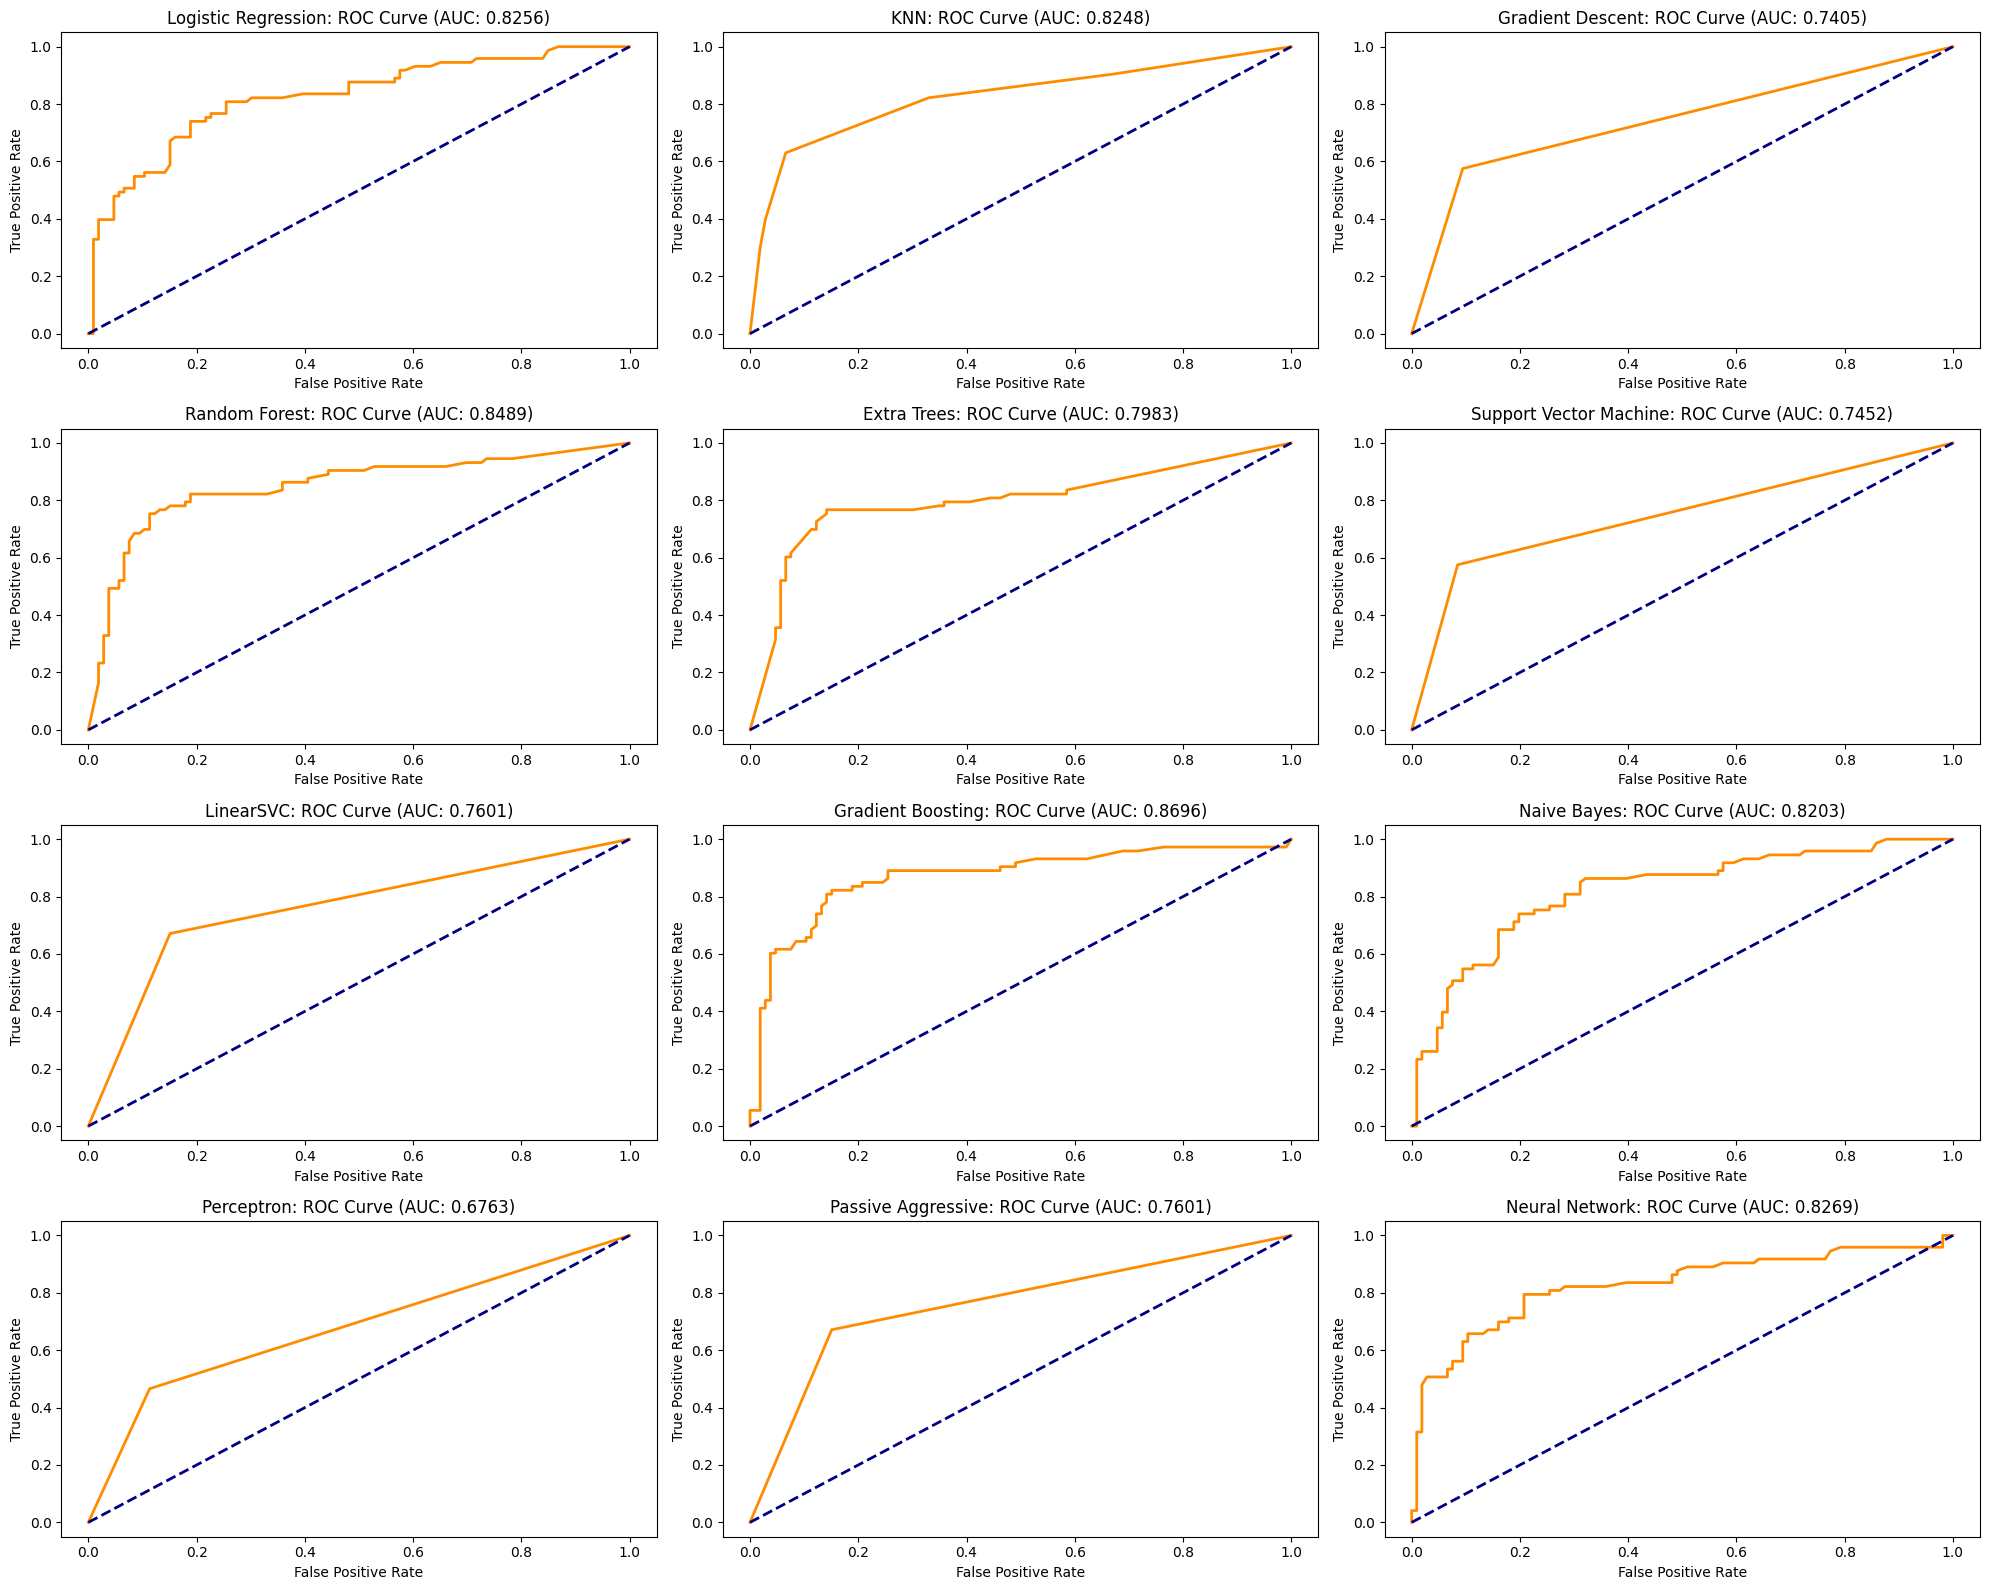

,F1,AUC-ROC,AUC_PR
Logistic Regression,0.708994,0.825601,0.774040
KNN,0.685419,0.824761,0.765103
Gradient Descent,0.654668,0.740501,0.637884
Random Forest,0.718974,0.848863,0.796882
Extra Trees,0.720110,0.798268,0.741219
Support Vector Machine,0.713227,0.745218,0.646996
LinearSVC,0.709787,0.760145,0.640085
Gradient Boosting,0.738623,0.869605,0.827685
Naive Bayes,0.714196,0.820302,0.751014
Perceptron,0.596690,0.676273,0.562130


,F1,AUC-ROC,AUC_PR
count,12.000000,12.000000,12.000000
mean,0.684390,0.791381,0.715487
std,0.056391,0.055411,0.085409
min,0.551160,0.676273,0.562130
25%,0.677731,0.756413,0.640085
50%,0.709390,0.809285,0.746116
75%,0.715391,0.825924,0.779751
max,0.738623,0.869605,0.827685


In [166]:
results = {}

fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes_iter = iter(axes.flatten())

with tqdm(MODELS.items(), desc="Evaluating models", leave=False) as pbar:
    for model_name, model_class in pbar:
        pbar.set_postfix({"model": model_name})
        model = Model(
            model_class=model_class,
            dataframe=DATAFRAME_REDUCED,
            name=model_name
        )

        results[model_name] = Metrics.evaluate(model)
        Plotter.plot_roc(model=model, plot_ax=next(axes_iter))

plt.tight_layout()
plt.show()

results_df = pd.DataFrame.from_dict(results, orient="index")
display(results_df)
display(results_df.describe())

In [169]:
from itertools import combinations


cols = DATAFRAME_REDUCED.drop(EXPLANATORY, axis=1).columns
features_combinations = []
for r in range(1, len(cols)+1):
    for combo in combinations(cols, r):
        features_combinations.append(list(combo))

results = []

for model_name, model_class in MODELS.items():
    model = Model(
        model_class=model_class,
        dataframe=DATAFRAME_REDUCED,
        name=model_name
    )

    with tqdm(features_combinations, desc=f"{model_name}", leave=False) as pbar:
        for features in pbar:
            pbar.set_postfix({"features": features})

            model.update_dataset(features=features)
            metrics = Metrics.evaluate(model)
            results.append({"Model": model_name, "Features": features, **metrics})

results_df = pd.DataFrame(results)
display(results_df)
display(results_df.describe())

,Model,Features,F1,AUC-ROC,AUC_PR
0,Logistic Regression,[Pclass],0.486262,0.637051,0.520001
1,Logistic Regression,[Fare],0.434045,0.656888,0.566969
2,Logistic Regression,[Sex_male],0.709787,0.760145,0.640085
3,Logistic Regression,[Title_Mrs],0.426504,0.594986,0.492194
4,Logistic Regression,[Title_Ms],0.491789,0.658310,0.548443
...,...,...,...,...,...
367,Neural Network,"[Pclass, Fare, Sex_male, Title_Ms]",0.708020,0.824179,0.812903
368,Neural Network,"[Pclass, Fare, Title_Mrs, Title_Ms]",0.696401,0.823792,0.799056
369,Neural Network,"[Pclass, Sex_male, Title_Mrs, Title_Ms]",0.671532,0.810739,0.747349
370,Neural Network,"[Fare, Sex_male, Title_Mrs, Title_Ms]",0.705242,0.820949,0.743019


,F1,AUC-ROC,AUC_PR
count,372.000000,372.000000,372.000000
mean,0.619383,0.725441,0.631596
std,0.105799,0.093225,0.106645
min,0.037247,0.418519,0.374760
25%,0.563611,0.663220,0.555891
50%,0.645223,0.754620,0.640085
75%,0.708570,0.801774,0.727516
max,0.747202,0.871285,0.847169


In [170]:
from itertools import combinations

cols = DATAFRAME_REDUCED.drop(EXPLANATORY, axis=1).columns
features_combinations = []
for r in range(1, len(cols)+1):
    for combo in combinations(cols, r):
        features_combinations.append(list(combo))

results = []

for model_name, model_class in MODELS.items():
    model = Model(
        model_class=model_class,
        dataframe=DATAFRAME_REDUCED,
        name=model_name
    )

    with tqdm(features_combinations, desc=f"{model_name}", leave=False) as pbar:
        for features in pbar:
            pbar.set_postfix({"features": features})

            model.update_dataset(features=features)
            metrics = Metrics.evaluate(model)
            results.append({"Model": model_name, "Features": features, **metrics})

results_df = pd.DataFrame(results)
display(results_df)
display(results_df.describe())

Logistic Regression:   0%|          | 0/31 [00:00<?, ?it/s, features=['Pclass']]

,Model,Features,F1,AUC-ROC,AUC_PR
0,Logistic Regression,[Pclass],0.486262,0.637051,0.520001
1,Logistic Regression,[Fare],0.434045,0.656888,0.566969
2,Logistic Regression,[Sex_male],0.709787,0.760145,0.640085
3,Logistic Regression,[Title_Mrs],0.426504,0.594986,0.492194
4,Logistic Regression,[Title_Ms],0.491789,0.658310,0.548443
...,...,...,...,...,...
367,Neural Network,"[Pclass, Fare, Sex_male, Title_Ms]",0.707990,0.828444,0.808175
368,Neural Network,"[Pclass, Fare, Title_Mrs, Title_Ms]",0.696812,0.827022,0.804666
369,Neural Network,"[Pclass, Sex_male, Title_Mrs, Title_Ms]",0.664811,0.814616,0.753750
370,Neural Network,"[Fare, Sex_male, Title_Mrs, Title_Ms]",0.706455,0.819656,0.741542


,F1,AUC-ROC,AUC_PR
count,372.000000,372.000000,372.000000
mean,0.618995,0.724496,0.630645
std,0.104587,0.093293,0.106915
min,0.074103,0.384272,0.365239
25%,0.563585,0.658310,0.551943
50%,0.643419,0.753974,0.640085
75%,0.707874,0.801095,0.727981
max,0.749420,0.871285,0.856930


In [171]:
results_df \
        .sort_values(by=["Model", "F1"], ascending=[True, False]) \
        .groupby("Model", group_keys=False) \
        .head(1) \
        .reset_index(drop=True)

,Model,Features,F1,AUC-ROC,AUC_PR
0,Extra Trees,"[Pclass, Fare, Sex_male]",0.747498,0.839493,0.830496
1,Gradient Boosting,"[Pclass, Fare, Sex_male]",0.747202,0.871220,0.844250
2,Gradient Descent,[Sex_male],0.709787,0.760145,0.640085
3,KNN,"[Pclass, Fare, Sex_male]",0.712326,0.849574,0.794658
4,LinearSVC,[Sex_male],0.709787,0.760145,0.640085
5,Logistic Regression,[Sex_male],0.709787,0.760145,0.640085
6,Naive Bayes,"[Pclass, Fare, Sex_male, Title_Mrs, Title_Ms]",0.714196,0.820302,0.751014
7,Neural Network,"[Pclass, Fare, Sex_male]",0.709946,0.831158,0.819168
8,Passive Aggressive,"[Pclass, Sex_male]",0.665862,0.691652,0.568774
9,Perceptron,"[Pclass, Sex_male, Title_Mrs]",0.642821,0.691652,0.568774


In [172]:
results_df \
        .sort_values(by=["Model", "F1"], ascending=[True, False]) \
        .groupby("Model", group_keys=False) \
        .head(1) \
        .reset_index(drop=True)

,Model,Features,F1,AUC-ROC,AUC_PR
0,Extra Trees,"[Pclass, Fare, Sex_male]",0.747498,0.839493,0.830496
1,Gradient Boosting,"[Pclass, Fare, Sex_male]",0.747202,0.871220,0.844250
2,Gradient Descent,[Sex_male],0.709787,0.760145,0.640085
3,KNN,"[Pclass, Fare, Sex_male]",0.712326,0.849574,0.794658
4,LinearSVC,[Sex_male],0.709787,0.760145,0.640085
5,Logistic Regression,[Sex_male],0.709787,0.760145,0.640085
6,Naive Bayes,"[Pclass, Fare, Sex_male, Title_Mrs, Title_Ms]",0.714196,0.820302,0.751014
7,Neural Network,"[Pclass, Fare, Sex_male]",0.709946,0.831158,0.819168
8,Passive Aggressive,"[Pclass, Sex_male]",0.665862,0.691652,0.568774
9,Perceptron,"[Pclass, Sex_male, Title_Mrs]",0.642821,0.691652,0.568774


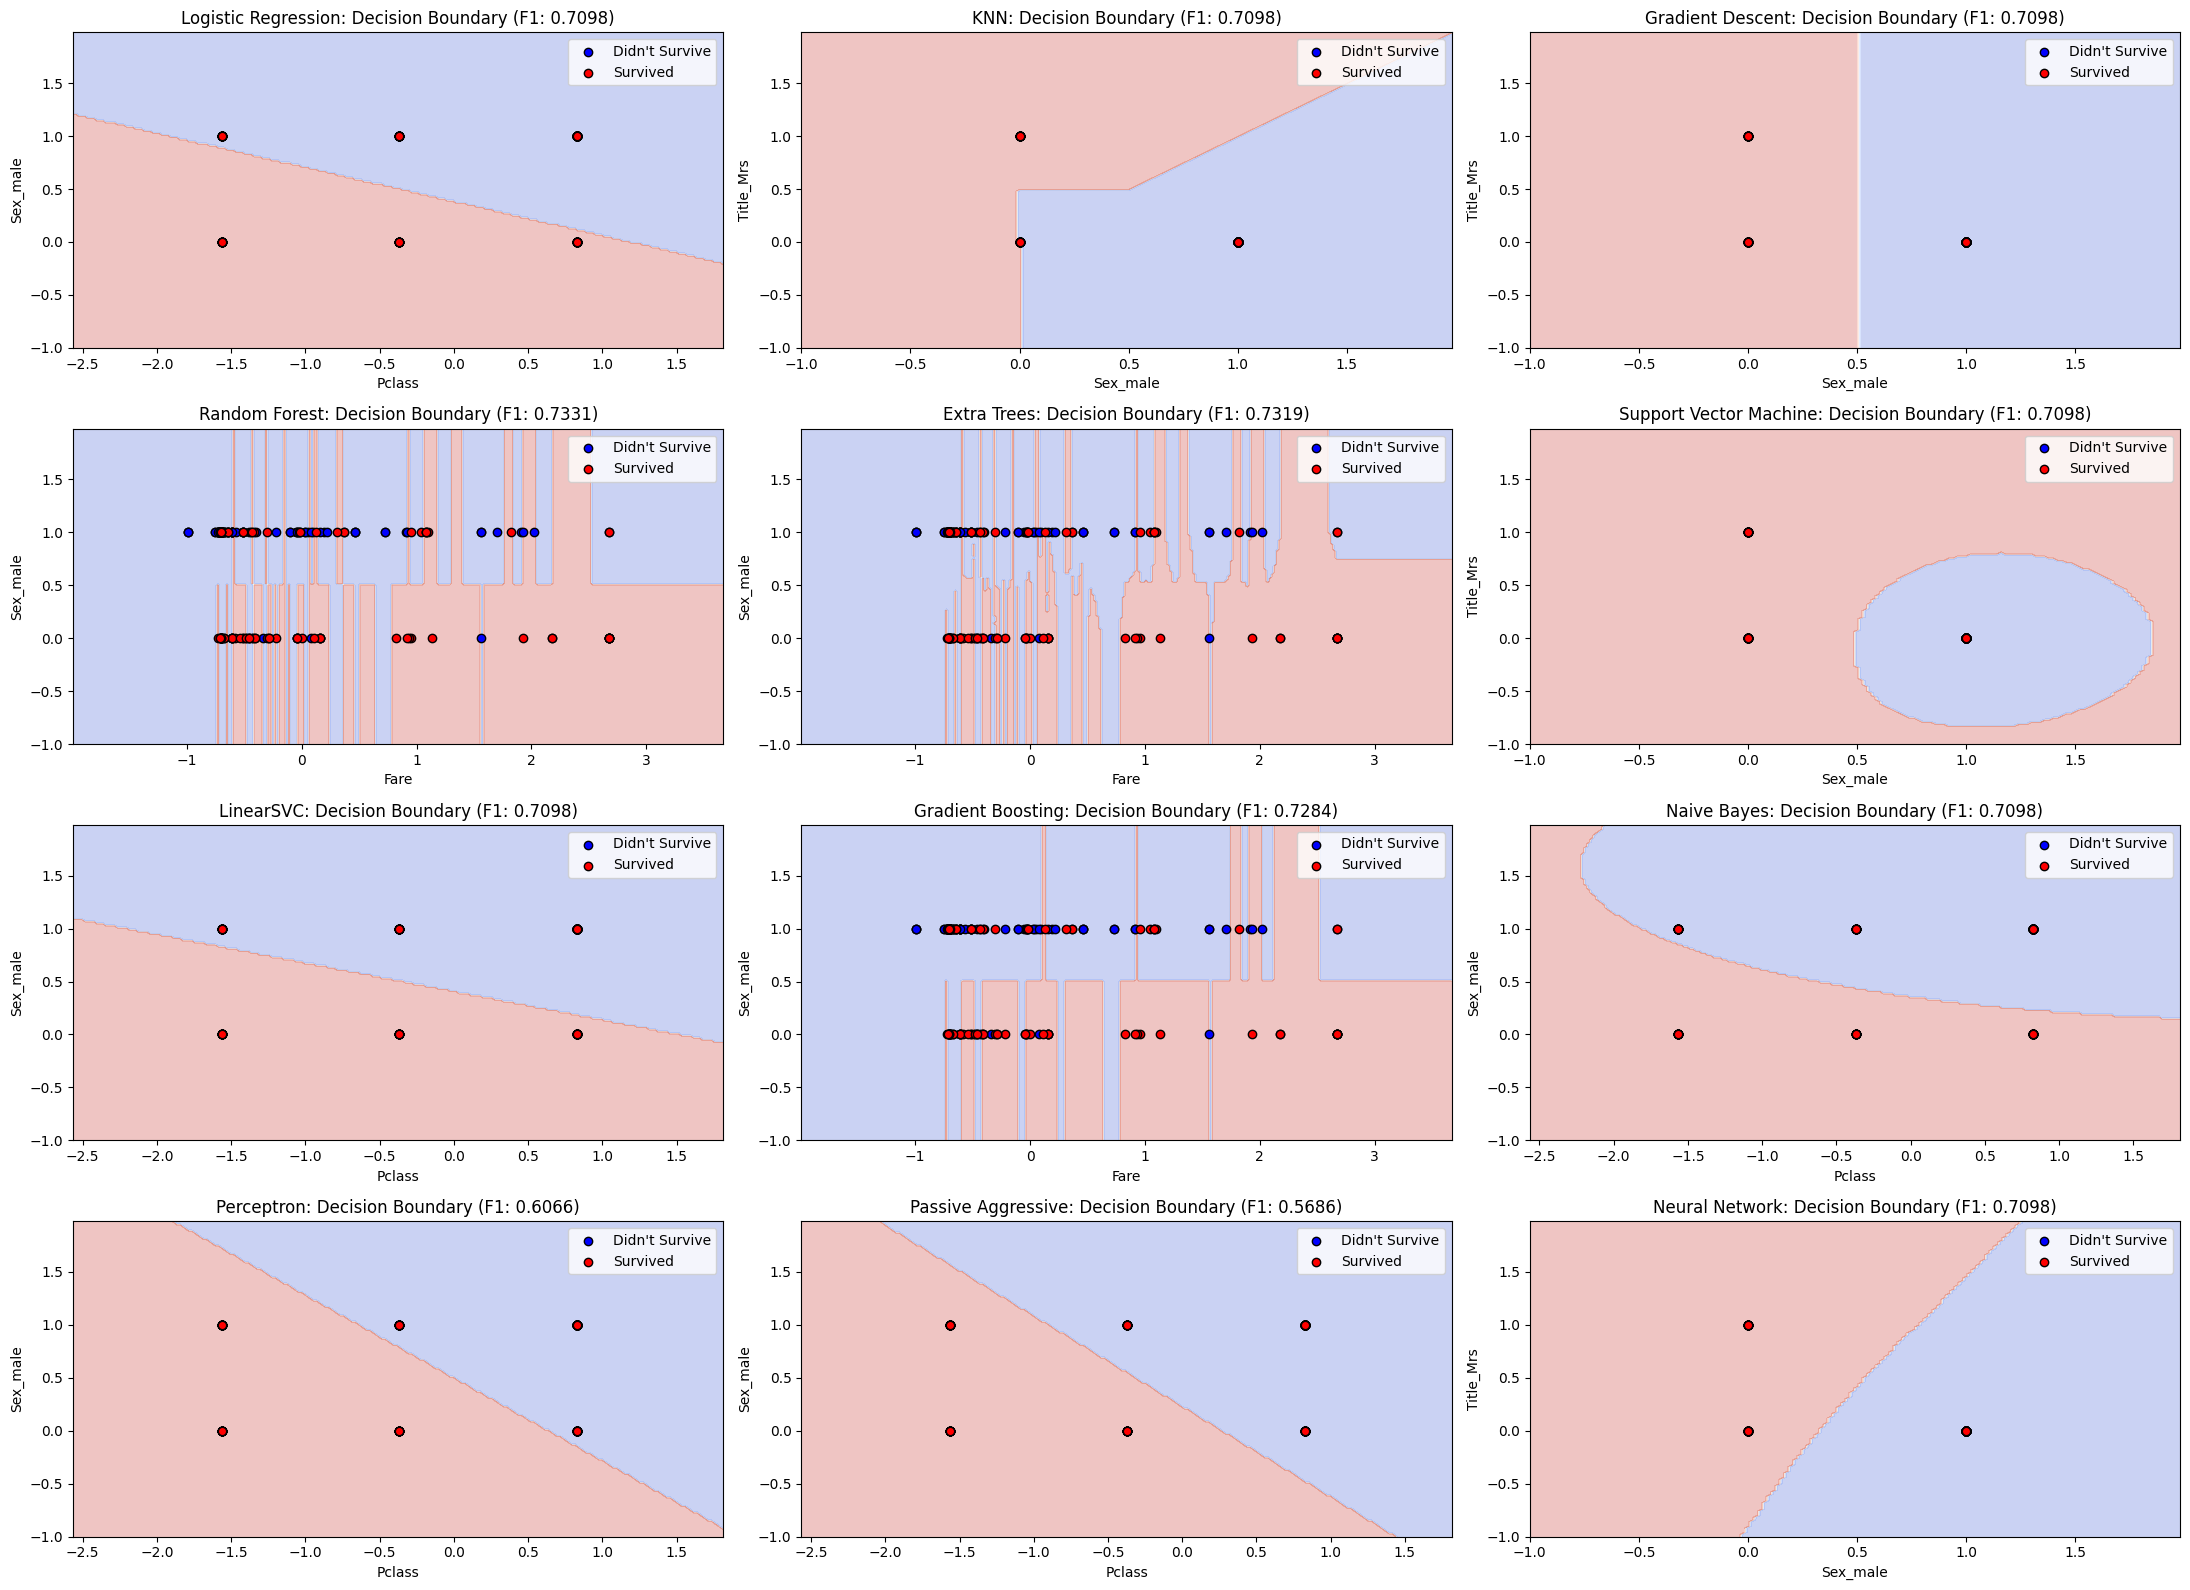

In [174]:
results = {}

fig, axes = plt.subplots(4, 3, figsize=(22, 16))
axes_iter = iter(axes.flatten())

with tqdm(MODELS.items(), desc="Evaluating models", leave=False) as pbar:
    for model_name, model_class in pbar:
        pbar.set_postfix({"model": model_name})
        filtered = results_df[
            (results_df["Model"] == model_name) &
            (results_df["Features"].apply(lambda x: len(x) == 2))
        ]

        top_model = filtered.sort_values(by="F1", ascending=False).iloc[0]
        features = top_model["Features"]

        model = Model(
            model_class=model_class,
            dataframe=DATAFRAME_REDUCED,
            name=model_name
        )
        model.update_dataset(features=features)
        Plotter.plot_decision_boundary(
            model=model,
            plot_ax=next(axes_iter)
        )

plt.tight_layout()
plt.show()

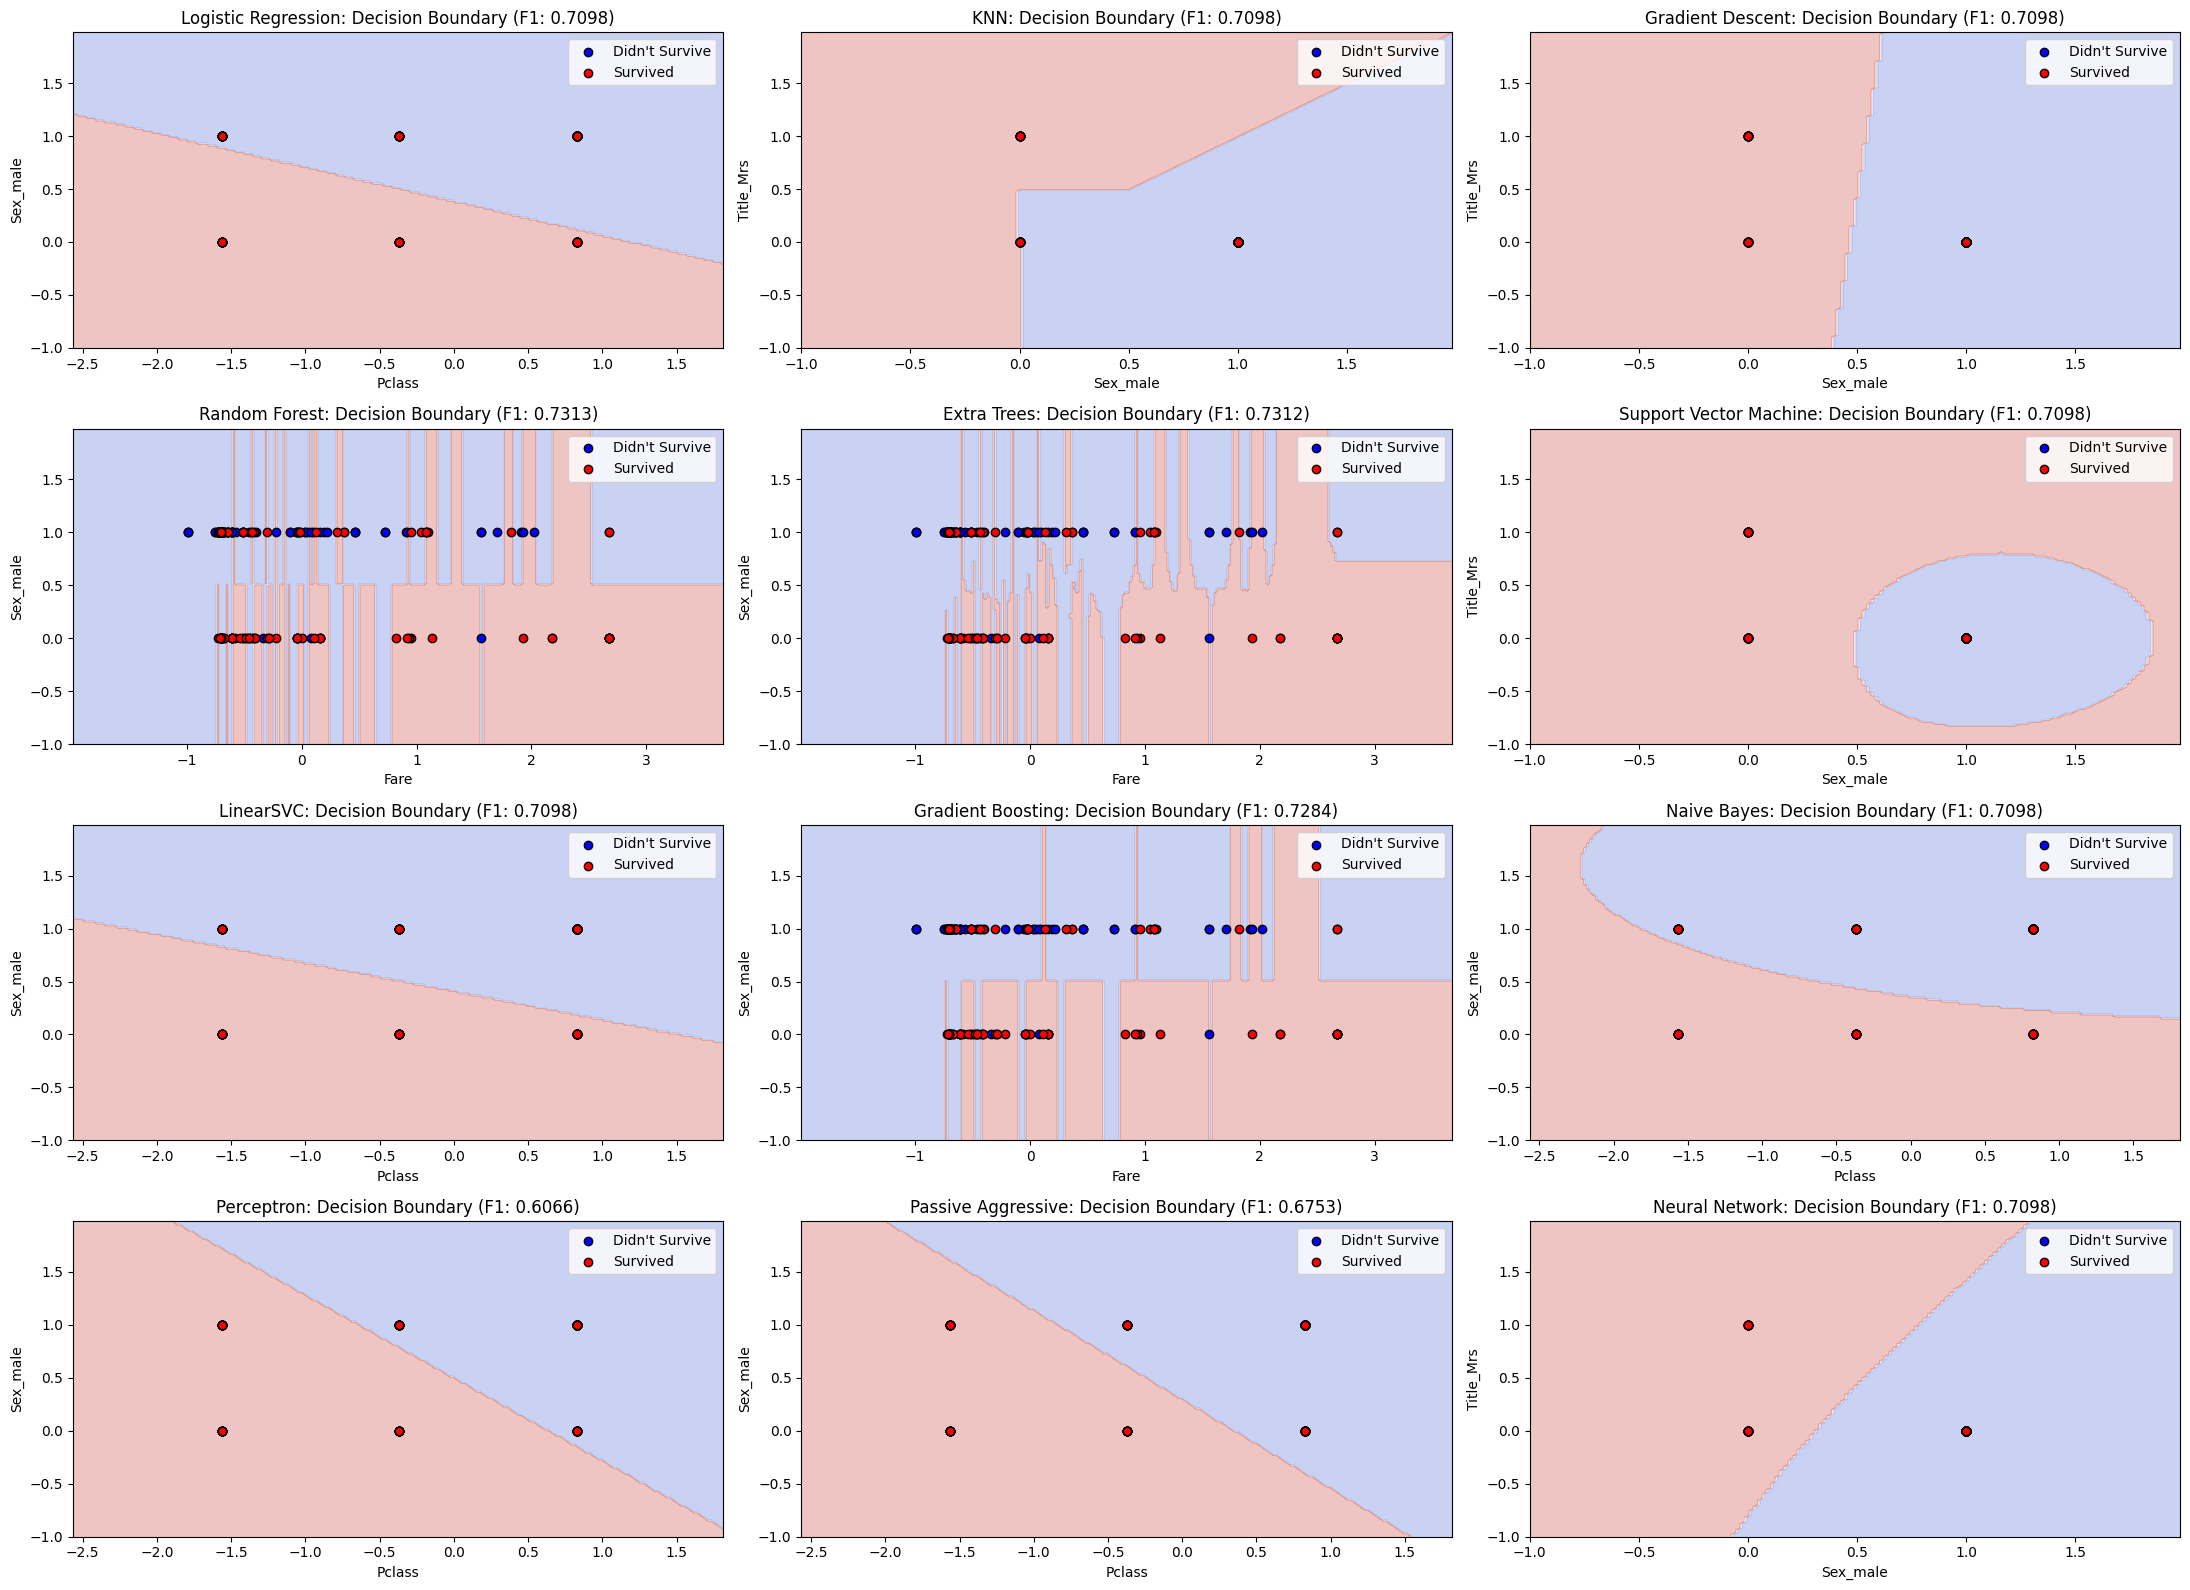

In [175]:
results = {}

fig, axes = plt.subplots(4, 3, figsize=(22, 16))
axes_iter = iter(axes.flatten())

with tqdm(MODELS.items(), desc="Evaluating models", leave=False) as pbar:
    for model_name, model_class in pbar:
        pbar.set_postfix({"model": model_name})
        filtered = results_df[
            (results_df["Model"] == model_name) &
            (results_df["Features"].apply(lambda x: len(x) == 2))
        ]

        top_model = filtered.sort_values(by="F1", ascending=False).iloc[0]
        features = top_model["Features"]

        model = Model(
            model_class=model_class,
            dataframe=DATAFRAME_REDUCED,
            name=model_name
        )
        model.update_dataset(features=features)
        Plotter.plot_decision_boundary(
            model=model,
            plot_ax=next(axes_iter)
        )

plt.tight_layout()
plt.show()

Per aquests gràfics, detectem un problema molt gran: l'overfitting. En el cas del Random Forest (i Extra Trees) veiem com el model ha començat a memoritzar cada dada. A nivell de model, el que està passant és que està creant una branca per a cada dada. Això passa perquè el paràmetre `max_depth` per defecte és `None`, és a dir que pot créixer l'arbre amb tants nivells com vulgui. Amb les poquees dades que tenim (menys de 1000), això significarà que ràpidament es crearan fulles per cada una d'elles.

Per aquesta raó, el següent pas és trobar els hiperparàmetres òptims: millorin el rendiment i també evitin l'overfitting.

#### Optimització d'Hiperparàmetres

Creem una classe que automatitzi aquest cerca.

Definim tres tipus: `grid`, `randomized` i `halved`. Com abans, considerem que el dataset és petit i podem provar totes les combinacions, per tant, farem servir la cerca grid. Les altres dues es podrien fer servir si tinguéssim moltes més dades, o volguéssim provar moltes més possibilitats de paràmetres.

Les funcions de la llibreria també permeten indicar el splitting de la validació creuada, per tant, indicarem l'escollida, és a dir la Repeated Stratified K-Fold.

In [176]:
class HyperParameterOptimization:
    @staticmethod
    def grid_search(model: Model, param_grid: dict, scoring: str = "f1", cv = None):
        return HyperParameterOptimization.search(
            model=model,
            searcher_class=GridSearchCV,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv
        )

    @staticmethod
    def randomized_search(model: Model, param_grid: dict, scoring: str = "f1", cv = None, n_iter: int = 20):
        return HyperParameterOptimization.search(
            model=model,
            searcher_class=RandomizedSearchCV,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv,
            n_iter=n_iter,
            random_state=model.random_state,
        )

    @staticmethod
    def randomized_search(model: Model, param_grid: dict, scoring: str = "f1", cv = None, factor: int = 2):
        return HyperParameterOptimization.search(
            model=model,
            searcher_class=HalvingGridSearchCV,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv,
            factor=factor,
        )

    @staticmethod
    def search(model: Model, searcher_class, param_grid: dict, scoring: str = "f1", cv = None, **kwargs):
        model_class = model.model_class(**model.hyperparameters)
        if cv is None:
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=model.random_state)
        searcher = searcher_class(
            estimator=model_class,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv,
            n_jobs=-1,
            return_train_score=True,
            error_score=np.nan,
            **kwargs
        )
        searcher.fit(model.X_train, model.y_train)
        return HyperParameterOptimization.update_model(model, searcher)

    @staticmethod
    def update_model(model: Model, searcher):
        model.model_class = searcher.best_estimator_
        model.hyperparameters = searcher.best_params_
        model.model_class.fit(model.X_train, model.y_train)
        model.valid_pred = False
        model.search_results_ = pd.DataFrame(searcher.cv_results_)
        model.search_results_["overfit_gap"] = model.search_results_["mean_train_score"] - model.search_results_["mean_test_score"]

        return model.search_results_

In [177]:
def plot_param_heatmap(model: Model, param_x, param_y, plot_ax=None, metric="mean_test_score"):
    if not hasattr(model, "search_results_") or model.search_results_ is None:
        raise ValueError("No search results found. Run HyperParameterOptimization first.")

    df = model.search_results_

    param_x_col = f"param_{param_x}"
    param_y_col = f"param_{param_y}"

    if param_x_col not in df.columns or param_y_col not in df.columns:
        raise KeyError(f"Parameters not found in search results. Available: {[c for c in df.columns if c.startswith('param_')]}")

    pivot = df.pivot_table(values=metric, index=param_y_col, columns=param_x_col)

    if plot_ax is None:
        _, plot_ax = plt.subplots(figsize=(7, 5))

    title = f"{model.name}: {metric} Heatmap"

    sns.heatmap(pivot, annot=pivot.size <= 25, fmt=".4f", cmap="coolwarm", ax=plot_ax)
    plot_ax.set_title(title)
    plot_ax.set_xlabel(param_x)
    plot_ax.set_ylabel(param_y)

Plotter.plot_param_heatmap = staticmethod(plot_param_heatmap)

{'max_depth': 6, 'n_estimators': 51}

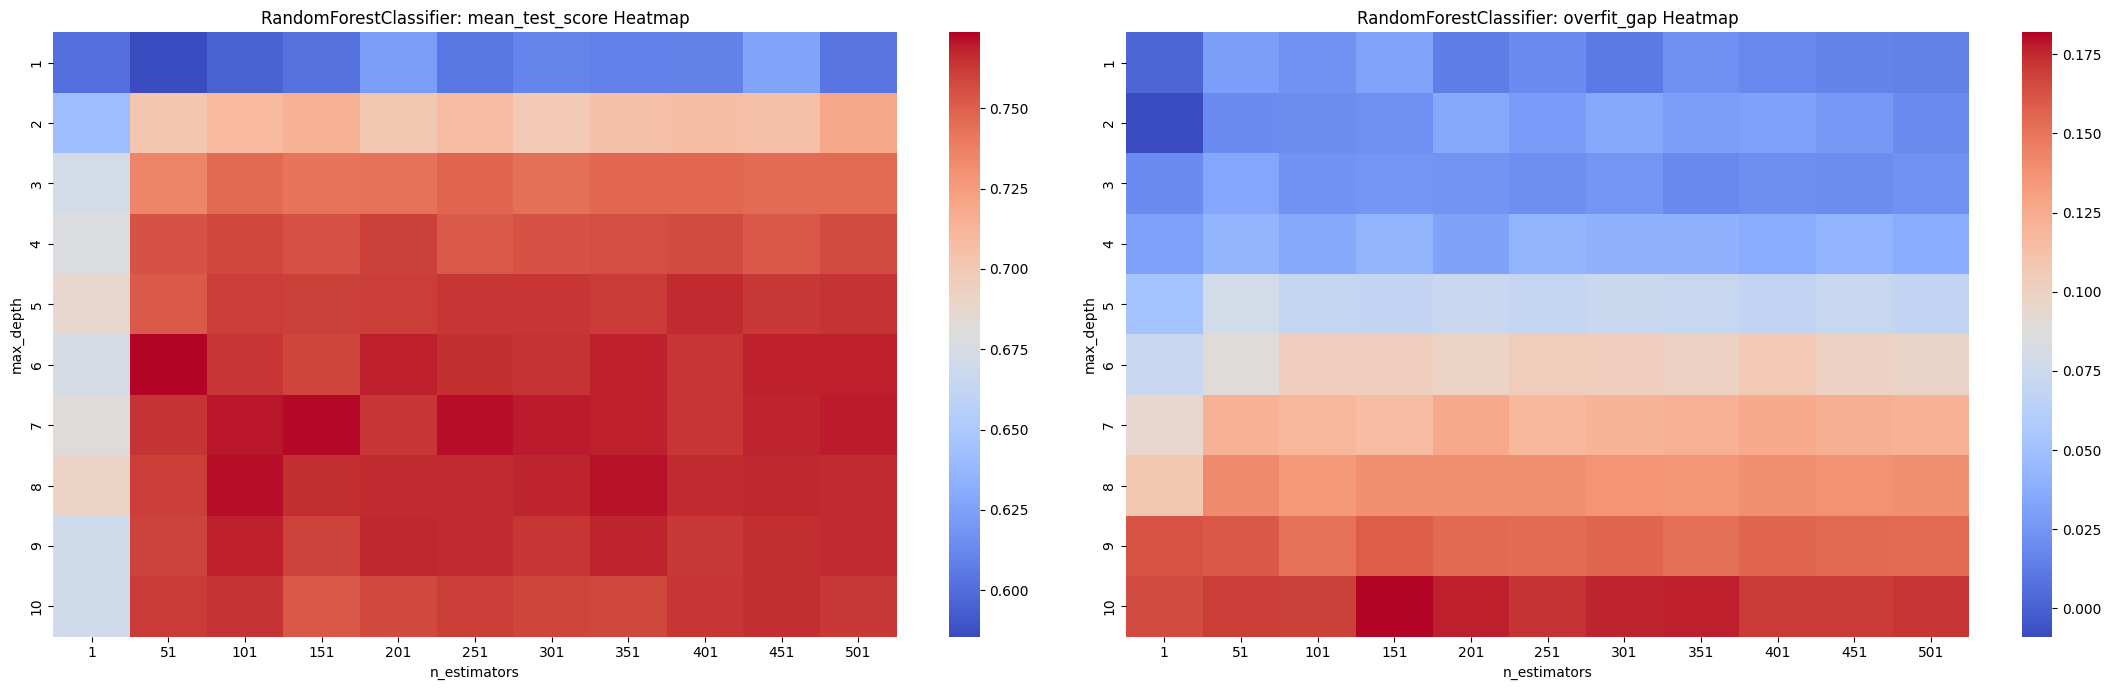

In [178]:
rf_model = Model(
    model_class=RandomForestClassifier,
    dataframe=DATAFRAME
)

param_grid = {"n_estimators": range(1, 502, 50), "max_depth": range(1, 11)}
results = HyperParameterOptimization.grid_search(rf_model, param_grid)
display(rf_model.hyperparameters)

fig, axes = plt.subplots(1, 2, figsize=(22, 7))
axes_iter = iter(axes.flatten())

Plotter.plot_param_heatmap(rf_model, "n_estimators", "max_depth", plot_ax=next(axes_iter))
Plotter.plot_param_heatmap(rf_model, "n_estimators", "max_depth", plot_ax=next(axes_iter), metric="overfit_gap")

plt.tight_layout()

Anem a provar les noves funcions amb el model Random Forest:

{'max_depth': 9, 'n_estimators': 201}

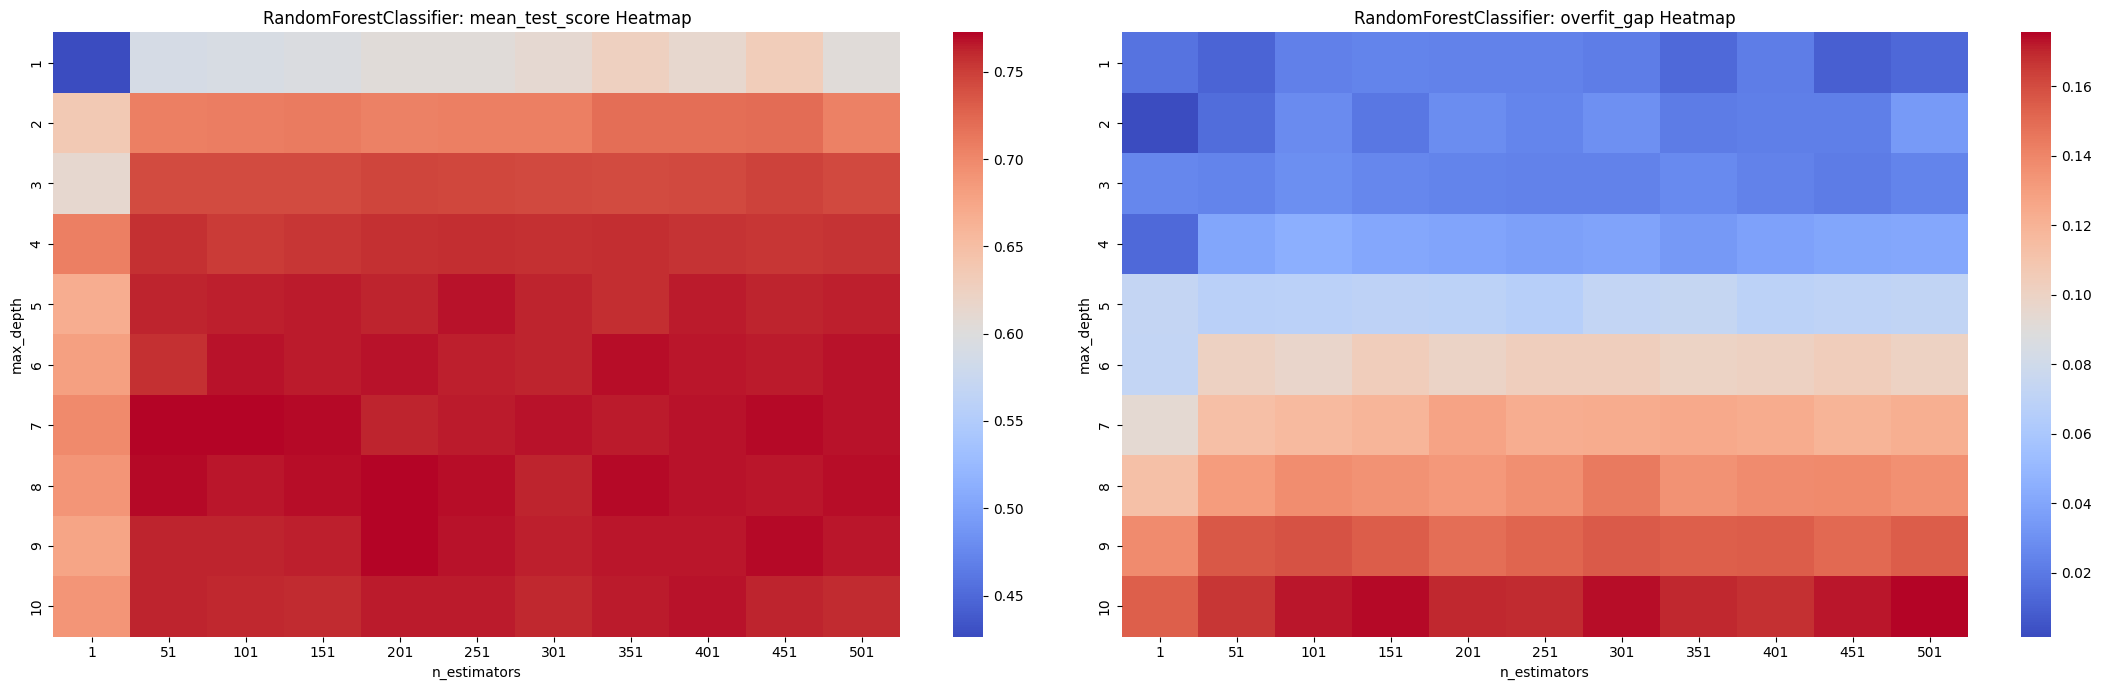

In [179]:
rf_model = Model(
    model_class=RandomForestClassifier,
    dataframe=DATAFRAME
)

param_grid = {"n_estimators": range(1, 502, 50), "max_depth": range(1, 11)}
results = HyperParameterOptimization.grid_search(rf_model, param_grid)
display(rf_model.hyperparameters)

fig, axes = plt.subplots(1, 2, figsize=(22, 7))
axes_iter = iter(axes.flatten())

Plotter.plot_param_heatmap(rf_model, "n_estimators", "max_depth", plot_ax=next(axes_iter))
Plotter.plot_param_heatmap(rf_model, "n_estimators", "max_depth", plot_ax=next(axes_iter), metric="overfit_gap")

plt.tight_layout()

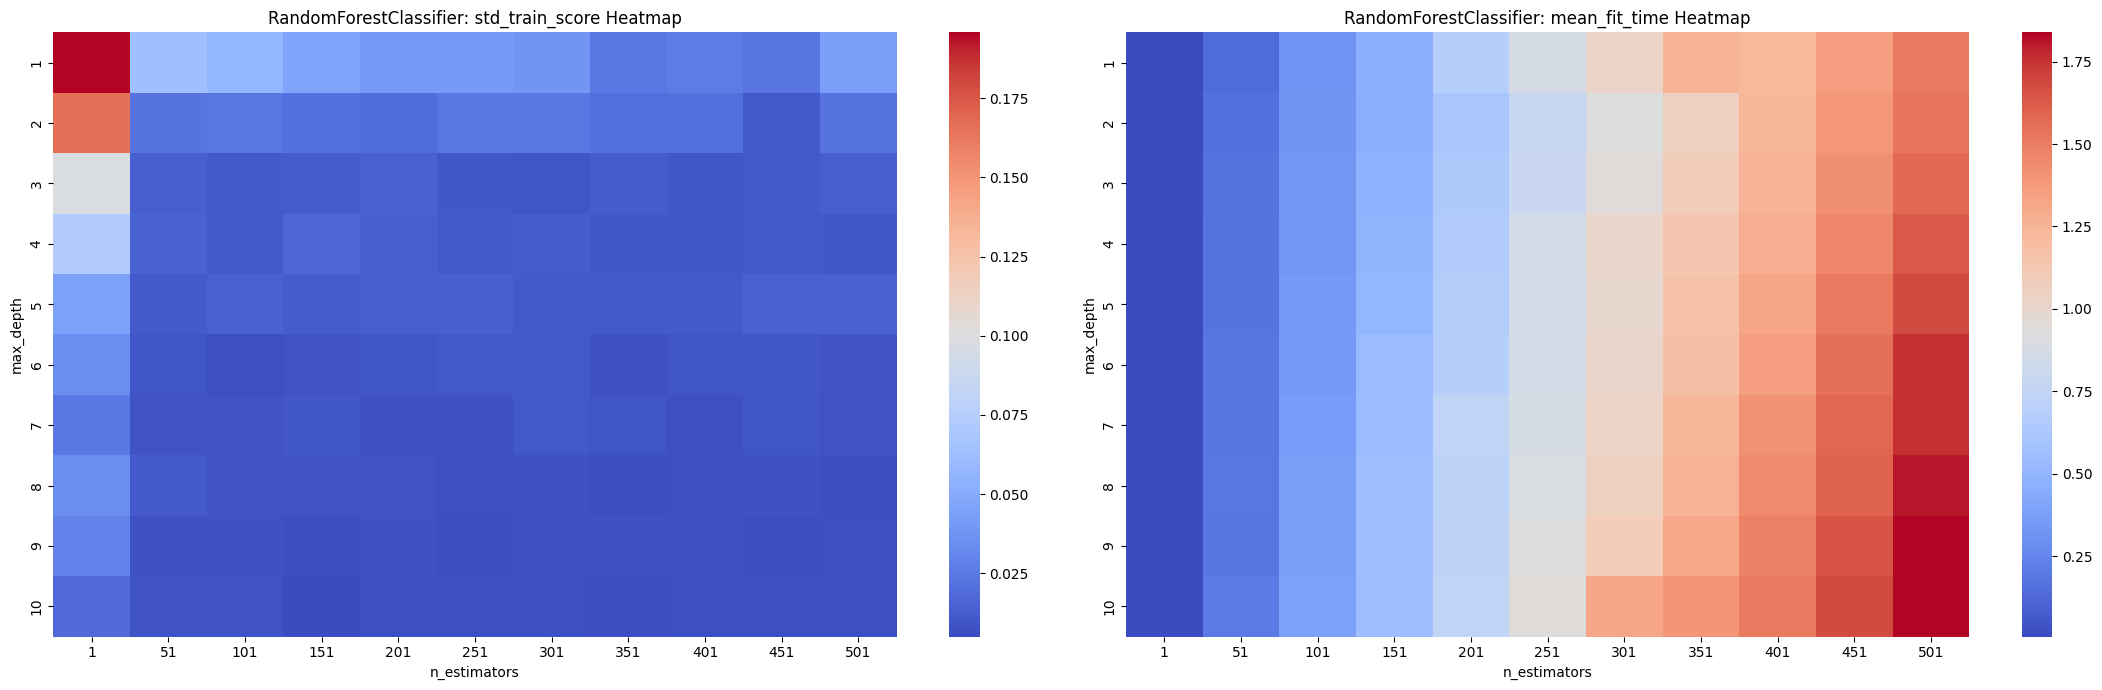

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(22, 7))
axes_iter = iter(axes.flatten())

Plotter.plot_param_heatmap(rf_model, "n_estimators", "max_depth", plot_ax=next(axes_iter), metric="std_train_score")
Plotter.plot_param_heatmap(rf_model, "n_estimators", "max_depth", plot_ax=next(axes_iter), metric="mean_fit_time")

plt.tight_layout()

In [181]:
param_grids = {
    LOGISTIC_REGRESSION: {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "max_iter": [500, 1000, 2000],
        "solver": ["liblinear", "saga"]
    },
    KNN: {
        "n_neighbors": range(1,15, 2),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
        "n_jobs": [-1],
    },
    GRADIENT_DESCENT: {
        "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge"],
        "alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        "penalty": ["l2", "l1", "elasticnet", None],
        "max_iter": [500, 1000, 2000],
        "learning_rate": ["constant", "optimal", "adaptive", "invscaling"],
        "eta0": [0.001, 0.01, 0.1]
    },
    RANDOM_FOREST: {
        "n_estimators": range(1, 500, 50),
        "max_depth": [2, 3, 4, 5, 10, 15, None],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False],
        "n_jobs": [-1],
    },
    EXTRA_TREES: {
        "n_estimators": range(1, 500, 50),
        "max_depth": [2, 3, 4, 5, 10, 15, None],
        "max_features": ["auto", "sqrt", "log2"],
        "bootstrap": [True, False],
        "n_jobs": [-1],
    },
    SUPPORT_VECTOR_MACHINE: {
        "C": [0.001, 0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale", "auto"]
    },
    LINEAR_SVC: {
        "C": [0.01, 0.1, 1, 10, 100],
        "loss": ["hinge", "squared_hinge"],
        "max_iter": [1000, 2000, 5000],
    },
    GRADIENT_BOOSTING: {
        "n_estimators": range(1, 500, 50),
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [2, 3, 4, 5, 6],
        "subsample": [0.6, 0.7, 0.8, 1.0],
        "max_features": ["auto", "sqrt", "log2", None],
    },
    NAIVE_BAYES: {
        "var_smoothing": [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    },
    PERCEPTRON: {
        "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
        "penalty": [None, "l2", "l1", "elasticnet"],
        "max_iter": [500, 1000, 2000],
        "eta0": [0.001, 0.01, 0.1],
        "learning_rate": ["constant", "optimal", "invscaling", "adaptive"]
    },
    PASSIVE_AGGRESSIVE: {
        "C": [0.001, 0.01, 0.1, 1, 10],
        "max_iter": [500, 1000, 2000],
        "loss": ["hinge", "squared_hinge"]
    },
    NEURAL_NETWORK: {
        "hidden_layer_sizes": [(50,), (100,), (50,50), (100,50), (50,100,50)],
        "activation": ["relu", "tanh", "logistic"],
        "alpha": [1e-5, 1e-4, 0.001, 0.01],
        "learning_rate": ["constant", "adaptive", "invscaling"],
        "learning_rate_init": [0.001, 0.01, 0.1],
        "max_iter": [500, 1000, 2000],
        "solver": ["adam", "sgd"]
    }
}

Definim, llavors, uns paràmetres a provar per cada model:

In [182]:
param_grids = {
    LOGISTIC_REGRESSION: {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "max_iter": [1000],
    },
    KNN: {
        "n_neighbors": range(1,15, 2),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
        "n_jobs": [-1],
    },
    GRADIENT_DESCENT: {
        "alpha": [1e-3, 1e-2, 1e-1],
        "max_iter": [1000],
        "learning_rate": ["constant", "optimal"],
        "eta0": [0.01, 0.1]
    },
    RANDOM_FOREST: {
        "n_estimators": range(1, 500, 50),
        "max_depth": [2, 3, 4, 5],
        "n_jobs": [-1],
    },
    EXTRA_TREES: {
        "n_estimators": range(1, 500, 50),
        "max_depth": [2, 3, 4, 5],
        "n_jobs": [-1],
    },
    SUPPORT_VECTOR_MACHINE: {
        "C": [0.001, 0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale", "auto"]
    },
    LINEAR_SVC: {
        "C": [0.01, 0.1, 1, 10],
        "loss": ["hinge", "squared_hinge"],
        "max_iter": [1000, 2000, 5000],
    },
    GRADIENT_BOOSTING: {
        "n_estimators": range(1, 500, 50),
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [2, 3, 4, 5, 6],
    },
    NAIVE_BAYES: {
        "var_smoothing": [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    },
    PERCEPTRON: {
        "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
        "max_iter": [1000],
        "eta0": [0.01, 0.1],
        "n_jobs": [-1]
    },
    PASSIVE_AGGRESSIVE: {
        "C": [0.001, 0.01, 0.1, 1, 10],
        "max_iter": [1000],
    },
    NEURAL_NETWORK: {
        "activation": ["relu", "tanh", "logistic"],
        "alpha": [1e-5, 1e-4, 0.001, 0.01],
        "learning_rate": ["constant", "adaptive", "invscaling"],
        "max_iter": [1000],
    }
}

In [183]:
specific_model = None

results = {}
opt_params = {}
opt_models = {}

with tqdm(MODELS.items(), desc="Optimizing models", leave=False) as pbar:
    for model_name, model_class in pbar:
        if (specific_model is not None) and (specific_model != model_name):
            continue
        pbar.set_postfix({"model": model_name})

        model = Model(
            model_class=model_class,
            dataframe=DATAFRAME_REDUCED
        )

        param_grid = param_grids[model_name]

        results[model_name] = HyperParameterOptimization.grid_search(model, param_grid)
        opt_params[model_name] = model.hyperparameters
        opt_models[model_name] = model

In [196]:
results = {}
opt_params = {}
opt_models = {}

with tqdm(MODELS.items(), desc="Optimizing models", leave=False) as pbar:
    for model_name, model_class in pbar:
        pbar.set_postfix({"model": model_name})

        model = Model(
            model_class=model_class,
            dataframe=DATAFRAME_REDUCED
        )

        param_grid = param_grids[model_name]

        results[model_name] = HyperParameterOptimization.grid_search(model, param_grid)
        opt_params[model_name] = model.hyperparameters
        opt_models[model_name] = model

Optimizing models:   0%|          | 0/12 [00:00<?, ?it/s]

Imprimim per pantalla els resultats dels millors paràmetres:

In [185]:
display(opt_params)

{'Logistic Regression': {'C': 1, 'max_iter': 1000, 'penalty': 'l2'},
 'KNN': {'metric': 'euclidean',
  'n_jobs': -1,
  'n_neighbors': 9,
  'weights': 'uniform'},
 'Gradient Descent': {'alpha': 0.01,
  'eta0': 0.1,
  'learning_rate': 'constant',
  'max_iter': 1000},
 'Random Forest': {'max_depth': 5, 'n_estimators': 451, 'n_jobs': -1},
 'Extra Trees': {'max_depth': 2, 'n_estimators': 51, 'n_jobs': -1},
 'Support Vector Machine': {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'},
 'LinearSVC': {'C': 0.1, 'loss': 'hinge', 'max_iter': 1000},
 'Gradient Boosting': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 201},
 'Naive Bayes': {'var_smoothing': 1e-12},
 'Perceptron': {'alpha': 1e-05, 'eta0': 0.1, 'max_iter': 1000, 'n_jobs': -1},
 'Passive Aggressive': {'C': 0.001, 'max_iter': 1000},
 'Neural Network': {'activation': 'tanh',
  'alpha': 0.01,
  'learning_rate': 'adaptive',
  'max_iter': 1000}}

Per decidir quin model triar, mirem l'score aconseguit per cada model:

In [199]:
best_scores = {}
best_params = {}

for model_name, model in opt_models.items():
    best_scores[model_name] = max(model.search_results_["mean_test_score"])
    best_params[model_name] = model.hyperparameters

best_results_df = pd.DataFrame({
    "mean_test_score": best_scores,
    "best_params": best_params
})

pd.set_option('display.max_colwidth', None)
display(best_results_df)


,mean_test_score,best_params
Logistic Regression,0.710613,"{'C': 1, 'max_iter': 1000, 'penalty': 'l2'}"
KNN,0.709821,"{'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 9, 'weights': 'uniform'}"
Gradient Descent,0.710884,"{'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 1000}"
Random Forest,0.704236,"{'max_depth': 5, 'n_estimators': 101, 'n_jobs': -1}"
Extra Trees,0.710131,"{'max_depth': 2, 'n_estimators': 51, 'n_jobs': -1}"
Support Vector Machine,0.710131,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}"
LinearSVC,0.710131,"{'C': 0.1, 'loss': 'hinge', 'max_iter': 1000}"
Gradient Boosting,0.726538,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 201}"
Naive Bayes,0.716417,{'var_smoothing': 1e-12}
Perceptron,0.610796,"{'alpha': 1e-05, 'eta0': 0.1, 'max_iter': 1000, 'n_jobs': -1}"


Considerem que el millor és el Gradient Boosting. Comprovem ràpidament totes les combinacions de features per mirar si podem millorar el randiment si traiem la informació redundant:

In [195]:
from itertools import combinations

cols = DATAFRAME_REDUCED.drop(EXPLANATORY, axis=1).columns
features_combinations = []
for r in range(1, len(cols)+1):
    for combo in combinations(cols, r):
        features_combinations.append(list(combo))

results = []

model = Model(
    model_class=MODELS[GRADIENT_BOOSTING],
    dataframe=DATAFRAME_REDUCED,
    name=GRADIENT_BOOSTING, 
    hyperparameters={'learning_rate': 0.1,'max_depth': 3,'n_estimators': 201},
)

with tqdm(features_combinations, desc=f"{GRADIENT_BOOSTING}", leave=False) as pbar:
    for features in pbar:
        pbar.set_postfix({"features": features})

        model.update_dataset(features=features)
        model.predict()  # Cal cridar predict() abans d'avaluar
        metrics = Metrics.evaluate(model)
        results.append({"Model": GRADIENT_BOOSTING, "Features": features, **metrics})

results_df = pd.DataFrame(results)
display(results_df)

,Model,Features,F1,AUC-ROC,AUC_PR
0,Gradient Boosting,[Pclass],0.490191,0.637051,0.520001
1,Gradient Boosting,[Fare],0.571296,0.717433,0.578747
2,Gradient Boosting,[Sex_male],0.709787,0.760145,0.640085
3,Gradient Boosting,[Title_Mrs],0.426504,0.594986,0.492194
4,Gradient Boosting,[Title_Ms],0.491789,0.658310,0.548443
5,Gradient Boosting,"[Pclass, Fare]",0.589054,0.723507,0.579463
6,Gradient Boosting,"[Pclass, Sex_male]",0.642572,0.813195,0.753294
7,Gradient Boosting,"[Pclass, Title_Mrs]",0.577933,0.694430,0.596241
8,Gradient Boosting,"[Pclass, Title_Ms]",0.584183,0.725769,0.660652
9,Gradient Boosting,"[Fare, Sex_male]",0.730959,0.851060,0.818492


Veiem que millorem l'score, per tant, ens quedarem amb aquestes columnes:

Representem les gràfiques del model escollit:

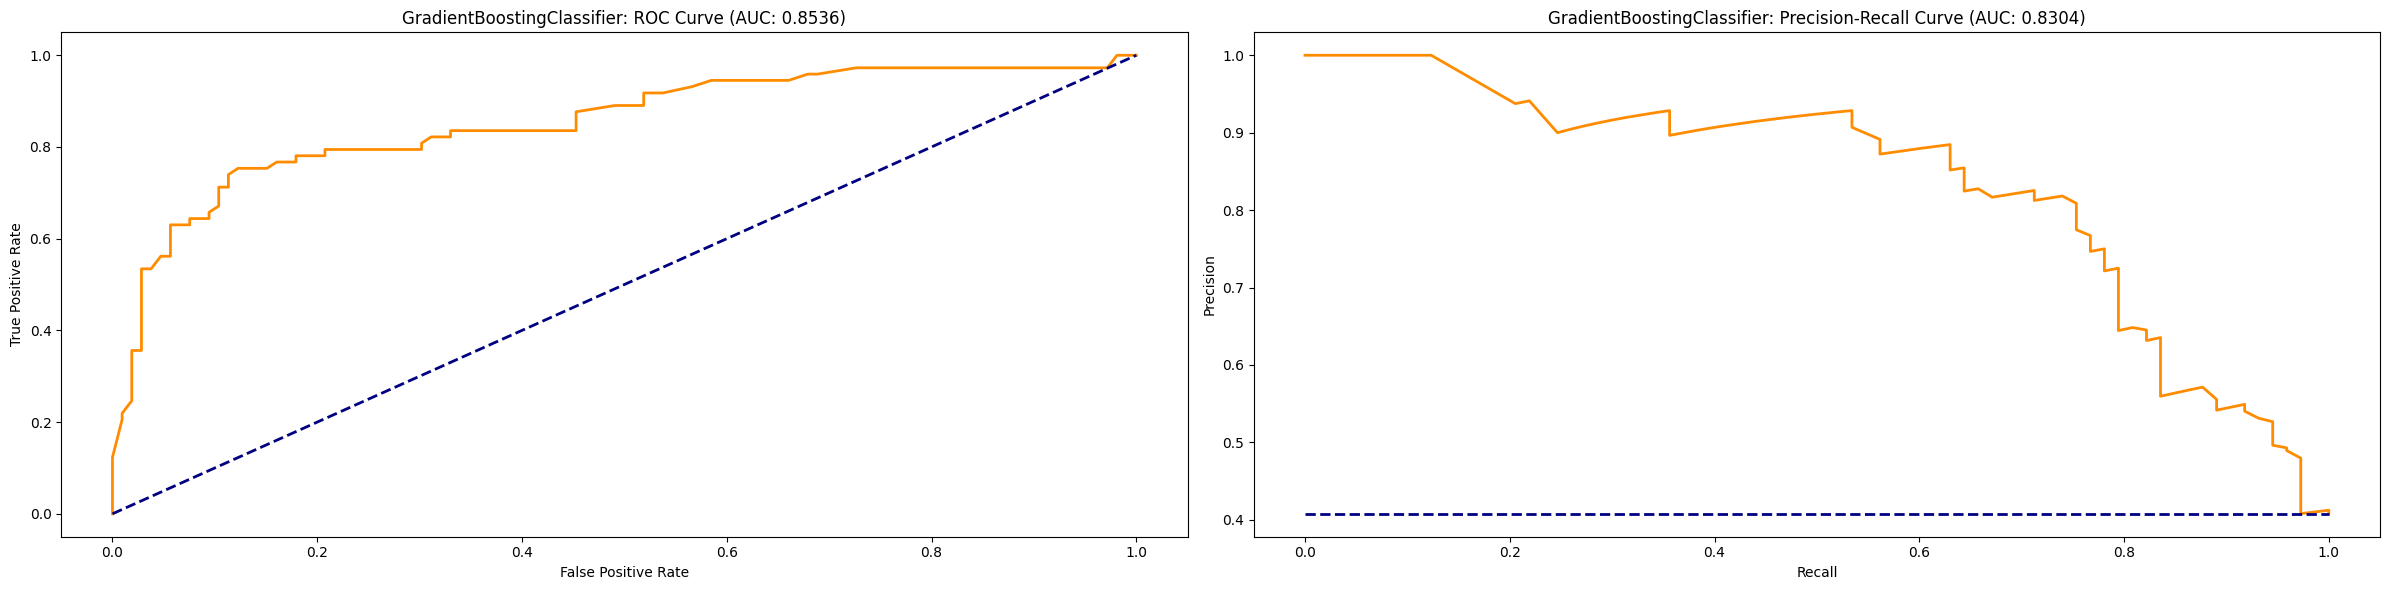

In [211]:
model = Model(
    model_class=MODELS[GRADIENT_BOOSTING],
    dataframe=DATAFRAME_REDUCED[['Pclass', 'Fare', 'Sex_male','Survived']],
    hyperparameters={'learning_rate': 0.1,'max_depth': 3,'n_estimators': 201}
)

fig, axes = plt.subplots(1, 2, figsize=(24, 6))
axes_iter = iter(axes.flatten())

Plotter.plot_roc(model, plot_ax=next(axes_iter))
Plotter.plot_pr(model, plot_ax=next(axes_iter))

plt.tight_layout()

Veiem que el model té un comportament prou habitual. Per tant, donem el model com a vàlid.

Calculem totes les mètriques:

In [207]:
metrics = {
    ACCURACY: accuracy_score(model.y_test, model.y_pred),
    PRECISION: precision_score(model.y_test, model.y_pred),
    RECALL: recall_score(model.y_test, model.y_pred),
    F1: f1_score(model.y_test, model.y_pred),
    AUC_ROC: roc_auc_score(model.y_test, model.y_pred_probs),
    AUC_PR: average_precision_score(model.y_test, model.y_pred_probs),
}
metrics

{'Accuracy': 0.8044692737430168,
 'Precision': 0.8392857142857143,
 'Recall': 0.6438356164383562,
 'F1': 0.7286821705426356,
 'AUC-ROC': np.float64(0.8535151201860947),
 'AUC_PR': np.float64(0.8299393520897749)}

La mètrica que menys ens agrada és recall, ja que és molt baixa. Hem de tenir en compte que aquestes dades s'han calculat fent servir una validació creuada i que realment tenim poques dades per entrenar i validar el model.

Mirant críticament a les mètriques obtingues, podríem dir que no hem aconseguit el que del tot esperàvem. Realment, un valor de F1 de poc més de 0.74 no és molt satisfactori, però som molt conscients de les limitacions que tenim. Tenint en compte que hem escollit uns paràmetres que eviten el risc d'overfit, i també estem considerant resultats de validacions creuades, considerem que el resultat obtingut és suficientment bo.

Tot i això, hi ha molt marge de millora:

- Primer, hauríem de millorar les features tenint en compte el tipus de model amb què estem treballant. Pensem que hem dedicat molt temps a les primeres parts de la pràctica, però ens ha faltat una anàlisi més profunda de cada model i especialitzar més cada cas. Som conscients que cada tipus de model és únic i cadascun té les seves particularitats. Difícilment podràs crear un dataset estàndard per 12 models i esperar que tots funcionin bé.
- En quant als hiperparàmetres del model, es podria indagar molt més, optimitzant altres paràmetres del model com la mida mínima de la fulla.